### PREDICTION PLAYGROUND [PETRA|VNM]
___

In [1]:
import os
import spectrai as spa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, resample

from kymatio.numpy import Scattering1D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils
#from tensorflow.keras.utils import plot_model, normalize

from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2
%matplotlib inline  

### 1. Data loading

In [2]:
DATA_PATH = os.path.join('..', 'data')
VIETNAM_PATH =  os.path.join('vnm-petra', 'mir-models')
DATA_URL = os.path.join(DATA_PATH, VIETNAM_PATH, '*.*')
VIETNAM_MEAS_URL = os.path.join(DATA_PATH, 'vnm-petra', 'mir-models', '20090215-soil-database-mirs.xls')

X, X_names, y, y_names, instances_id, _ = spa.load_data_petra(DATA_URL, VIETNAM_MEAS_URL)
print('X shape: ', X.shape)
print(y_names)
print(instances_id)

X shape:  (130, 1763)
['TC' 'TOC' 'TIC' 'TN' 'CEC' 'K' 'FCAVER' 'FCIAVER' 'FSAAVER']
['Av001' 'Av003' 'Av005' 'Av008' 'Av013' 'Av014' 'Av018' 'Av020' 'Av023'
 'Av026' 'Av027' 'Av032' 'Av036' 'Av038' 'Av040' 'Av041' 'Av042' 'Av043'
 'Av045' 'Av048' 'Av051' 'Av057' 'Av061' 'Av062' 'Av063' 'Av064' 'Av065'
 'Av067' 'Av069' 'Av072' 'Av077' 'Av080' 'Av083' 'Av086' 'Av092' 'Av098'
 'Av100' 'Av102' 'Av105' 'Av106' 'Av108' 'Av110' 'Av113' 'Av121' 'Av127'
 'Av133' 'Av139' 'Av141' 'Av143' 'Av146' 'Av147' 'Av149' 'Av152' 'Av155'
 'Av161' 'Av165' 'Av169' 'Av171' 'Av174' 'Av175' 'Av177' 'Av180' 'Av183'
 'Av189' 'Av195' 'Av203' 'Av205' 'Av208' 'Av209' 'Av211' 'Av214' 'Av217'
 'Av225' 'Av226' 'Av235' 'Av239' 'Av242' 'Av244' 'Av246' 'Av247' 'Av249'
 'Av252' 'Av255' 'Av261' 'Av265' 'Av267' 'Av268' 'Av272' 'Av365' 'Av366'
 'Av367' 'Av368' 'Av369' 'Av370' 'Av371' 'Av372' 'Av373' 'Av374' 'Av375'
 'Av376' 'Av377' 'Av378' 'Av379' 'Av380' 'F1 1.1A' 'F1 1.1B' 'F1 1.3A'
 'F1 1.3B' 'F1 1.6A' 'F1 1.6B' 'F1 2.3' '

In [53]:
y_names

array(['TC', 'TOC', 'TIC', 'TN', 'CEC', 'K', 'FCAVER', 'FCIAVER',
       'FSAAVER'], dtype=object)

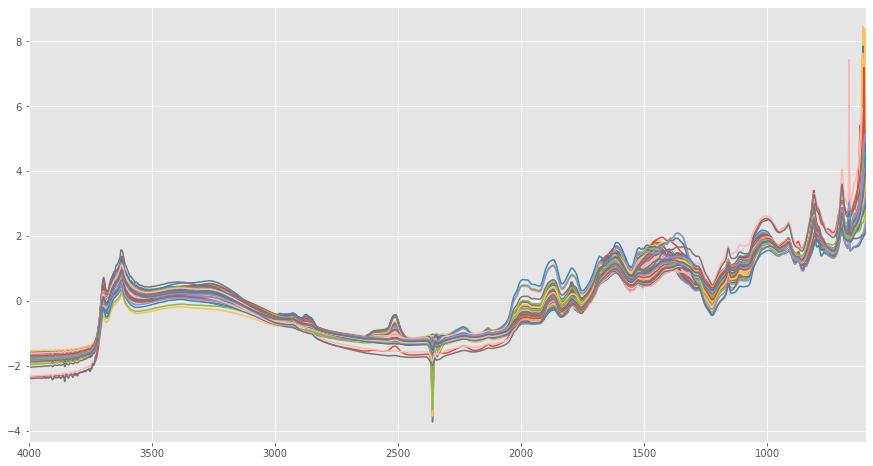

In [54]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, X.T)

### 2. Partial Least Square Regressions (PLSR)

#### 2.1 Utilities functions

In [4]:
def assess_model_complexity(X_train, X_valid, y_train, y_valid, analyte, n_comp=10, plot=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse_train = []
    mse_valid = []
    y_train = get_analyte(y_train, y_names, analyte)
    y_valid = get_analyte(y_valid, y_names, analyte)
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)
        y_train_pred = pls.predict(X_train)
        y_valid_pred = pls.predict(X_valid)
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_valid.append(mean_squared_error(y_valid, y_valid_pred))

    msemin = np.argmin(mse_valid)
    print('Suggested number of components: ', msemin+1)
    
    pls = PLSRegression(n_components=msemin+1)
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    y_valid_pred = pls.predict(X_valid)
    score_train = r2_score(y_train, y_train_pred)
    score_valid = r2_score(y_valid, y_valid_pred)
    print('R2 train: %5.3f'  % score_train)
    print('R2 validation: %5.3f'  % score_valid)
    
    if plot is True:
        fig, ax = plt.subplots(figsize=(10,6))
        _ = ax.plot(component, np.array(mse_train), '-v', color = 'blue', mfc='blue')
        _ = ax.plot(component, np.array(mse_valid), '-v', color = 'red', mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('MSE of predicted {} content'.format(analyte))
        plt.title('Assessing model complexity')
        
    return score_valid   


def get_analyte(y, names, name):
    list(y_names).index(name)
    return y[:,list(y_names).index(name)]


def optimise_pls_cv(X, y, n_comp=10, cv=20, plot_components=True, analyte='P'):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    print(20*'*')
    print("Predicting: ", analyte)
    print(20*'*')
    mse = []
    y = get_analyte(y, y_names, analyte)
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=cv)
        mse.append(mean_squared_error(y, y_cv))
        #comp = 100*(i+1)/40
        # Trick to update status on the same line
        #stdout.write("\r%d%% completed" % comp)
        #stdout.flush()
    #stdout.write("\n")
    
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    #stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE cross-validation')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
        
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=cv)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted analyte')
        plt.ylabel('Measured Analyte')
        plt.show()
    
    return pls_opt

********************
Predicting:  TC
********************
Suggested number of components:  16


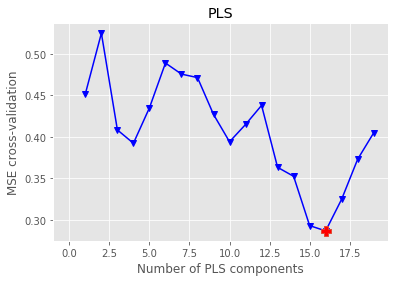

R2 calib: 0.987
R2 CV: 0.841
MSE calib: 0.024
MSE CV: 0.287


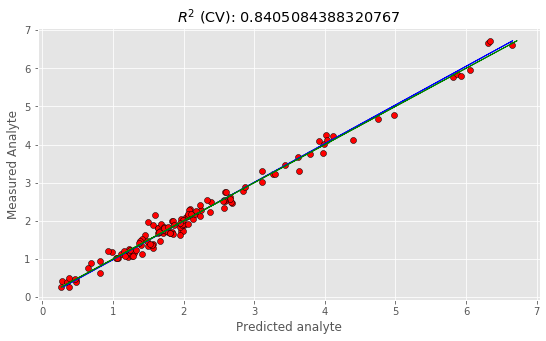

In [58]:
X1_all = savgol_filter(X, 11, polyorder = 1, deriv=1)
pls_opt = optimise_pls_cv(X1_all, y, n_comp=20, cv=5, plot_components=True, analyte='TC')

In [61]:
pls_opt.x_loadings_.shape

(1763, 16)

#### 2.2 K-fold cross-validation (20%) for TC, TOC, TIC, TN

********************
Predicting:  TC
********************
Suggested number of components:  16


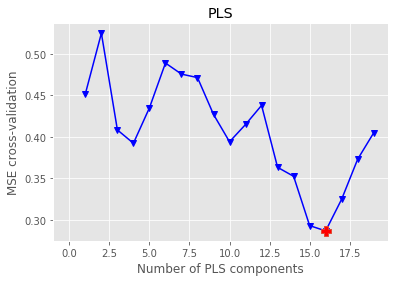

R2 calib: 0.987
R2 CV: 0.841
MSE calib: 0.024
MSE CV: 0.287


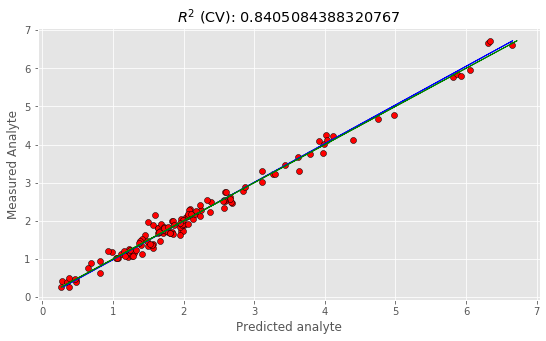

********************
Predicting:  TOC
********************
Suggested number of components:  13


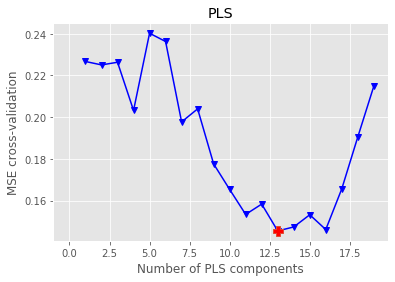

R2 calib: 0.965
R2 CV: 0.652
MSE calib: 0.015
MSE CV: 0.145


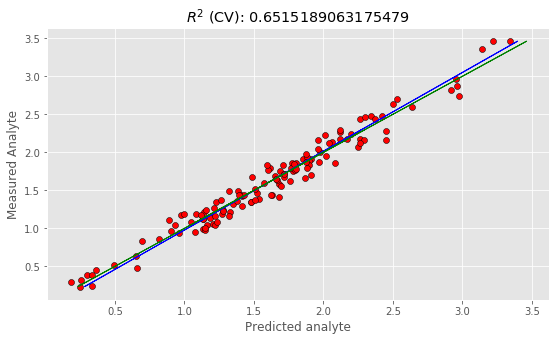

********************
Predicting:  TIC
********************
Suggested number of components:  4


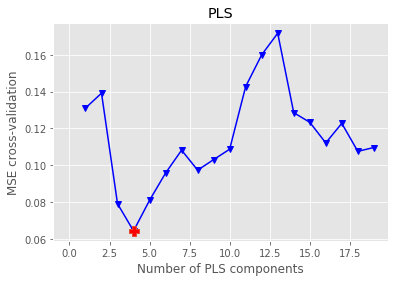

R2 calib: 0.957
R2 CV: 0.904
MSE calib: 0.029
MSE CV: 0.064


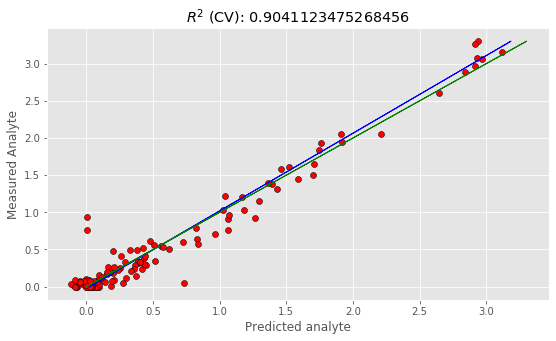

********************
Predicting:  TN
********************
Suggested number of components:  4


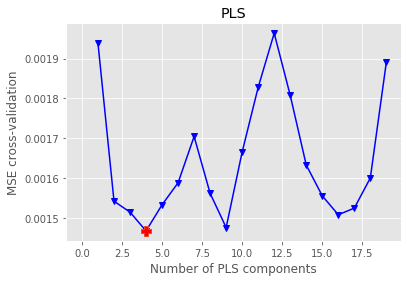

R2 calib: 0.892
R2 CV: 0.693
MSE calib: 0.001
MSE CV: 0.001


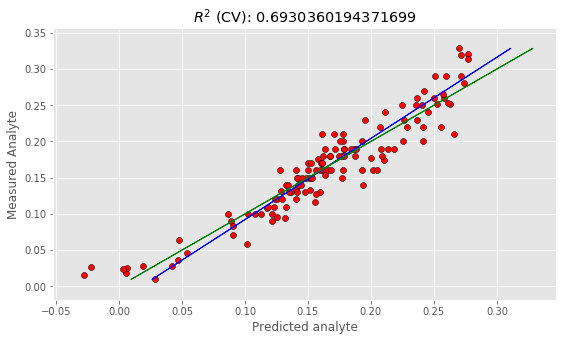

In [7]:
# With cross-validation
X1_all = savgol_filter(X, 11, polyorder = 1, deriv=1)

for analyte in ['TC', 'TOC', 'TIC', 'TN']:
    optimise_pls_cv(X1_all, y, n_comp=20, cv=5, plot_components=True, analyte=analyte)

#### 2.3 K-fold cross-validation (20%) for K and CEC

********************
Predicting:  K
********************
Suggested number of components:  6


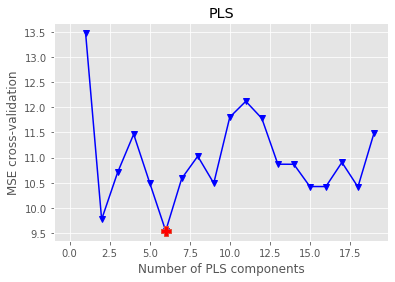

R2 calib: 0.878
R2 CV: 0.340
MSE calib: 1.761
MSE CV: 9.545


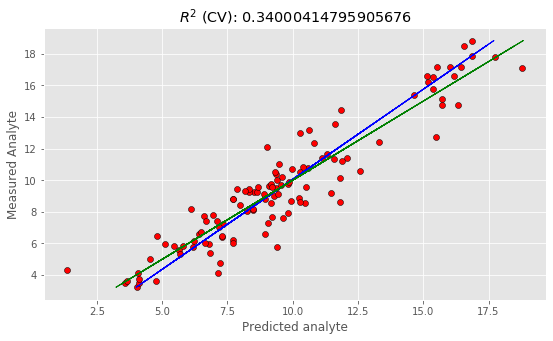

********************
Predicting:  CEC
********************
Suggested number of components:  2


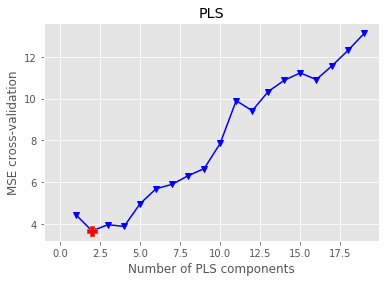

R2 calib: 0.470
R2 CV: 0.250
MSE calib: 2.585
MSE CV: 3.658


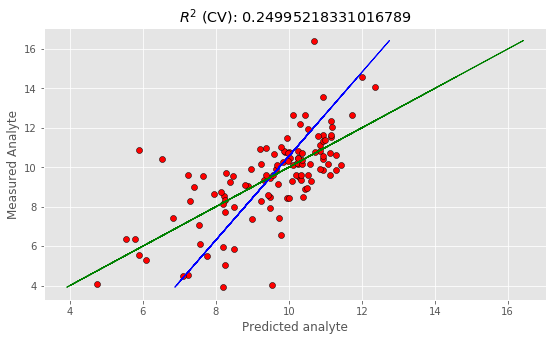

In [8]:
# Remove NaN values (specific to K and CEC)
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

# With cross-validation
X1_all = savgol_filter(X_not_nan, 11, polyorder = 1, deriv=1)

for analyte in ['K', 'CEC']:
    optimise_pls_cv(X1_all, y_not_nan, n_comp=20, cv=5, plot_components=True, analyte=analyte)

### 3. Convolutional Neural Networks (CNN)

#### 3.1 Utilities functions

In [17]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def standardize(X):
    return (X - X.mean()) - X.std()

def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

#### 3.2 Single channel 1D CNN

In [9]:
MODEL_PATH = os.path.join('..', 'models', 'basic-cnn-tic.h5')

In [12]:
# If required restore
#load_model('somefile', custom_objects={'x': x})
model = models.load_model(MODEL_PATH, custom_objects={'coeff_determination': coeff_determination})

In [13]:
activation = 'relu'
input_dim = X.shape[1]

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model.add(layers.Conv1D(32, 30, activation=activation))
model.add(layers.MaxPool1D(10))

model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(10))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation=activation))
model.add(layers.Dense(50, activation=activation))
model.add(layers.Dense(10, activation=activation))
model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1763, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1734, 32)          992       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 173, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=42)

analyte = 'TIC'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_valid_analyte = get_analyte(y_valid, y_names, analyte)

history = model.fit(normalize(X_train), y_train_analyte, epochs=2000, validation_data=(normalize(X_valid), y_valid_analyte))

Train on 78 samples, validate on 52 samples
Epoch 1/2000
78/78 [==============================] - 1s 11ms/sample - loss: 0.9353 - coeff_determination: -0.3769 - val_loss: 0.7842 - val_coeff_determination: -0.2092
Epoch 2/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.8787 - coeff_determination: -0.3791 - val_loss: 0.7224 - val_coeff_determination: -0.1144
Epoch 3/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.7097 - coeff_determination: -0.0330 - val_loss: 0.6509 - val_coeff_determination: -0.0026
Epoch 4/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.7044 - coeff_determination: -0.0296 - val_loss: 0.6653 - val_coeff_determination: -0.0263
Epoch 5/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.6873 - coeff_determination: -0.0130 - val_loss: 0.6844 - val_coeff_determination: -0.0558
Epoch 6/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.6800 - coeff_determination: -0.0015 -

78/78 [==============================] - 0s 2ms/sample - loss: 0.0725 - coeff_determination: 0.9028 - val_loss: 0.0306 - val_coeff_determination: 0.9557
Epoch 99/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0480 - coeff_determination: 0.9212 - val_loss: 0.0321 - val_coeff_determination: 0.9530
Epoch 100/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0387 - coeff_determination: 0.8587 - val_loss: 0.0703 - val_coeff_determination: 0.8972
Epoch 101/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0447 - coeff_determination: 0.9256 - val_loss: 0.0420 - val_coeff_determination: 0.9386
Epoch 102/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0435 - coeff_determination: 0.9316 - val_loss: 0.0611 - val_coeff_determination: 0.9115
Epoch 103/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0366 - coeff_determination: 0.9458 - val_loss: 0.0980 - val_coeff_determination: 0.8564
Epoch 10

Epoch 147/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0479 - coeff_determination: 0.9325 - val_loss: 0.0747 - val_coeff_determination: 0.8913
Epoch 148/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0364 - coeff_determination: 0.9499 - val_loss: 0.0580 - val_coeff_determination: 0.9161
Epoch 149/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0336 - coeff_determination: 0.9365 - val_loss: 0.0602 - val_coeff_determination: 0.9128
Epoch 150/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0435 - coeff_determination: 0.9382 - val_loss: 0.0328 - val_coeff_determination: 0.9524
Epoch 151/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0477 - coeff_determination: 0.9109 - val_loss: 0.2073 - val_coeff_determination: 0.6810
Epoch 152/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1264 - coeff_determination: 0.7020 - val_loss: 0.1431 - val_coeff_determination:

Epoch 196/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0436 - coeff_determination: 0.9324 - val_loss: 0.0785 - val_coeff_determination: 0.8838
Epoch 197/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0579 - coeff_determination: 0.9129 - val_loss: 0.0385 - val_coeff_determination: 0.9408
Epoch 198/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0393 - coeff_determination: 0.9482 - val_loss: 0.0441 - val_coeff_determination: 0.9317
Epoch 199/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0406 - coeff_determination: 0.9413 - val_loss: 0.0227 - val_coeff_determination: 0.9669
Epoch 200/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0276 - coeff_determination: 0.9515 - val_loss: 0.0192 - val_coeff_determination: 0.9720
Epoch 201/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0328 - coeff_determination: 0.9521 - val_loss: 0.0238 - val_coeff_determination:

Epoch 245/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0477 - coeff_determination: 0.8330 - val_loss: 0.0166 - val_coeff_determination: 0.9752
Epoch 246/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0255 - coeff_determination: 0.9634 - val_loss: 0.0291 - val_coeff_determination: 0.9547
Epoch 247/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0393 - coeff_determination: 0.9519 - val_loss: 0.0217 - val_coeff_determination: 0.9688
Epoch 248/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0250 - coeff_determination: 0.9590 - val_loss: 0.0225 - val_coeff_determination: 0.9678
Epoch 249/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0226 - coeff_determination: 0.9619 - val_loss: 0.0175 - val_coeff_determination: 0.9739
Epoch 250/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0334 - coeff_determination: 0.9438 - val_loss: 0.0252 - val_coeff_determination:

Epoch 294/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0291 - coeff_determination: 0.9636 - val_loss: 0.0155 - val_coeff_determination: 0.9768
Epoch 295/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0254 - coeff_determination: 0.9613 - val_loss: 0.0263 - val_coeff_determination: 0.9622
Epoch 296/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0244 - coeff_determination: 0.9648 - val_loss: 0.0175 - val_coeff_determination: 0.9747
Epoch 297/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0373 - coeff_determination: 0.9431 - val_loss: 0.0169 - val_coeff_determination: 0.9755
Epoch 298/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0224 - coeff_determination: 0.9655 - val_loss: 0.0219 - val_coeff_determination: 0.9662
Epoch 299/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0321 - coeff_determination: 0.9545 - val_loss: 0.0366 - val_coeff_determination:

Epoch 343/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0200 - coeff_determination: 0.9689 - val_loss: 0.0180 - val_coeff_determination: 0.9725
Epoch 344/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0716 - coeff_determination: 0.8457 - val_loss: 0.1130 - val_coeff_determination: 0.8334
Epoch 345/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0389 - coeff_determination: 0.9470 - val_loss: 0.0152 - val_coeff_determination: 0.9782
Epoch 346/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0188 - coeff_determination: 0.9743 - val_loss: 0.0146 - val_coeff_determination: 0.9784
Epoch 347/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0186 - coeff_determination: 0.9666 - val_loss: 0.0178 - val_coeff_determination: 0.9746
Epoch 348/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0225 - coeff_determination: 0.9618 - val_loss: 0.0189 - val_coeff_determination:

Epoch 392/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0176 - coeff_determination: 0.9724 - val_loss: 0.0484 - val_coeff_determination: 0.9289
Epoch 393/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0214 - coeff_determination: 0.9721 - val_loss: 0.0296 - val_coeff_determination: 0.9570
Epoch 394/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0323 - coeff_determination: 0.9535 - val_loss: 0.0425 - val_coeff_determination: 0.9341
Epoch 395/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0317 - coeff_determination: 0.9303 - val_loss: 0.0193 - val_coeff_determination: 0.9713
Epoch 396/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0173 - coeff_determination: 0.9654 - val_loss: 0.0216 - val_coeff_determination: 0.9675
Epoch 397/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0253 - coeff_determination: 0.9641 - val_loss: 0.0165 - val_coeff_determination:

Epoch 441/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0523 - coeff_determination: 0.9069 - val_loss: 0.0437 - val_coeff_determination: 0.9367
Epoch 442/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0192 - coeff_determination: 0.9631 - val_loss: 0.0325 - val_coeff_determination: 0.9527
Epoch 443/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0190 - coeff_determination: 0.9605 - val_loss: 0.0225 - val_coeff_determination: 0.9664
Epoch 444/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0206 - coeff_determination: 0.9577 - val_loss: 0.0260 - val_coeff_determination: 0.9625
Epoch 445/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0174 - coeff_determination: 0.9760 - val_loss: 0.0243 - val_coeff_determination: 0.9650
Epoch 446/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0223 - coeff_determination: 0.9596 - val_loss: 0.0202 - val_coeff_determination:

Epoch 490/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0160 - coeff_determination: 0.9561 - val_loss: 0.0204 - val_coeff_determination: 0.9710
Epoch 491/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0143 - coeff_determination: 0.9587 - val_loss: 0.0214 - val_coeff_determination: 0.9685
Epoch 492/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0165 - coeff_determination: 0.9651 - val_loss: 0.0167 - val_coeff_determination: 0.9754
Epoch 493/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0179 - coeff_determination: 0.9706 - val_loss: 0.0667 - val_coeff_determination: 0.8961
Epoch 494/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0491 - coeff_determination: 0.9307 - val_loss: 0.0182 - val_coeff_determination: 0.9724
Epoch 495/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0175 - coeff_determination: 0.9675 - val_loss: 0.0198 - val_coeff_determination:

Epoch 539/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0189 - coeff_determination: 0.9683 - val_loss: 0.0271 - val_coeff_determination: 0.9602
Epoch 540/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0133 - coeff_determination: 0.9818 - val_loss: 0.0202 - val_coeff_determination: 0.9704
Epoch 541/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0145 - coeff_determination: 0.9790 - val_loss: 0.0634 - val_coeff_determination: 0.9014
Epoch 542/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0506 - coeff_determination: 0.8852 - val_loss: 0.0180 - val_coeff_determination: 0.9736
Epoch 543/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0189 - coeff_determination: 0.9341 - val_loss: 0.0397 - val_coeff_determination: 0.9424
Epoch 544/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0263 - coeff_determination: 0.9551 - val_loss: 0.0213 - val_coeff_determination:

Epoch 588/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0246 - coeff_determination: 0.9629 - val_loss: 0.0503 - val_coeff_determination: 0.9219
Epoch 589/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0222 - coeff_determination: 0.9724 - val_loss: 0.0196 - val_coeff_determination: 0.9713
Epoch 590/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0138 - coeff_determination: 0.9816 - val_loss: 0.0272 - val_coeff_determination: 0.9605
Epoch 591/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0127 - coeff_determination: 0.9660 - val_loss: 0.0207 - val_coeff_determination: 0.9696
Epoch 592/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0146 - coeff_determination: 0.9733 - val_loss: 0.0263 - val_coeff_determination: 0.9608
Epoch 593/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0183 - coeff_determination: 0.9412 - val_loss: 0.0222 - val_coeff_determination:

Epoch 637/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0168 - coeff_determination: 0.9374 - val_loss: 0.0165 - val_coeff_determination: 0.9763
Epoch 638/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0271 - coeff_determination: 0.9553 - val_loss: 0.0223 - val_coeff_determination: 0.9672
Epoch 639/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0120 - coeff_determination: 0.9822 - val_loss: 0.0195 - val_coeff_determination: 0.9714
Epoch 640/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0228 - coeff_determination: 0.9535 - val_loss: 0.0393 - val_coeff_determination: 0.9428
Epoch 641/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0178 - coeff_determination: 0.8810 - val_loss: 0.0364 - val_coeff_determination: 0.9450
Epoch 642/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0148 - coeff_determination: 0.9776 - val_loss: 0.0366 - val_coeff_determination:

Epoch 686/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0121 - coeff_determination: 0.9817 - val_loss: 0.0446 - val_coeff_determination: 0.9318
Epoch 687/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0362 - coeff_determination: 0.9157 - val_loss: 0.0283 - val_coeff_determination: 0.9581
Epoch 688/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0125 - coeff_determination: 0.9498 - val_loss: 0.0380 - val_coeff_determination: 0.9439
Epoch 689/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0147 - coeff_determination: 0.9770 - val_loss: 0.0250 - val_coeff_determination: 0.9626
Epoch 690/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0163 - coeff_determination: 0.9757 - val_loss: 0.0386 - val_coeff_determination: 0.9444
Epoch 691/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0358 - coeff_determination: 0.9192 - val_loss: 0.0374 - val_coeff_determination:

Epoch 735/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0154 - coeff_determination: 0.9796 - val_loss: 0.0336 - val_coeff_determination: 0.9495
Epoch 736/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0113 - coeff_determination: 0.9775 - val_loss: 0.0272 - val_coeff_determination: 0.9609
Epoch 737/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0134 - coeff_determination: 0.9815 - val_loss: 0.0278 - val_coeff_determination: 0.9580
Epoch 738/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0109 - coeff_determination: 0.9846 - val_loss: 0.0447 - val_coeff_determination: 0.9352
Epoch 739/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0149 - coeff_determination: 0.9787 - val_loss: 0.0304 - val_coeff_determination: 0.9536
Epoch 740/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0140 - coeff_determination: 0.9614 - val_loss: 0.0324 - val_coeff_determination:

Epoch 784/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0108 - coeff_determination: 0.9819 - val_loss: 0.0376 - val_coeff_determination: 0.9450
Epoch 785/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0141 - coeff_determination: 0.9724 - val_loss: 0.0505 - val_coeff_determination: 0.9217
Epoch 786/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0239 - coeff_determination: 0.9648 - val_loss: 0.0223 - val_coeff_determination: 0.9684
Epoch 787/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0150 - coeff_determination: 0.9779 - val_loss: 0.0256 - val_coeff_determination: 0.9615
Epoch 788/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0171 - coeff_determination: 0.9707 - val_loss: 0.0957 - val_coeff_determination: 0.8602
Epoch 789/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0367 - coeff_determination: 0.9492 - val_loss: 0.0285 - val_coeff_determination:

Epoch 833/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0106 - coeff_determination: 0.9846 - val_loss: 0.0177 - val_coeff_determination: 0.9739
Epoch 834/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0236 - coeff_determination: 0.9426 - val_loss: 0.0252 - val_coeff_determination: 0.9646
Epoch 835/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0161 - coeff_determination: 0.9806 - val_loss: 0.0324 - val_coeff_determination: 0.9519
Epoch 836/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0081 - coeff_determination: 0.9760 - val_loss: 0.0246 - val_coeff_determination: 0.9636
Epoch 837/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0168 - coeff_determination: 0.9714 - val_loss: 0.0376 - val_coeff_determination: 0.9453
Epoch 838/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0097 - coeff_determination: 0.9864 - val_loss: 0.0321 - val_coeff_determination:

Epoch 882/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0121 - coeff_determination: 0.9704 - val_loss: 0.0217 - val_coeff_determination: 0.9690
Epoch 883/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0161 - coeff_determination: 0.9786 - val_loss: 0.0203 - val_coeff_determination: 0.9708
Epoch 884/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0097 - coeff_determination: 0.9842 - val_loss: 0.0335 - val_coeff_determination: 0.9513
Epoch 885/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0105 - coeff_determination: 0.9860 - val_loss: 0.0307 - val_coeff_determination: 0.9550
Epoch 886/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0153 - coeff_determination: 0.9695 - val_loss: 0.0829 - val_coeff_determination: 0.8700
Epoch 887/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0323 - coeff_determination: 0.9572 - val_loss: 0.0332 - val_coeff_determination:

Epoch 931/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0183 - coeff_determination: 0.9661 - val_loss: 0.0440 - val_coeff_determination: 0.9377
Epoch 932/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0279 - coeff_determination: 0.9544 - val_loss: 0.0257 - val_coeff_determination: 0.9615
Epoch 933/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0194 - coeff_determination: 0.9682 - val_loss: 0.0469 - val_coeff_determination: 0.9308
Epoch 934/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0098 - coeff_determination: 0.9868 - val_loss: 0.0302 - val_coeff_determination: 0.9562
Epoch 935/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0116 - coeff_determination: 0.9638 - val_loss: 0.0315 - val_coeff_determination: 0.9539
Epoch 936/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0075 - coeff_determination: 0.9883 - val_loss: 0.0342 - val_coeff_determination:

Epoch 980/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0120 - coeff_determination: 0.9830 - val_loss: 0.0234 - val_coeff_determination: 0.9661
Epoch 981/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0090 - coeff_determination: 0.9866 - val_loss: 0.0298 - val_coeff_determination: 0.9564
Epoch 982/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0076 - coeff_determination: 0.9863 - val_loss: 0.0471 - val_coeff_determination: 0.9306
Epoch 983/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0120 - coeff_determination: 0.9821 - val_loss: 0.0681 - val_coeff_determination: 0.8994
Epoch 984/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0220 - coeff_determination: 0.9709 - val_loss: 0.0185 - val_coeff_determination: 0.9734
Epoch 985/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0129 - coeff_determination: 0.9599 - val_loss: 0.0282 - val_coeff_determination:

78/78 [==============================] - 0s 2ms/sample - loss: 0.0058 - coeff_determination: 0.9926 - val_loss: 0.0299 - val_coeff_determination: 0.9566
Epoch 1077/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0062 - coeff_determination: 0.9542 - val_loss: 0.0180 - val_coeff_determination: 0.9743
Epoch 1078/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0084 - coeff_determination: 0.9869 - val_loss: 0.0321 - val_coeff_determination: 0.9532
Epoch 1079/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0121 - coeff_determination: 0.8283 - val_loss: 0.0317 - val_coeff_determination: 0.9529
Epoch 1080/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0156 - coeff_determination: 0.9771 - val_loss: 0.0316 - val_coeff_determination: 0.9543
Epoch 1081/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0055 - coeff_determination: 0.9924 - val_loss: 0.0323 - val_coeff_determination: 0.9533
Ep

78/78 [==============================] - 0s 1ms/sample - loss: 0.0077 - coeff_determination: 0.9884 - val_loss: 0.0255 - val_coeff_determination: 0.9627
Epoch 1173/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0055 - coeff_determination: 0.9868 - val_loss: 0.0633 - val_coeff_determination: 0.9052
Epoch 1174/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0127 - coeff_determination: 0.9801 - val_loss: 0.0522 - val_coeff_determination: 0.9239
Epoch 1175/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0060 - coeff_determination: 0.9849 - val_loss: 0.0316 - val_coeff_determination: 0.9545
Epoch 1176/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0033 - coeff_determination: 0.9934 - val_loss: 0.0368 - val_coeff_determination: 0.9469
Epoch 1177/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0052 - coeff_determination: 0.9915 - val_loss: 0.0546 - val_coeff_determination: 0.9186
Ep

78/78 [==============================] - 0s 1ms/sample - loss: 0.0046 - coeff_determination: 0.9922 - val_loss: 0.0261 - val_coeff_determination: 0.9630
Epoch 1269/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0053 - coeff_determination: 0.9915 - val_loss: 0.0465 - val_coeff_determination: 0.9329
Epoch 1270/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0076 - coeff_determination: 0.9842 - val_loss: 0.0330 - val_coeff_determination: 0.9532
Epoch 1271/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0023 - coeff_determination: 0.9962 - val_loss: 0.0226 - val_coeff_determination: 0.9678
Epoch 1272/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0052 - coeff_determination: 0.9856 - val_loss: 0.0424 - val_coeff_determination: 0.9383
Epoch 1273/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0035 - coeff_determination: 0.9953 - val_loss: 0.0328 - val_coeff_determination: 0.9527
Ep

78/78 [==============================] - 0s 1ms/sample - loss: 0.0067 - coeff_determination: 0.9895 - val_loss: 0.0504 - val_coeff_determination: 0.9269
Epoch 1365/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0151 - coeff_determination: 0.9806 - val_loss: 0.0367 - val_coeff_determination: 0.9482
Epoch 1366/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0024 - coeff_determination: 0.9960 - val_loss: 0.0356 - val_coeff_determination: 0.9499
Epoch 1367/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0015 - coeff_determination: 0.9978 - val_loss: 0.0368 - val_coeff_determination: 0.9482
Epoch 1368/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0020 - coeff_determination: 0.9966 - val_loss: 0.0354 - val_coeff_determination: 0.9499
Epoch 1369/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0029 - coeff_determination: 0.9955 - val_loss: 0.0371 - val_coeff_determination: 0.9479
Ep

78/78 [==============================] - 0s 1ms/sample - loss: 0.0054 - coeff_determination: 0.9909 - val_loss: 0.0534 - val_coeff_determination: 0.9230
Epoch 1461/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0050 - coeff_determination: 0.9913 - val_loss: 0.0658 - val_coeff_determination: 0.9043
Epoch 1462/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0134 - coeff_determination: 0.9815 - val_loss: 0.0453 - val_coeff_determination: 0.9345
Epoch 1463/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0043 - coeff_determination: 0.9924 - val_loss: 0.0404 - val_coeff_determination: 0.9428
Epoch 1464/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0021 - coeff_determination: 0.9967 - val_loss: 0.0438 - val_coeff_determination: 0.9378
Epoch 1465/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0015 - coeff_determination: 0.9977 - val_loss: 0.0417 - val_coeff_determination: 0.9409
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0019 - coeff_determination: 0.9966 - val_loss: 0.0367 - val_coeff_determination: 0.9466
Epoch 1557/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0084 - coeff_determination: 0.9878 - val_loss: 0.0481 - val_coeff_determination: 0.9316
Epoch 1558/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0028 - coeff_determination: 0.9959 - val_loss: 0.0334 - val_coeff_determination: 0.9529
Epoch 1559/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0014 - coeff_determination: 0.9955 - val_loss: 0.0406 - val_coeff_determination: 0.9425
Epoch 1560/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0015 - coeff_determination: 0.9960 - val_loss: 0.0325 - val_coeff_determination: 0.9539
Epoch 1561/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0063 - coeff_determination: 0.9915 - val_loss: 0.0516 - val_coeff_determination: 0.9259
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0032 - coeff_determination: 0.9954 - val_loss: 0.0362 - val_coeff_determination: 0.9484
Epoch 1653/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0021 - coeff_determination: 0.9919 - val_loss: 0.0387 - val_coeff_determination: 0.9451
Epoch 1654/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0019 - coeff_determination: 0.9935 - val_loss: 0.0471 - val_coeff_determination: 0.9319
Epoch 1655/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0055 - coeff_determination: 0.9917 - val_loss: 0.0817 - val_coeff_determination: 0.8804
Epoch 1656/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0146 - coeff_determination: 0.9822 - val_loss: 0.0506 - val_coeff_determination: 0.9272
Epoch 1657/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0017 - coeff_determination: 0.9975 - val_loss: 0.0382 - val_coeff_determination: 0.9462
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0055 - coeff_determination: 0.9924 - val_loss: 0.0463 - val_coeff_determination: 0.9319
Epoch 1749/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0011 - coeff_determination: 0.9985 - val_loss: 0.0424 - val_coeff_determination: 0.9390
Epoch 1750/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0014 - coeff_determination: 0.9974 - val_loss: 0.0450 - val_coeff_determination: 0.9355
Epoch 1751/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0019 - coeff_determination: 0.9968 - val_loss: 0.0450 - val_coeff_determination: 0.9337
Epoch 1752/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0125 - coeff_determination: 0.9823 - val_loss: 0.0372 - val_coeff_determination: 0.9475
Epoch 1753/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0061 - coeff_determination: 0.9895 - val_loss: 0.0736 - val_coeff_determination: 0.8896
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0045 - coeff_determination: 0.9932 - val_loss: 0.0284 - val_coeff_determination: 0.9605
Epoch 1845/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0040 - coeff_determination: 0.9947 - val_loss: 0.0628 - val_coeff_determination: 0.9067
Epoch 1846/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0050 - coeff_determination: 0.9927 - val_loss: 0.0581 - val_coeff_determination: 0.9133
Epoch 1847/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0029 - coeff_determination: 0.9955 - val_loss: 0.0362 - val_coeff_determination: 0.9482
Epoch 1848/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0095 - coeff_determination: 0.9842 - val_loss: 0.0457 - val_coeff_determination: 0.9354
Epoch 1849/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0024 - coeff_determination: 0.9951 - val_loss: 0.0349 - val_coeff_determination: 0.9508
Ep

78/78 [==============================] - 0s 1ms/sample - loss: 0.0045 - coeff_determination: 0.9877 - val_loss: 0.0290 - val_coeff_determination: 0.9590
Epoch 1941/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0096 - coeff_determination: 0.9833 - val_loss: 0.0231 - val_coeff_determination: 0.9669
Epoch 1942/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0147 - coeff_determination: 0.9611 - val_loss: 0.0917 - val_coeff_determination: 0.8638
Epoch 1943/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0088 - coeff_determination: 0.9891 - val_loss: 0.0441 - val_coeff_determination: 0.9366
Epoch 1944/2000
78/78 [==============================] - 0s 1ms/sample - loss: 0.0015 - coeff_determination: 0.9976 - val_loss: 0.0406 - val_coeff_determination: 0.9419
Epoch 1945/2000
78/78 [==============================] - 0s 1ms/sample - loss: 6.1264e-04 - coeff_determination: 0.9991 - val_loss: 0.0413 - val_coeff_determination: 0.941

In [17]:
# Saving model
model.save(MODEL_PATH)

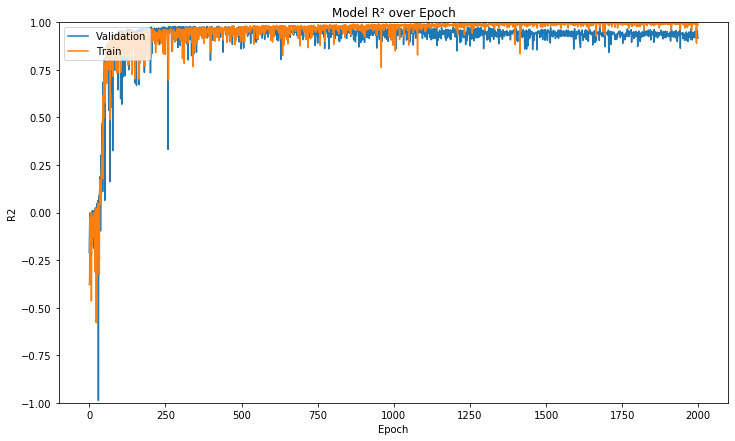

In [15]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history.history['val_coeff_determination'])
_ = ax.plot(history.history['coeff_determination'])
plt.ylim(-1, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left');

#### 3.3 Activation maps

In [68]:
def plot_activation_map(X, y, model, layer_name, instance_id, ynames, analyte, figsize=(15,6)):
    instance_id = instance_id
    input_ = tf.convert_to_tensor(normalize(X[instance_id].reshape(1,-1)))
    grad_model = Model(inputs=model.input, 
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, prediction = grad_model(input_)

    grads = tape.gradient(prediction, conv_output)[0]

    output = conv_output[0,:,:]
    guided_grads = tf.cast(conv_output[0,:,:] > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    weights = tf.reduce_mean(guided_grads, axis=0)

    cam = np.ones((output.shape[0]), dtype = np.float32)
    for i, w in enumerate(weights):
        cam += (w * output[:, i]).numpy()

    cam_resampled = resample(normalize(cam), X.shape[1]).reshape(-1,1)
    
    y_hats = model.predict(normalize(X)).ravel()
    y_trues = get_analyte(y, y_names, analyte)
   
    with plt.style.context(('ggplot')):
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        gs = fig.add_gridspec(2, 3)

        ax1 = fig.add_subplot(gs[:, :1])
        ax1.set_title('y vs. y_predicted')
        ax1.scatter(y_hats, y_trues, c='black', s=10, edgecolors=None)
        ax1.scatter(y_hats[instance_id], y_trues[instance_id], c='orangered', s=300, label='Prediction')
        ax1.legend()

        ax2 = fig.add_subplot(gs[0, 1:])
        ax2.set_xlim(4000, 600)
        ax2.plot(X_names, X[instance_id], color='steelblue')
        ax2.set_title('Spectrum')

        ax3 = fig.add_subplot(gs[1, 1:])
        ax3.set_xlim(4000, 600)
        ax3.set_ylim(0, 1.05)
        ax3.plot(X_names, cam_resampled, color='green')
        ax3.set_title('Model attention')

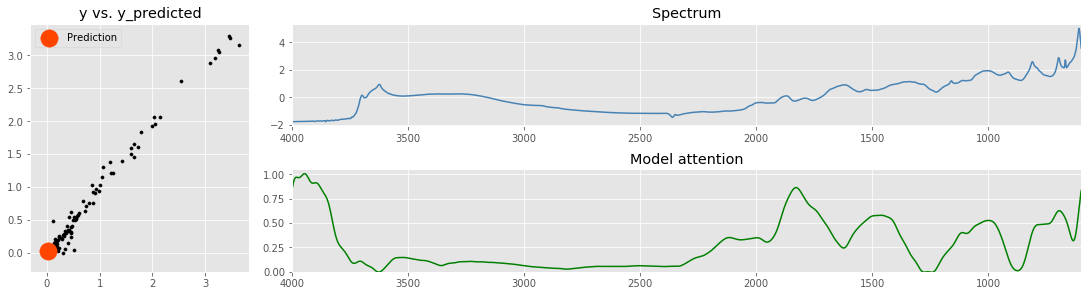

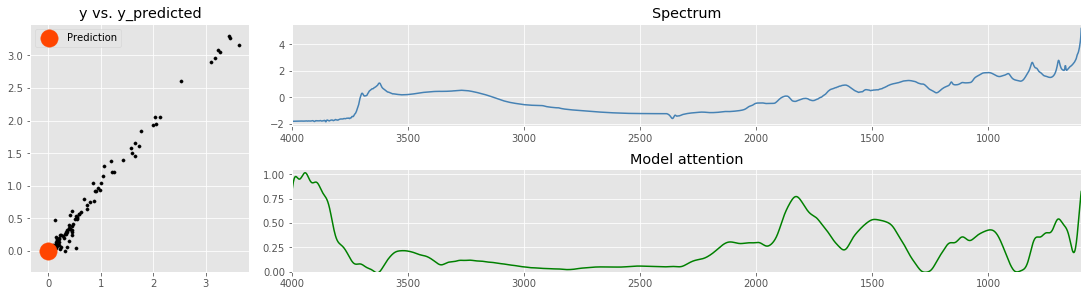

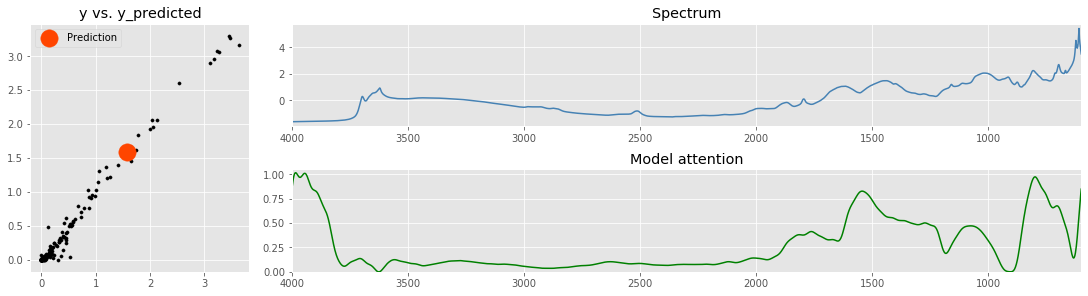

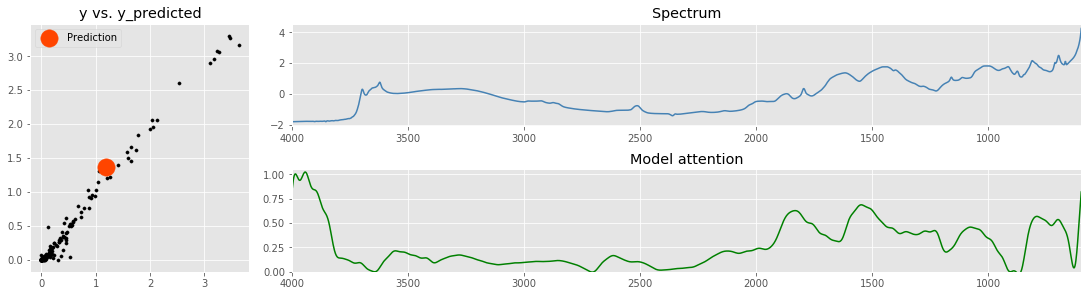

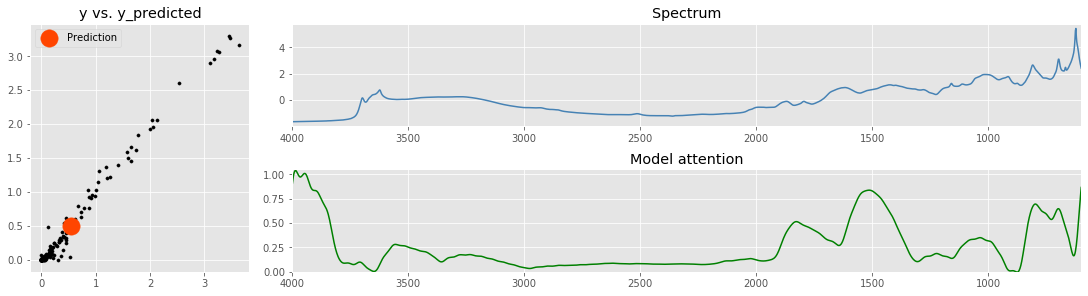

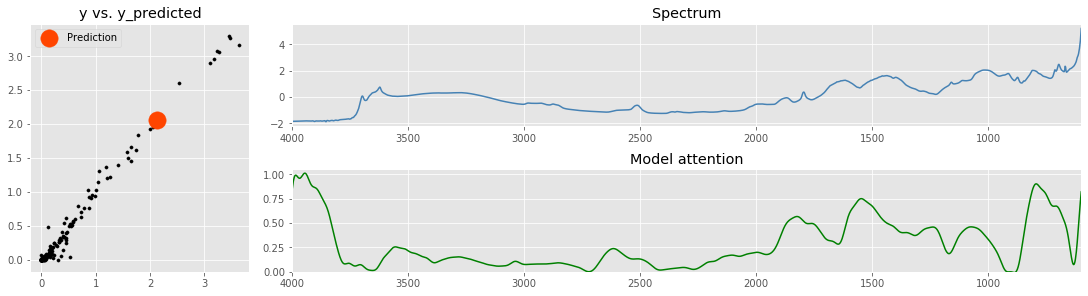

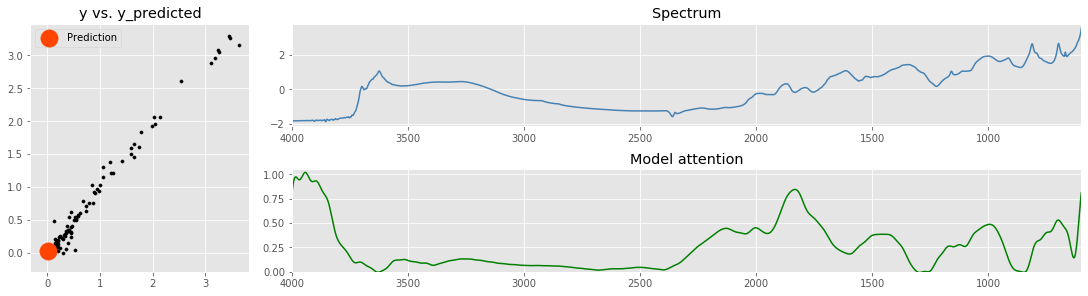

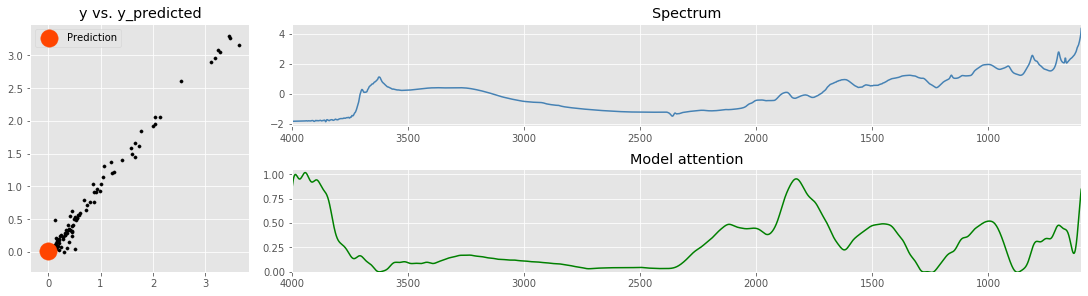

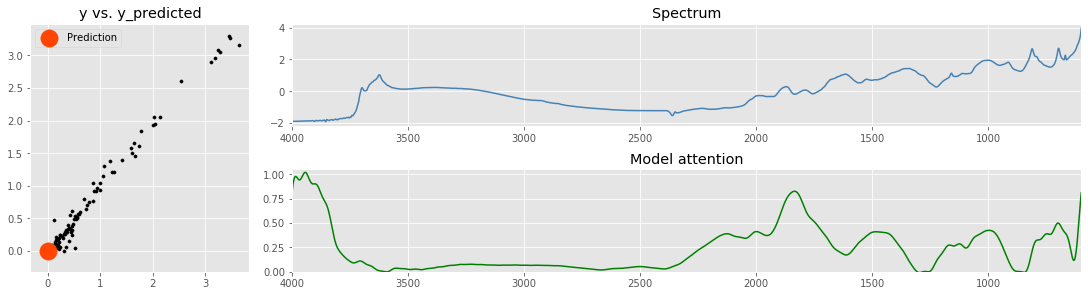

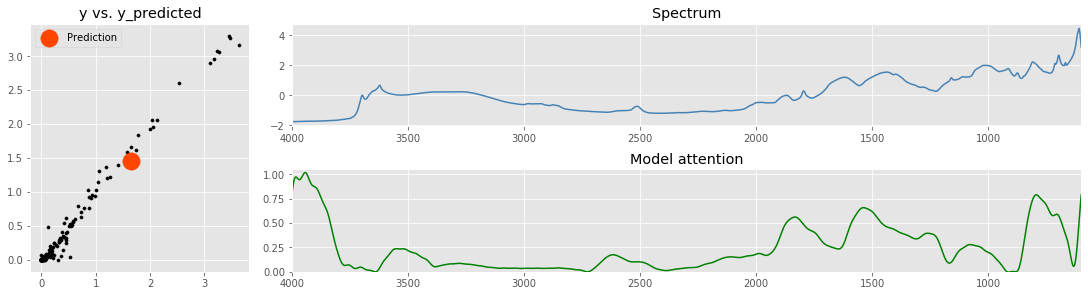

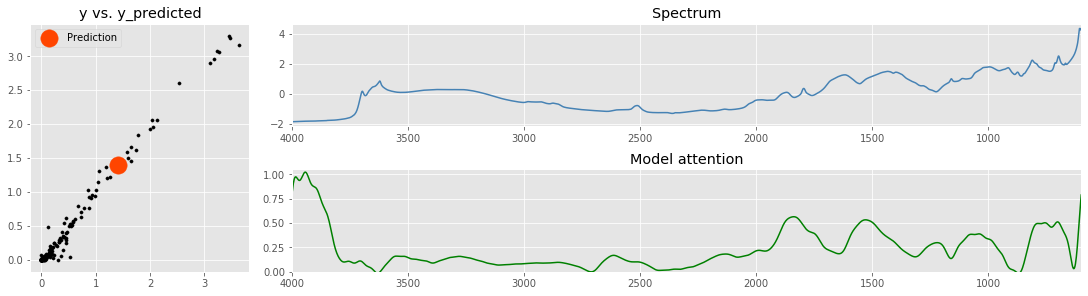

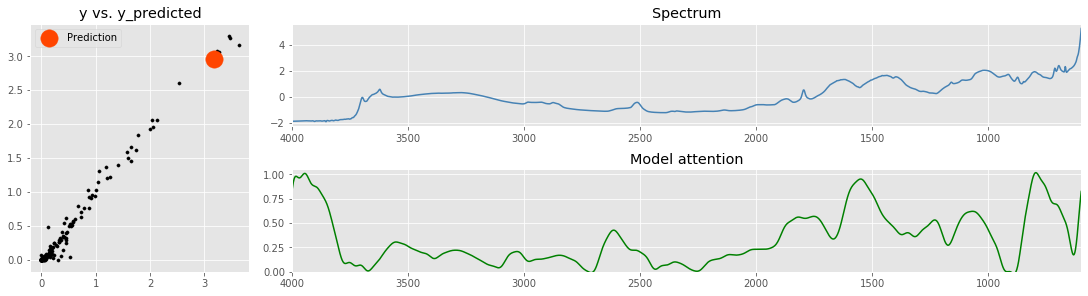

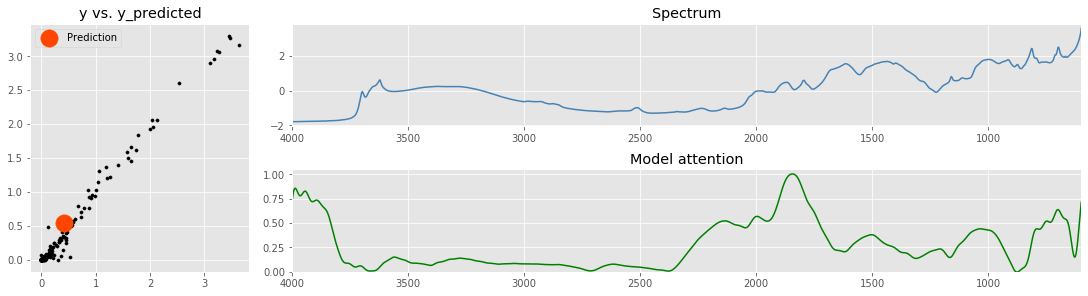

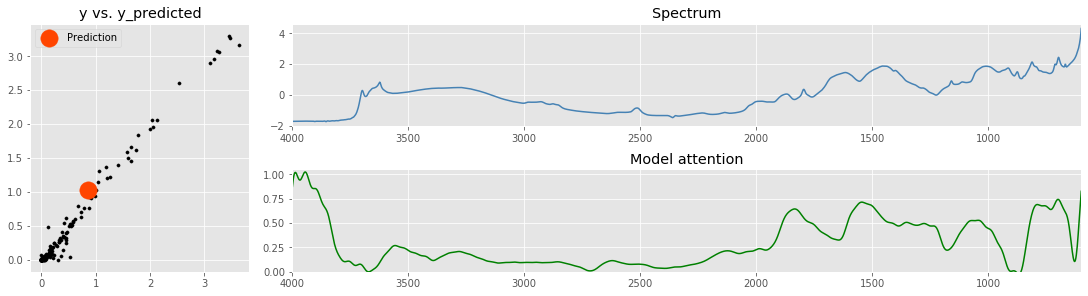

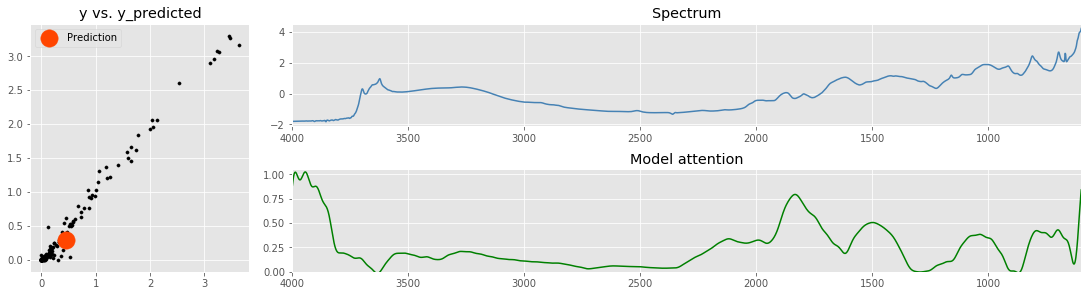

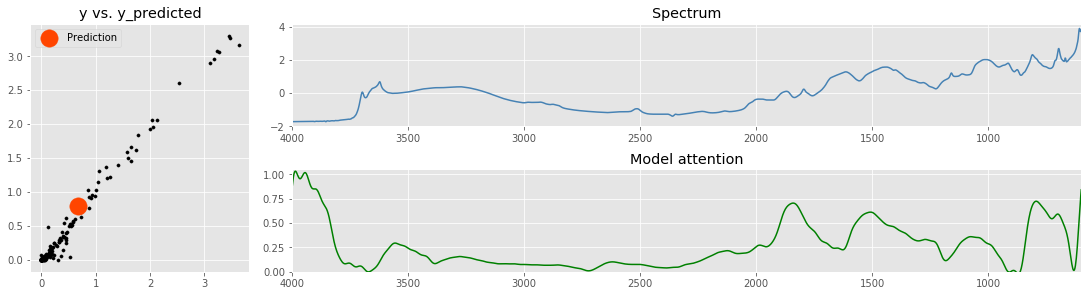

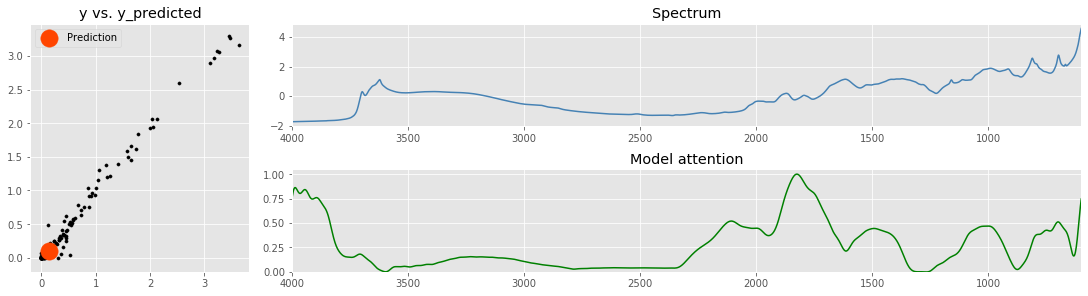

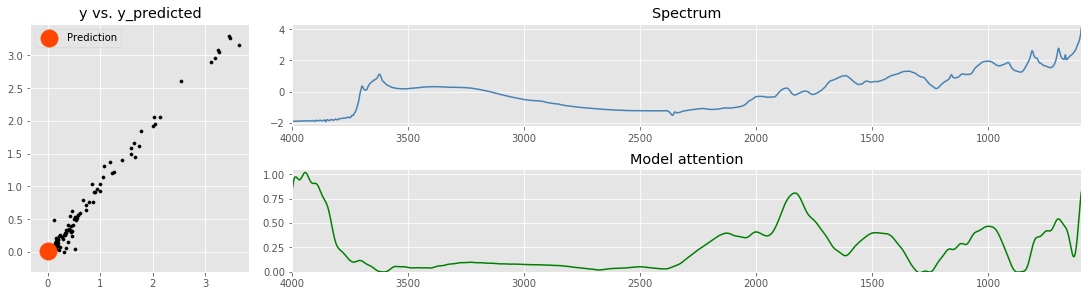

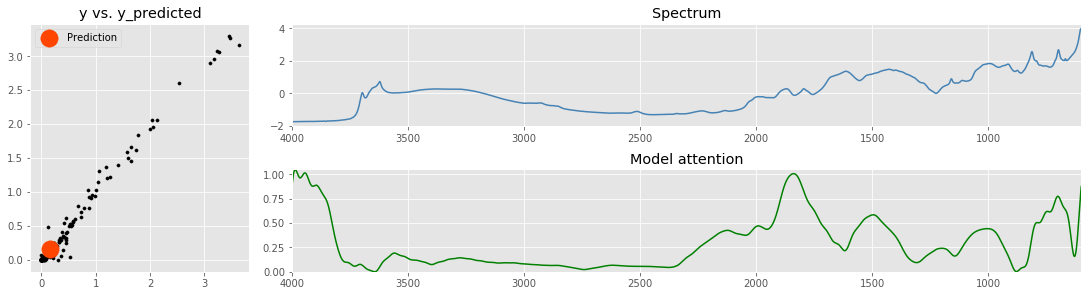

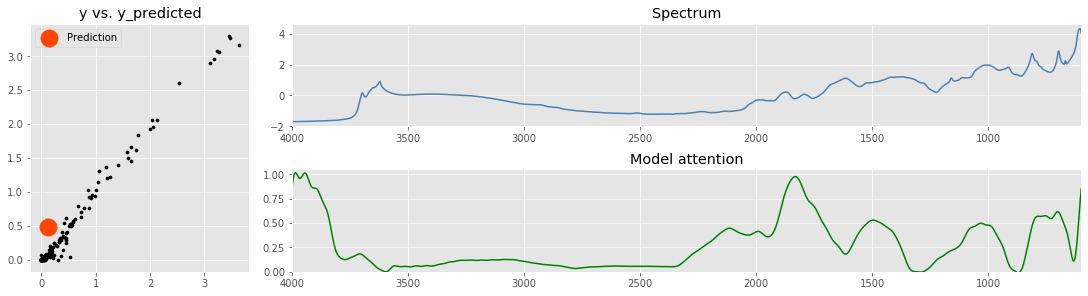

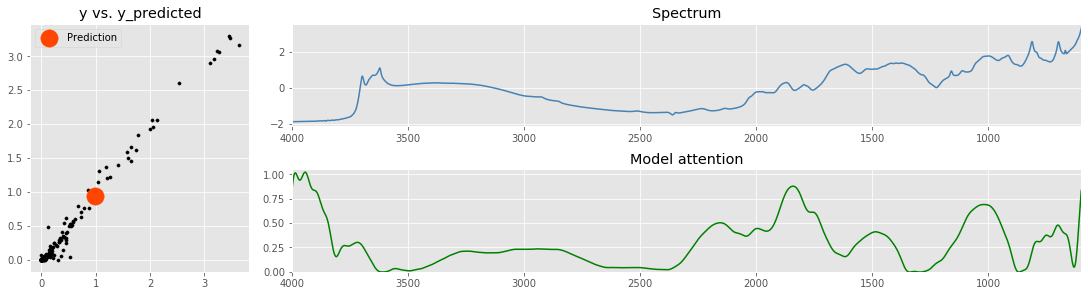

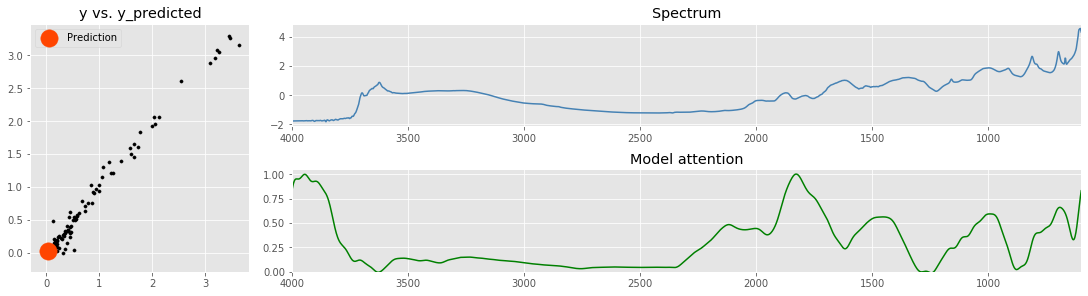

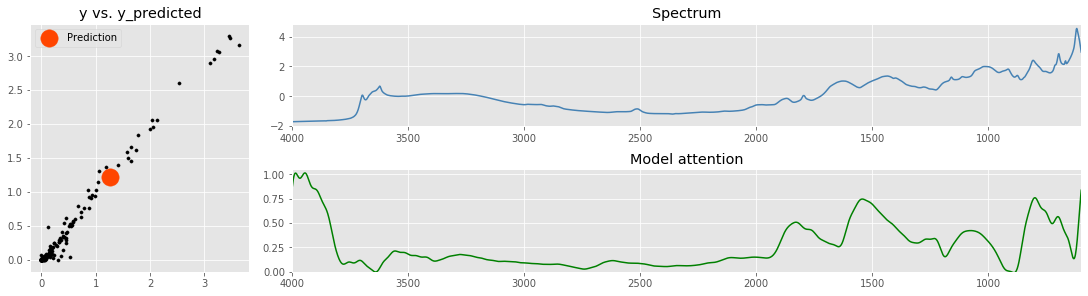

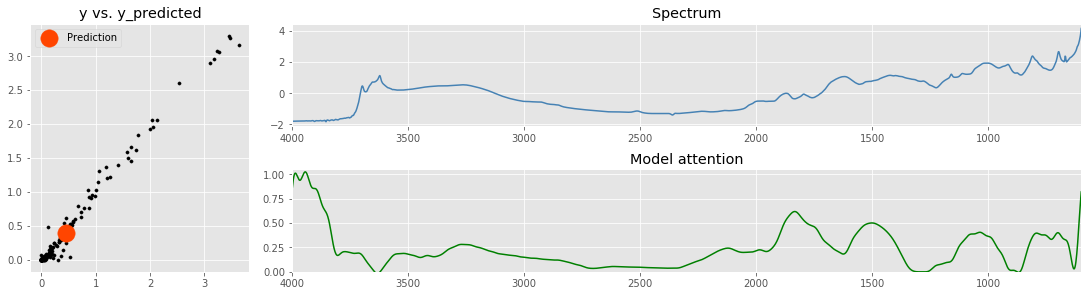

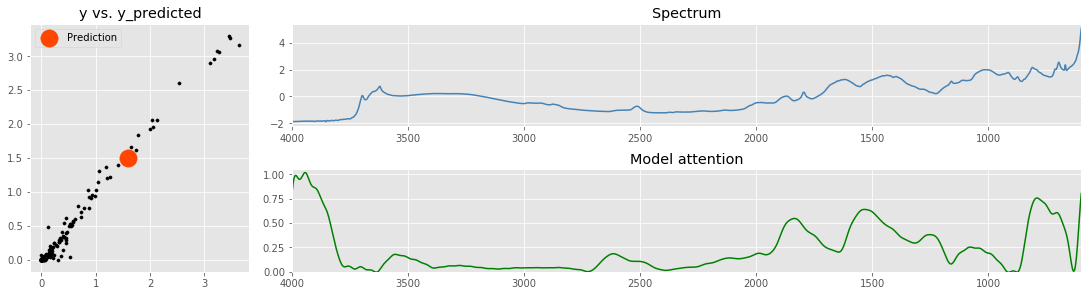

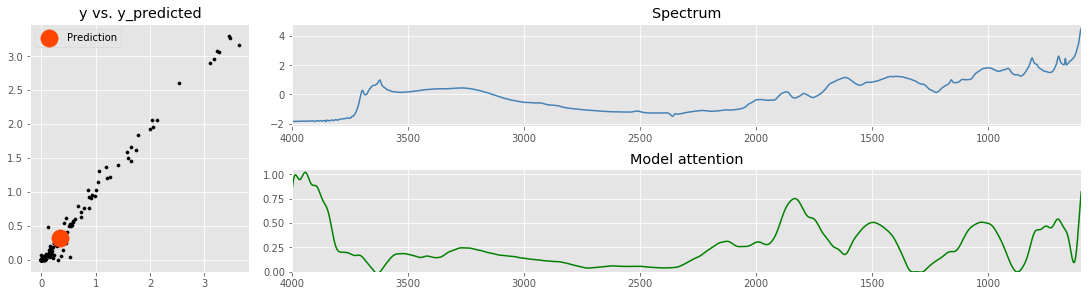

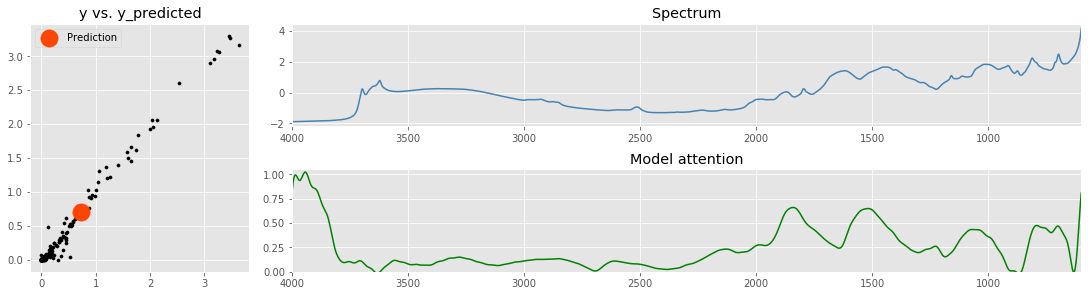

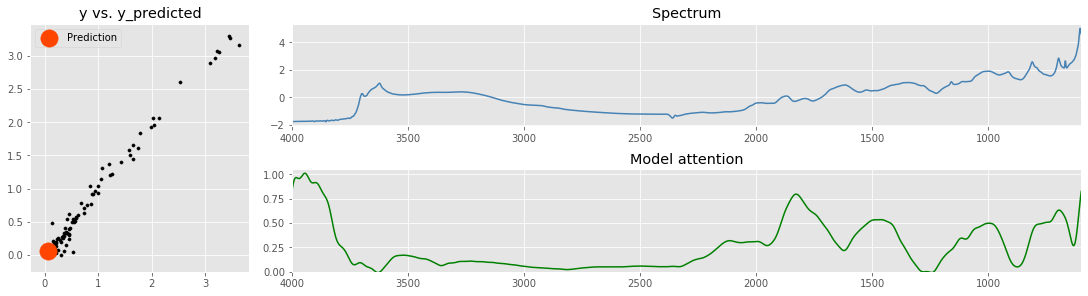

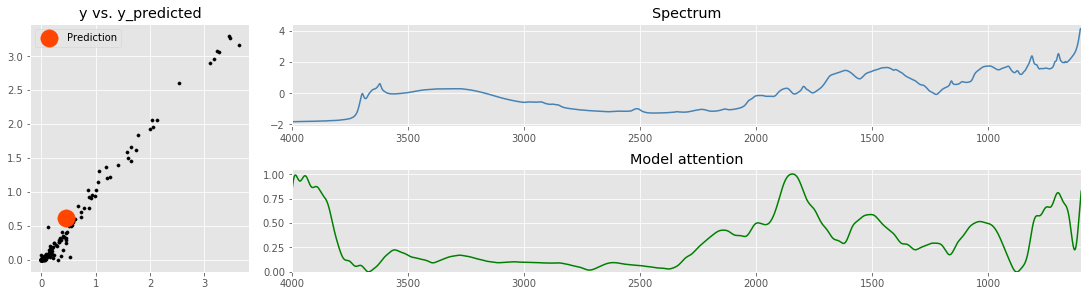

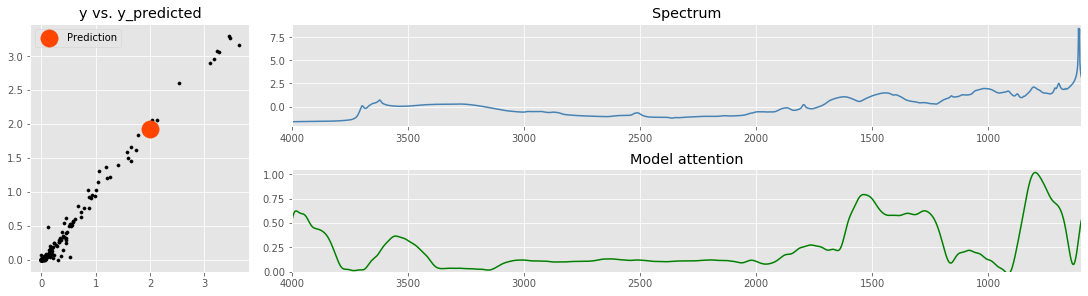

In [20]:
plt.rcParams.update({'figure.max_open_warning': 0})

for i in random.sample(range(X_train.shape[0]),30):
    plot_activation_map(X, y, model, 'conv1d_3', i, y_names, analyte, figsize=(15,4))

#### 3.4 Beating PLSR on K and CEC?

In [21]:
# Remove NaN values (specific to K and CEC)
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

activation = 'relu'
input_dim = X_not_nan.shape[1]

model_k = keras.models.Sequential()
model_k.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model_k.add(layers.Conv1D(32, 30, activation=activation))
model_k.add(layers.MaxPool1D(10))

model_k.add(layers.Conv1D(64, 30, activation=activation))
model_k.add(layers.MaxPool1D(10))

model_k.add(layers.Flatten())
model_k.add(layers.Dense(100, activation=activation))
model_k.add(layers.Dense(50, activation=activation))
model_k.add(layers.Dense(10, activation=activation))
model_k.add(layers.Dense(1,  activation='linear'))

model_k.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model_k.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1763, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1734, 32)          992       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 173, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_not_nan, y_not_nan, test_size=0.40, random_state=42)

analyte = 'K'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_valid_analyte = get_analyte(y_valid, y_names, analyte)

history_k = model_k.fit(normalize(X_train), y_train_analyte, epochs=2000, validation_data=(normalize(X_valid), y_valid_analyte))

Train on 68 samples, validate on 46 samples
Epoch 1/2000
68/68 [==============================] - 1s 15ms/sample - loss: 106.3900 - coeff_determination: -12.1266 - val_loss: 101.9105 - val_coeff_determination: -8.0447
Epoch 2/2000
68/68 [==============================] - 0s 2ms/sample - loss: 95.4319 - coeff_determination: -4.5451 - val_loss: 56.8992 - val_coeff_determination: -4.1168
Epoch 3/2000
68/68 [==============================] - 0s 2ms/sample - loss: 37.5819 - coeff_determination: -1.0561 - val_loss: 13.7527 - val_coeff_determination: -0.2603
Epoch 4/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.1903 - coeff_determination: -0.0842 - val_loss: 25.9058 - val_coeff_determination: -1.3780
Epoch 5/2000
68/68 [==============================] - 0s 2ms/sample - loss: 20.0737 - coeff_determination: -0.1696 - val_loss: 14.2708 - val_coeff_determination: -0.3115
Epoch 6/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.3264 - coeff_determinat

Epoch 49/2000
68/68 [==============================] - 0s 2ms/sample - loss: 18.3638 - coeff_determination: -0.1173 - val_loss: 14.6748 - val_coeff_determination: -0.3521
Epoch 50/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.4095 - coeff_determination: -0.0534 - val_loss: 16.2993 - val_coeff_determination: -0.5052
Epoch 51/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.2587 - coeff_determination: -0.0220 - val_loss: 14.5323 - val_coeff_determination: -0.3385
Epoch 52/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.8084 - coeff_determination: 0.0022 - val_loss: 14.4363 - val_coeff_determination: -0.3294
Epoch 53/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.7878 - coeff_determination: -0.3544 - val_loss: 27.7619 - val_coeff_determination: -1.5440
Epoch 54/2000
68/68 [==============================] - 0s 2ms/sample - loss: 22.6466 - coeff_determination: -0.4204 - val_loss: 18.6944 - val_coef

Epoch 97/2000
68/68 [==============================] - 0s 2ms/sample - loss: 17.7769 - coeff_determination: -0.1562 - val_loss: 12.1796 - val_coeff_determination: -0.0763
Epoch 98/2000
68/68 [==============================] - 0s 3ms/sample - loss: 16.5771 - coeff_determination: -0.2203 - val_loss: 11.9964 - val_coeff_determination: -0.0790
Epoch 99/2000
68/68 [==============================] - 0s 2ms/sample - loss: 17.4043 - coeff_determination: -0.4673 - val_loss: 19.2225 - val_coeff_determination: -0.7750
Epoch 100/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.3214 - coeff_determination: -0.0318 - val_loss: 12.4282 - val_coeff_determination: -0.1327
Epoch 101/2000
68/68 [==============================] - 0s 2ms/sample - loss: 17.0929 - coeff_determination: -0.3122 - val_loss: 17.9318 - val_coeff_determination: -0.5049
Epoch 102/2000
68/68 [==============================] - 0s 2ms/sample - loss: 21.3469 - coeff_determination: -0.1787 - val_loss: 14.8358 - val_

Epoch 145/2000
68/68 [==============================] - 0s 3ms/sample - loss: 20.4945 - coeff_determination: -0.2949 - val_loss: 11.4054 - val_coeff_determination: -0.0282
Epoch 146/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.5360 - coeff_determination: 0.0074 - val_loss: 15.2705 - val_coeff_determination: -0.4130
Epoch 147/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.4578 - coeff_determination: -1.2121 - val_loss: 30.8965 - val_coeff_determination: -1.8220
Epoch 148/2000
68/68 [==============================] - 0s 3ms/sample - loss: 20.5598 - coeff_determination: -0.1963 - val_loss: 11.8934 - val_coeff_determination: -0.0871
Epoch 149/2000
68/68 [==============================] - 0s 2ms/sample - loss: 14.7359 - coeff_determination: 0.0336 - val_loss: 19.7580 - val_coeff_determination: -0.8245
Epoch 150/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.4142 - coeff_determination: 0.0138 - val_loss: 11.2985 - val_

Epoch 193/2000
68/68 [==============================] - 0s 2ms/sample - loss: 13.7391 - coeff_determination: 0.0823 - val_loss: 11.1099 - val_coeff_determination: 0.0520
Epoch 194/2000
68/68 [==============================] - 0s 2ms/sample - loss: 25.1434 - coeff_determination: -4.7141 - val_loss: 24.6688 - val_coeff_determination: -1.2628
Epoch 195/2000
68/68 [==============================] - 0s 2ms/sample - loss: 16.4688 - coeff_determination: -0.0540 - val_loss: 16.9162 - val_coeff_determination: -0.5670
Epoch 196/2000
68/68 [==============================] - 0s 2ms/sample - loss: 13.8162 - coeff_determination: -0.2079 - val_loss: 25.6491 - val_coeff_determination: -1.3499
Epoch 197/2000
68/68 [==============================] - 0s 2ms/sample - loss: 15.9674 - coeff_determination: -0.0337 - val_loss: 9.2191 - val_coeff_determination: 0.1582
Epoch 198/2000
68/68 [==============================] - 0s 2ms/sample - loss: 12.8549 - coeff_determination: -0.4212 - val_loss: 13.2076 - val_c

Epoch 241/2000
68/68 [==============================] - 0s 2ms/sample - loss: 9.8493 - coeff_determination: 0.3862 - val_loss: 14.8910 - val_coeff_determination: -0.3745
Epoch 242/2000
68/68 [==============================] - 0s 2ms/sample - loss: 8.4366 - coeff_determination: 0.4679 - val_loss: 9.8664 - val_coeff_determination: 0.0788
Epoch 243/2000
68/68 [==============================] - 0s 2ms/sample - loss: 8.4920 - coeff_determination: 0.3847 - val_loss: 7.7599 - val_coeff_determination: 0.3426
Epoch 244/2000
68/68 [==============================] - 0s 2ms/sample - loss: 17.8530 - coeff_determination: 0.0077 - val_loss: 6.9381 - val_coeff_determination: 0.3519
Epoch 245/2000
68/68 [==============================] - 0s 2ms/sample - loss: 8.7352 - coeff_determination: 0.4966 - val_loss: 13.5159 - val_coeff_determination: -0.2491
Epoch 246/2000
68/68 [==============================] - 0s 2ms/sample - loss: 10.9407 - coeff_determination: -0.0553 - val_loss: 5.9765 - val_coeff_determi

68/68 [==============================] - 0s 3ms/sample - loss: 7.6592 - coeff_determination: 0.5021 - val_loss: 4.4437 - val_coeff_determination: 0.6127
Epoch 338/2000
68/68 [==============================] - 0s 2ms/sample - loss: 6.8962 - coeff_determination: 0.5240 - val_loss: 5.4354 - val_coeff_determination: 0.4952
Epoch 339/2000
68/68 [==============================] - 0s 2ms/sample - loss: 5.6529 - coeff_determination: 0.5496 - val_loss: 6.2358 - val_coeff_determination: 0.4197
Epoch 340/2000
68/68 [==============================] - 0s 2ms/sample - loss: 6.4893 - coeff_determination: -0.1860 - val_loss: 10.7314 - val_coeff_determination: 0.0106
Epoch 341/2000
68/68 [==============================] - 0s 2ms/sample - loss: 5.5819 - coeff_determination: 0.7052 - val_loss: 6.6605 - val_coeff_determination: 0.3821
Epoch 342/2000
68/68 [==============================] - 0s 2ms/sample - loss: 5.6787 - coeff_determination: 0.6519 - val_loss: 12.1915 - val_coeff_determination: -0.1183
Epo

68/68 [==============================] - 0s 2ms/sample - loss: 6.0712 - coeff_determination: 0.6085 - val_loss: 9.5318 - val_coeff_determination: 0.1291
Epoch 434/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.3768 - coeff_determination: 0.6557 - val_loss: 11.1979 - val_coeff_determination: -0.0210
Epoch 435/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.8103 - coeff_determination: 0.3708 - val_loss: 18.4170 - val_coeff_determination: -0.6646
Epoch 436/2000
68/68 [==============================] - 0s 2ms/sample - loss: 7.4144 - coeff_determination: 0.3525 - val_loss: 6.9150 - val_coeff_determination: 0.3623
Epoch 437/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.5296 - coeff_determination: -0.7496 - val_loss: 15.8856 - val_coeff_determination: -0.4439
Epoch 438/2000
68/68 [==============================] - 0s 2ms/sample - loss: 7.2922 - coeff_determination: 0.6368 - val_loss: 12.6754 - val_coeff_determination: -0.156

Epoch 530/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.0910 - coeff_determination: 0.7439 - val_loss: 7.1695 - val_coeff_determination: 0.3475
Epoch 531/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.3180 - coeff_determination: -1.3224 - val_loss: 25.1061 - val_coeff_determination: -1.2431
Epoch 532/2000
68/68 [==============================] - 0s 2ms/sample - loss: 10.4569 - coeff_determination: 0.2486 - val_loss: 4.7393 - val_coeff_determination: 0.5650
Epoch 533/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.6937 - coeff_determination: 0.6236 - val_loss: 6.4233 - val_coeff_determination: 0.4119
Epoch 534/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.5848 - coeff_determination: 0.7993 - val_loss: 8.2939 - val_coeff_determination: 0.2453
Epoch 535/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.5842 - coeff_determination: 0.3808 - val_loss: 19.2693 - val_coeff_determina

Epoch 627/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.1779 - coeff_determination: 0.7459 - val_loss: 17.5885 - val_coeff_determination: -0.5752
Epoch 628/2000
68/68 [==============================] - 0s 2ms/sample - loss: 6.2670 - coeff_determination: 0.6655 - val_loss: 2.6357 - val_coeff_determination: 0.7622
Epoch 629/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.9767 - coeff_determination: 0.6577 - val_loss: 3.1815 - val_coeff_determination: 0.7108
Epoch 630/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.4624 - coeff_determination: 0.7508 - val_loss: 8.4995 - val_coeff_determination: 0.2343
Epoch 631/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.0068 - coeff_determination: 0.6435 - val_loss: 9.9556 - val_coeff_determination: 0.1031
Epoch 632/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.9452 - coeff_determination: 0.7960 - val_loss: 2.2136 - val_coeff_determinatio

Epoch 724/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.6393 - coeff_determination: 0.7361 - val_loss: 16.3396 - val_coeff_determination: -0.4596
Epoch 725/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.2830 - coeff_determination: 0.6971 - val_loss: 2.3880 - val_coeff_determination: 0.7889
Epoch 726/2000
68/68 [==============================] - 0s 2ms/sample - loss: 6.2607 - coeff_determination: 0.6952 - val_loss: 7.4266 - val_coeff_determination: 0.3312
Epoch 727/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.8823 - coeff_determination: 0.8315 - val_loss: 3.2607 - val_coeff_determination: 0.7027
Epoch 728/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.0309 - coeff_determination: 0.8009 - val_loss: 6.0139 - val_coeff_determination: 0.4575
Epoch 729/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.7113 - coeff_determination: 0.7321 - val_loss: 3.6999 - val_coeff_determinatio

Epoch 773/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.5702 - coeff_determination: 0.8538 - val_loss: 5.1069 - val_coeff_determination: 0.5375
Epoch 774/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.4502 - coeff_determination: 0.7673 - val_loss: 4.1109 - val_coeff_determination: 0.6275
Epoch 775/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.5018 - coeff_determination: 0.8741 - val_loss: 5.3576 - val_coeff_determination: 0.5157
Epoch 776/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.5047 - coeff_determination: 0.7645 - val_loss: 2.6718 - val_coeff_determination: 0.7601
Epoch 777/2000
68/68 [==============================] - 0s 2ms/sample - loss: 7.4682 - coeff_determination: 0.6456 - val_loss: 5.3846 - val_coeff_determination: 0.5120
Epoch 778/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.5711 - coeff_determination: 0.2696 - val_loss: 17.3429 - val_coeff_determination

Epoch 870/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.4755 - coeff_determination: 0.4617 - val_loss: 8.9121 - val_coeff_determination: 0.2019
Epoch 871/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.8007 - coeff_determination: 0.7646 - val_loss: 2.8626 - val_coeff_determination: 0.7472
Epoch 872/2000
68/68 [==============================] - 0s 2ms/sample - loss: 8.6680 - coeff_determination: 0.5109 - val_loss: 3.2957 - val_coeff_determination: 0.6999
Epoch 873/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.6499 - coeff_determination: 0.7139 - val_loss: 2.9387 - val_coeff_determination: 0.7319
Epoch 874/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.8980 - coeff_determination: 0.7953 - val_loss: 5.5859 - val_coeff_determination: 0.4971
Epoch 875/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.0873 - coeff_determination: 0.7814 - val_loss: 10.7923 - val_coeff_determination

Epoch 919/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.0817 - coeff_determination: 0.7591 - val_loss: 12.7796 - val_coeff_determination: -0.1382
Epoch 920/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.5626 - coeff_determination: 0.7239 - val_loss: 2.5036 - val_coeff_determination: 0.7738
Epoch 921/2000
68/68 [==============================] - 0s 2ms/sample - loss: 6.7981 - coeff_determination: 0.5481 - val_loss: 2.2189 - val_coeff_determination: 0.7975
Epoch 922/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.7139 - coeff_determination: 0.7457 - val_loss: 3.1257 - val_coeff_determination: 0.7147
Epoch 923/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.3230 - coeff_determination: 0.6018 - val_loss: 14.4598 - val_coeff_determination: -0.2853
Epoch 924/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.3398 - coeff_determination: 0.7856 - val_loss: 7.4650 - val_coeff_determinat

Epoch 968/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.1467 - coeff_determination: 0.8304 - val_loss: 3.1104 - val_coeff_determination: 0.7153
Epoch 969/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.8178 - coeff_determination: 0.7767 - val_loss: 6.2768 - val_coeff_determination: 0.4384
Epoch 970/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.0828 - coeff_determination: 0.8840 - val_loss: 7.9388 - val_coeff_determination: 0.2933
Epoch 971/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.3533 - coeff_determination: 0.8586 - val_loss: 8.3422 - val_coeff_determination: 0.2561
Epoch 972/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.1025 - coeff_determination: 0.8237 - val_loss: 5.2358 - val_coeff_determination: 0.5300
Epoch 973/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.4118 - coeff_determination: 0.7962 - val_loss: 2.6615 - val_coeff_determination:

68/68 [==============================] - 0s 2ms/sample - loss: 1.7909 - coeff_determination: 0.8838 - val_loss: 3.0221 - val_coeff_determination: 0.7269
Epoch 1065/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.4463 - coeff_determination: 0.5858 - val_loss: 10.6175 - val_coeff_determination: 0.0548
Epoch 1066/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.9876 - coeff_determination: 0.8266 - val_loss: 4.4466 - val_coeff_determination: 0.6047
Epoch 1067/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.9238 - coeff_determination: 0.3409 - val_loss: 13.1957 - val_coeff_determination: -0.1752
Epoch 1068/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.9870 - coeff_determination: 0.8287 - val_loss: 2.5348 - val_coeff_determination: 0.7764
Epoch 1069/2000
68/68 [==============================] - 0s 2ms/sample - loss: 7.4972 - coeff_determination: 0.6435 - val_loss: 8.6115 - val_coeff_determination: 0.2343

68/68 [==============================] - 0s 2ms/sample - loss: 1.8770 - coeff_determination: 0.9051 - val_loss: 8.9896 - val_coeff_determination: 0.2009
Epoch 1161/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.2911 - coeff_determination: 0.8415 - val_loss: 2.9485 - val_coeff_determination: 0.7353
Epoch 1162/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.3377 - coeff_determination: 0.6904 - val_loss: 13.7710 - val_coeff_determination: -0.2170
Epoch 1163/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.8096 - coeff_determination: 0.7501 - val_loss: 5.9028 - val_coeff_determination: 0.4701
Epoch 1164/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.7921 - coeff_determination: 0.8196 - val_loss: 4.9222 - val_coeff_determination: 0.5571
Epoch 1165/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.6443 - coeff_determination: 0.8874 - val_loss: 8.9254 - val_coeff_determination: 0.2054


68/68 [==============================] - 0s 2ms/sample - loss: 2.2273 - coeff_determination: 0.2032 - val_loss: 2.3016 - val_coeff_determination: 0.7991
Epoch 1257/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.2177 - coeff_determination: -0.0343 - val_loss: 10.3460 - val_coeff_determination: 0.0828
Epoch 1258/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.1887 - coeff_determination: 0.7345 - val_loss: 8.6685 - val_coeff_determination: 0.2384
Epoch 1259/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.4266 - coeff_determination: 0.5264 - val_loss: 16.6361 - val_coeff_determination: -0.4612
Epoch 1260/2000
68/68 [==============================] - 0s 2ms/sample - loss: 5.3864 - coeff_determination: 0.7822 - val_loss: 7.1431 - val_coeff_determination: 0.3690
Epoch 1261/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.8862 - coeff_determination: 0.9103 - val_loss: 5.6578 - val_coeff_determination: 0.500

68/68 [==============================] - 0s 2ms/sample - loss: 1.5042 - coeff_determination: 0.8235 - val_loss: 1.7146 - val_coeff_determination: 0.8434
Epoch 1353/2000
68/68 [==============================] - 0s 2ms/sample - loss: 4.5377 - coeff_determination: 0.7656 - val_loss: 5.5083 - val_coeff_determination: 0.5127
Epoch 1354/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.6492 - coeff_determination: 0.9202 - val_loss: 3.9716 - val_coeff_determination: 0.6478
Epoch 1355/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.4031 - coeff_determination: 0.9282 - val_loss: 3.5908 - val_coeff_determination: 0.6805
Epoch 1356/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.2896 - coeff_determination: 0.8797 - val_loss: 5.8842 - val_coeff_determination: 0.4784
Epoch 1357/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.3720 - coeff_determination: 0.9220 - val_loss: 4.6182 - val_coeff_determination: 0.5881
Ep

68/68 [==============================] - 0s 2ms/sample - loss: 2.0406 - coeff_determination: 0.9054 - val_loss: 4.6358 - val_coeff_determination: 0.5932
Epoch 1449/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.2364 - coeff_determination: 0.8430 - val_loss: 7.4713 - val_coeff_determination: 0.3381
Epoch 1450/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.9285 - coeff_determination: 0.7286 - val_loss: 4.1783 - val_coeff_determination: 0.6326
Epoch 1451/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.6691 - coeff_determination: 0.8287 - val_loss: 10.4462 - val_coeff_determination: 0.0849
Epoch 1452/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.0787 - coeff_determination: 0.8428 - val_loss: 3.8742 - val_coeff_determination: 0.6588
Epoch 1453/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.2617 - coeff_determination: 0.9140 - val_loss: 2.5257 - val_coeff_determination: 0.7733
E

68/68 [==============================] - 0s 2ms/sample - loss: 1.1186 - coeff_determination: 0.8630 - val_loss: 8.2045 - val_coeff_determination: 0.2796
Epoch 1545/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.2225 - coeff_determination: 0.8665 - val_loss: 4.2952 - val_coeff_determination: 0.6181
Epoch 1546/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.1864 - coeff_determination: 0.8878 - val_loss: 1.6350 - val_coeff_determination: 0.8494
Epoch 1547/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.8253 - coeff_determination: 0.7326 - val_loss: 3.0732 - val_coeff_determination: 0.7266
Epoch 1548/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.2321 - coeff_determination: 0.8982 - val_loss: 2.1128 - val_coeff_determination: 0.8104
Epoch 1549/2000
68/68 [==============================] - 0s 2ms/sample - loss: 3.3708 - coeff_determination: 0.8381 - val_loss: 2.9452 - val_coeff_determination: 0.7403
Ep

68/68 [==============================] - 0s 2ms/sample - loss: 2.4816 - coeff_determination: 0.8300 - val_loss: 6.8918 - val_coeff_determination: 0.3917
Epoch 1641/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.3816 - coeff_determination: 0.8528 - val_loss: 1.9971 - val_coeff_determination: 0.8234
Epoch 1642/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.9790 - coeff_determination: 0.8985 - val_loss: 7.5176 - val_coeff_determination: 0.3377
Epoch 1643/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.3994 - coeff_determination: 0.9023 - val_loss: 2.7264 - val_coeff_determination: 0.7606
Epoch 1644/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.0011 - coeff_determination: 0.9396 - val_loss: 3.1705 - val_coeff_determination: 0.7191
Epoch 1645/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.7553 - coeff_determination: 0.8955 - val_loss: 3.1103 - val_coeff_determination: 0.7292
Ep

68/68 [==============================] - 0s 2ms/sample - loss: 1.6558 - coeff_determination: 0.8296 - val_loss: 5.5605 - val_coeff_determination: 0.5086
Epoch 1737/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.4503 - coeff_determination: 0.8826 - val_loss: 6.9991 - val_coeff_determination: 0.3875
Epoch 1738/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.0476 - coeff_determination: 0.7463 - val_loss: 8.7857 - val_coeff_determination: 0.2321
Epoch 1739/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.7510 - coeff_determination: 0.8695 - val_loss: 5.0977 - val_coeff_determination: 0.5552
Epoch 1740/2000
68/68 [==============================] - 0s 2ms/sample - loss: 0.9514 - coeff_determination: 0.9364 - val_loss: 5.3787 - val_coeff_determination: 0.5316
Epoch 1741/2000
68/68 [==============================] - 0s 2ms/sample - loss: 0.9914 - coeff_determination: 0.9022 - val_loss: 3.6344 - val_coeff_determination: 0.6784
Ep

68/68 [==============================] - 0s 2ms/sample - loss: 1.1429 - coeff_determination: 0.8773 - val_loss: 2.1977 - val_coeff_determination: 0.8025
Epoch 1833/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.7031 - coeff_determination: 0.9006 - val_loss: 5.5379 - val_coeff_determination: 0.5148
Epoch 1834/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.4439 - coeff_determination: 0.8986 - val_loss: 4.3856 - val_coeff_determination: 0.6168
Epoch 1835/2000
68/68 [==============================] - 0s 2ms/sample - loss: 0.9508 - coeff_determination: 0.8724 - val_loss: 11.3099 - val_coeff_determination: -0.0083
Epoch 1836/2000
68/68 [==============================] - 0s 2ms/sample - loss: 2.9370 - coeff_determination: 0.8614 - val_loss: 3.9294 - val_coeff_determination: 0.6541
Epoch 1837/2000
68/68 [==============================] - 0s 2ms/sample - loss: 0.9638 - coeff_determination: 0.9453 - val_loss: 4.8073 - val_coeff_determination: 0.5781


68/68 [==============================] - 0s 2ms/sample - loss: 1.3925 - coeff_determination: 0.8575 - val_loss: 3.3131 - val_coeff_determination: 0.7085
Epoch 1929/2000
68/68 [==============================] - 0s 2ms/sample - loss: 0.9510 - coeff_determination: 0.8506 - val_loss: 2.0494 - val_coeff_determination: 0.8180
Epoch 1930/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.2445 - coeff_determination: 0.9069 - val_loss: 4.7007 - val_coeff_determination: 0.5875
Epoch 1931/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.0985 - coeff_determination: 0.9353 - val_loss: 3.3094 - val_coeff_determination: 0.7070
Epoch 1932/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.0772 - coeff_determination: 0.9159 - val_loss: 5.3247 - val_coeff_determination: 0.5296
Epoch 1933/2000
68/68 [==============================] - 0s 2ms/sample - loss: 1.0932 - coeff_determination: 0.9093 - val_loss: 1.9174 - val_coeff_determination: 0.8230
Ep

In [24]:
# Saving model
MODEL_PATH = os.path.join('..', 'models', 'basic-cnn-k.h5')
model_k.save(MODEL_PATH)

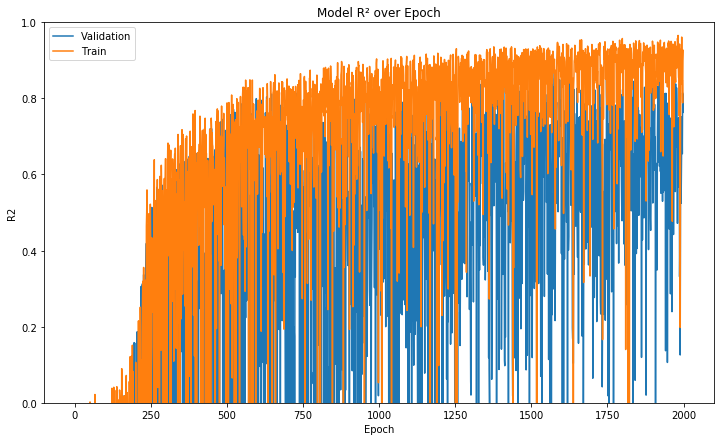

In [25]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history_k.history['val_coeff_determination'])
_ = ax.plot(history_k.history['coeff_determination'])
plt.ylim(0, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

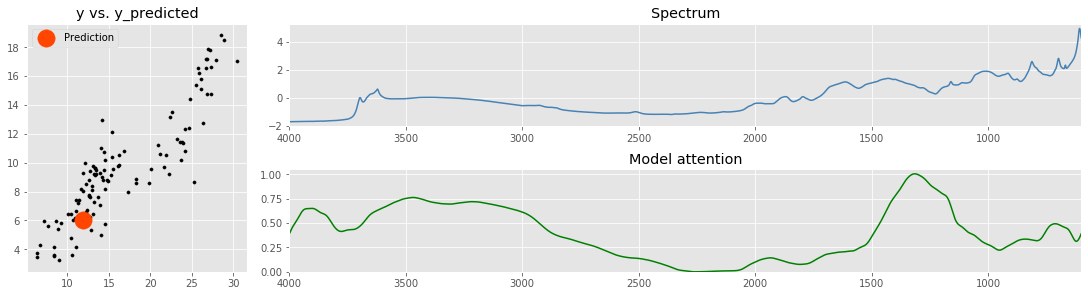

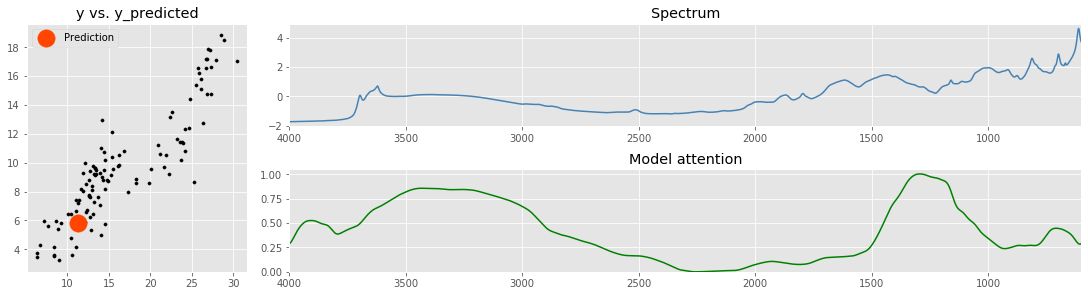

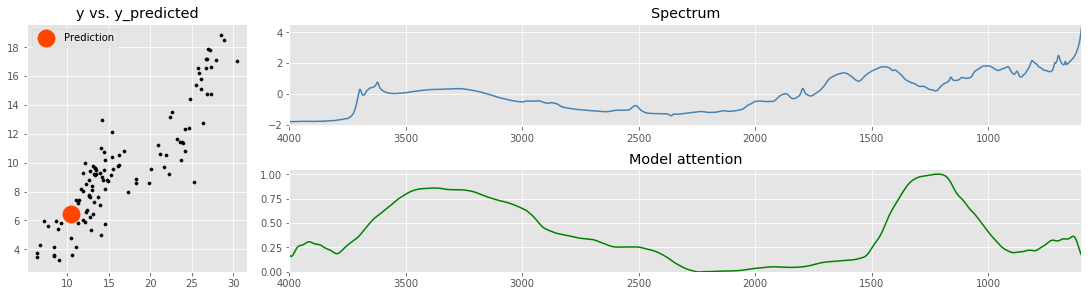

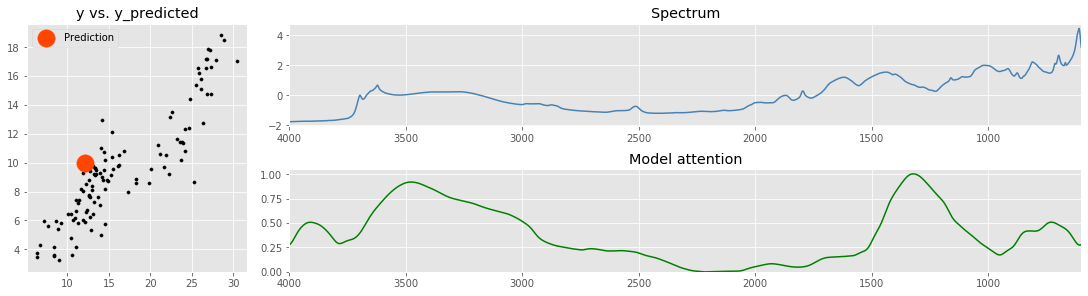

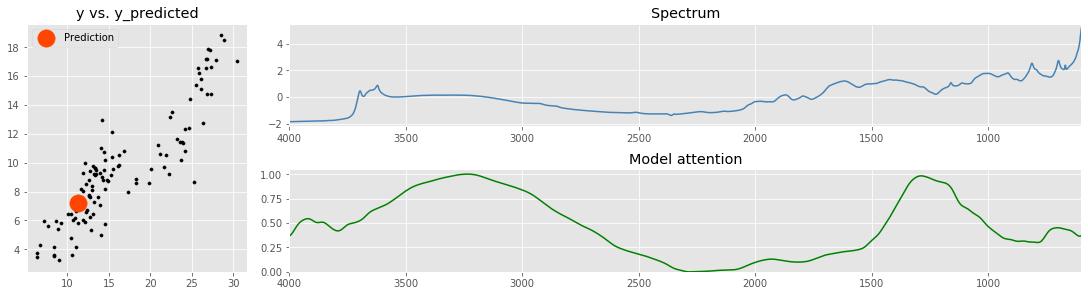

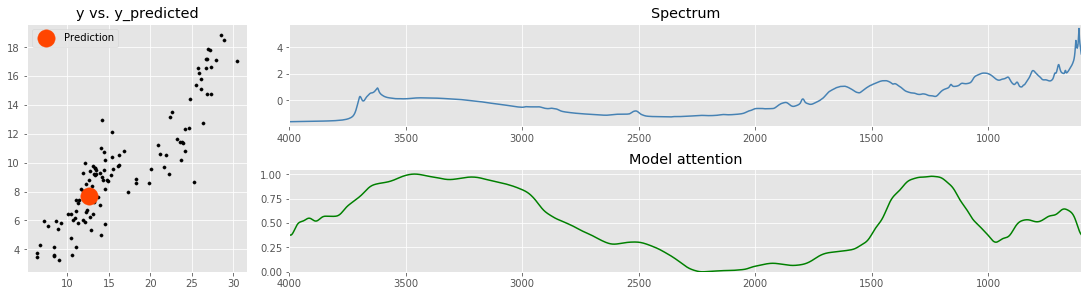

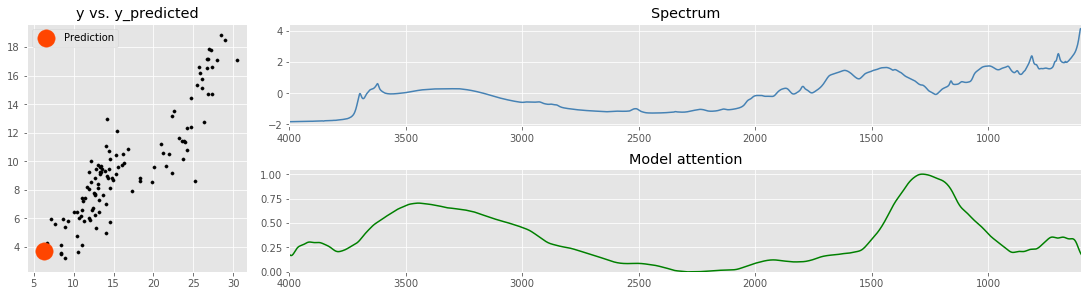

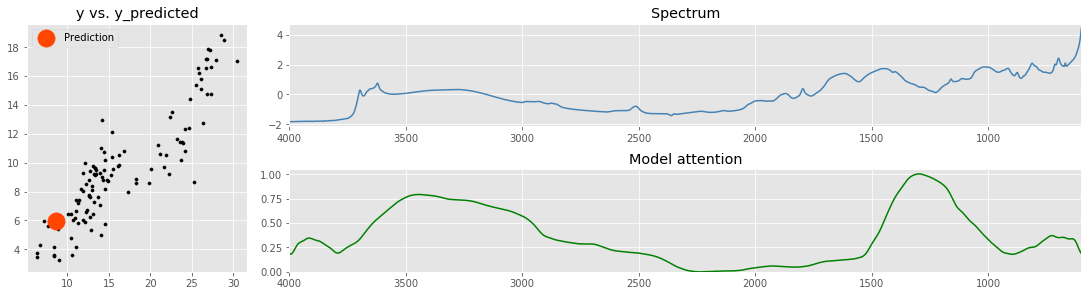

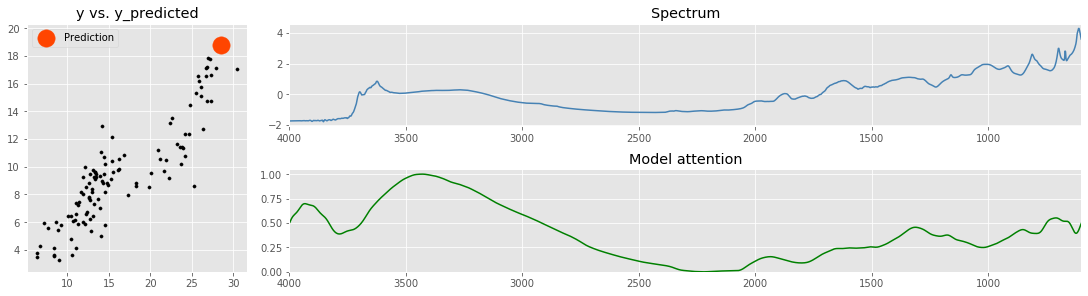

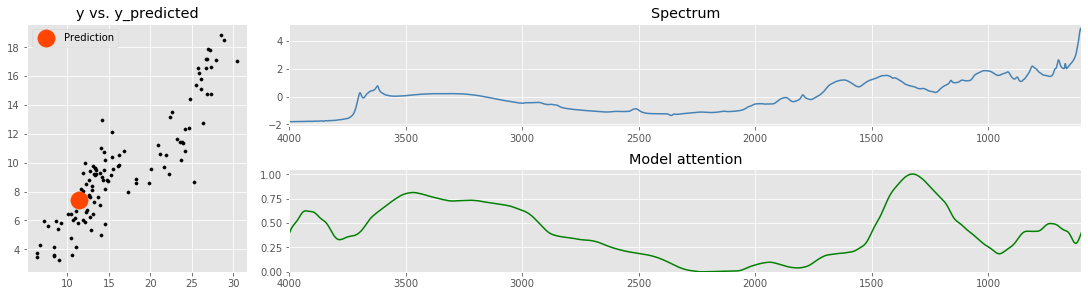

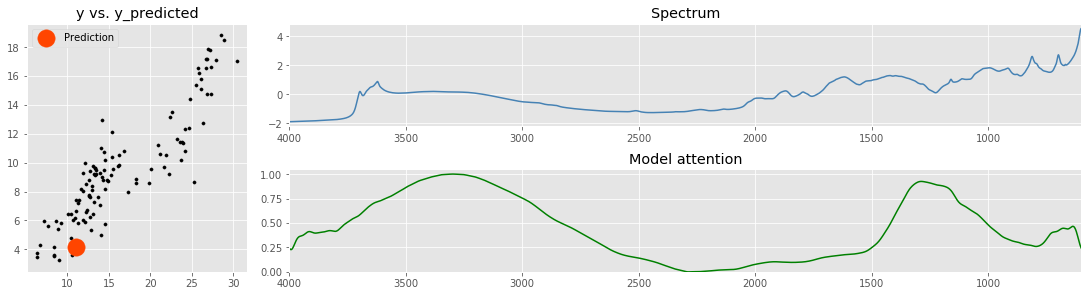

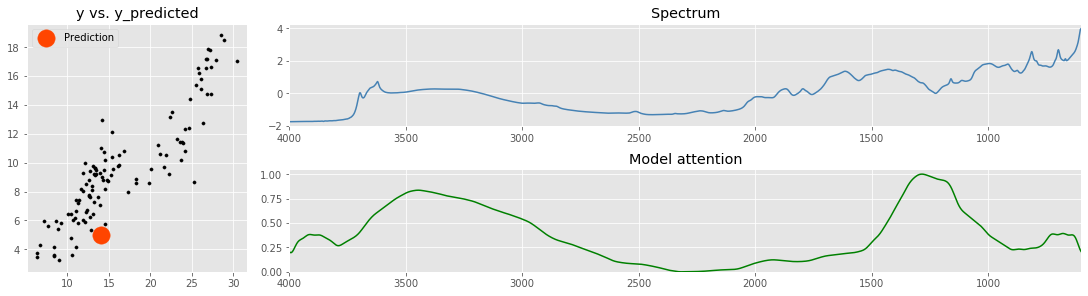

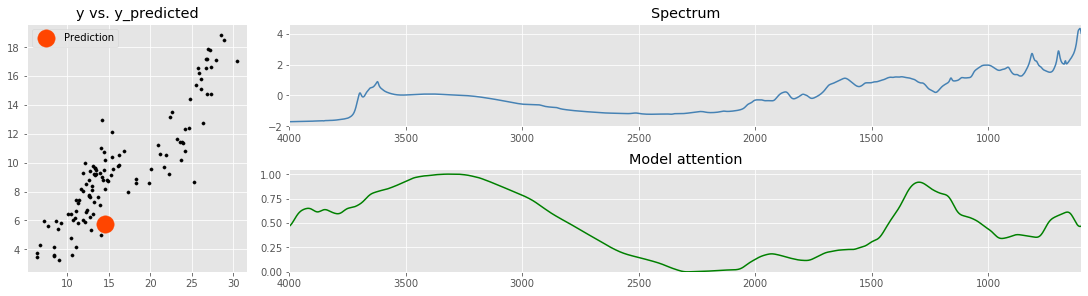

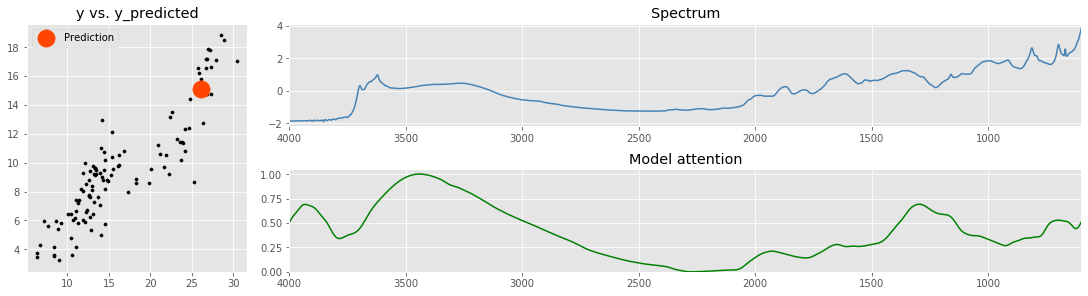

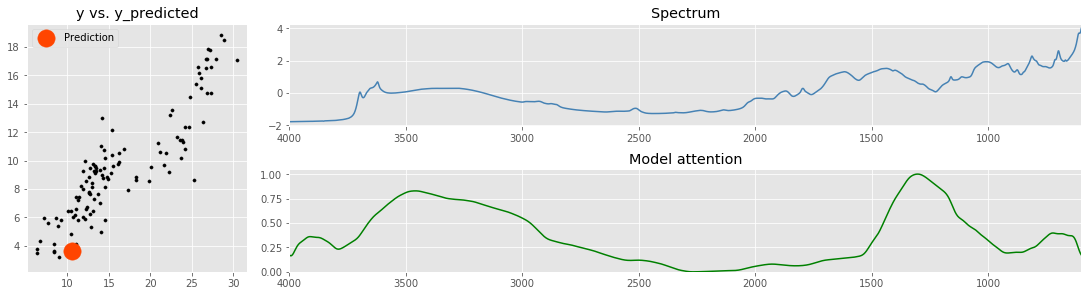

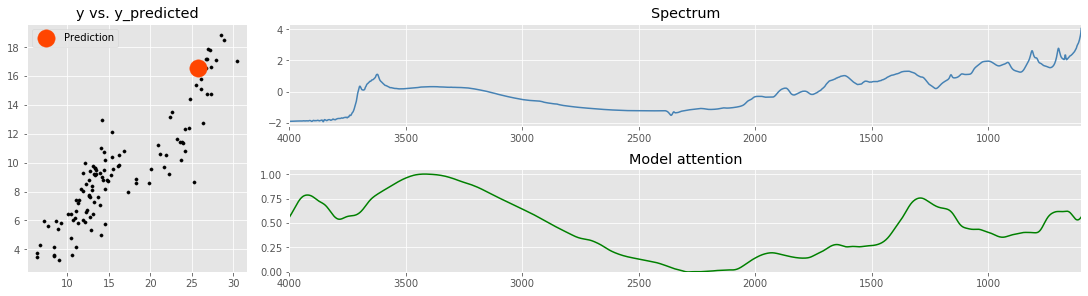

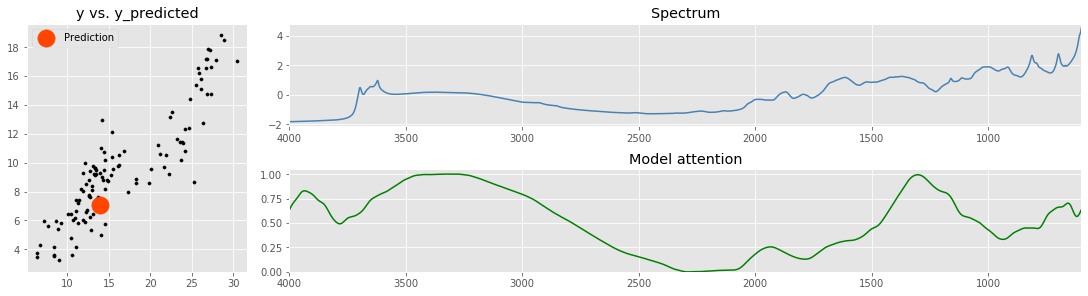

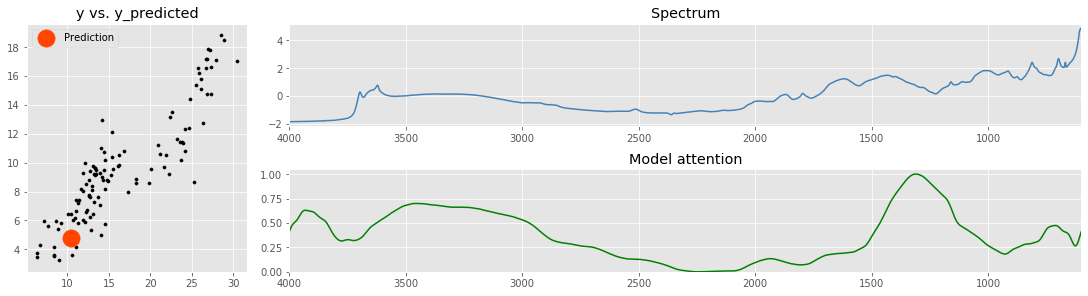

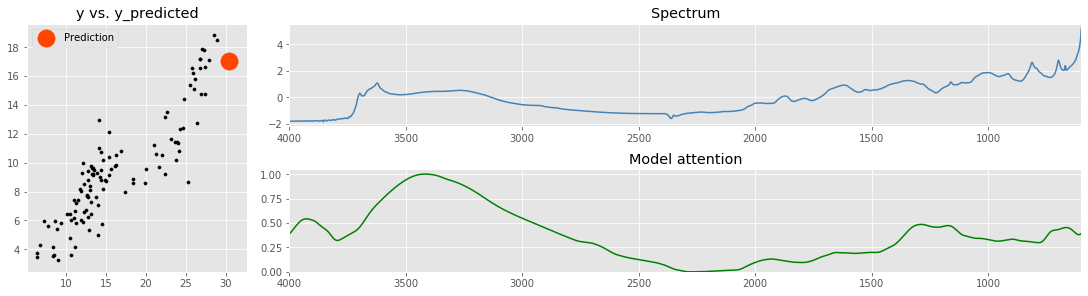

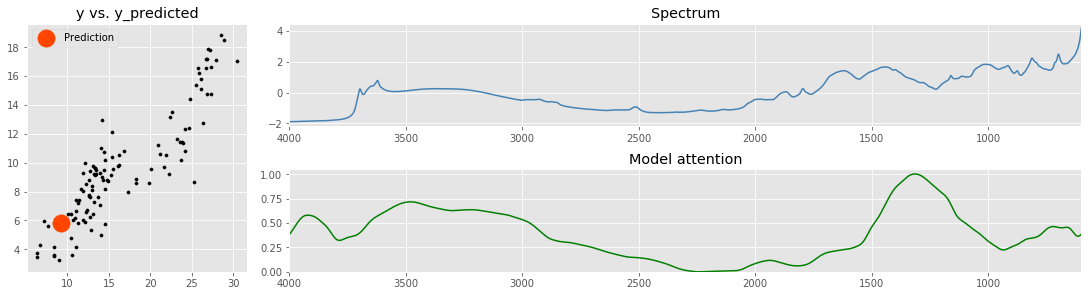

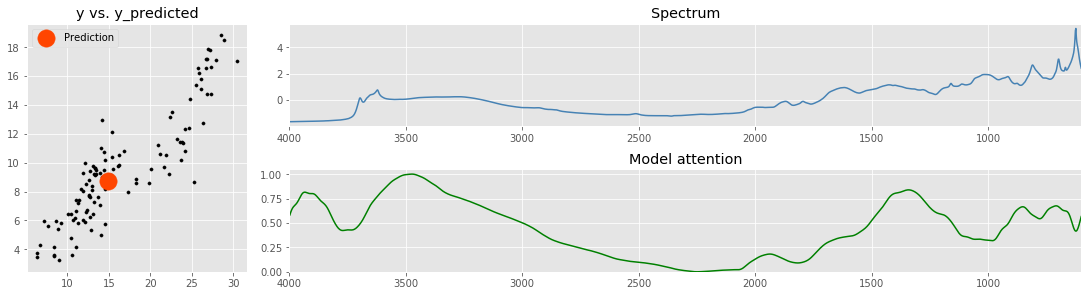

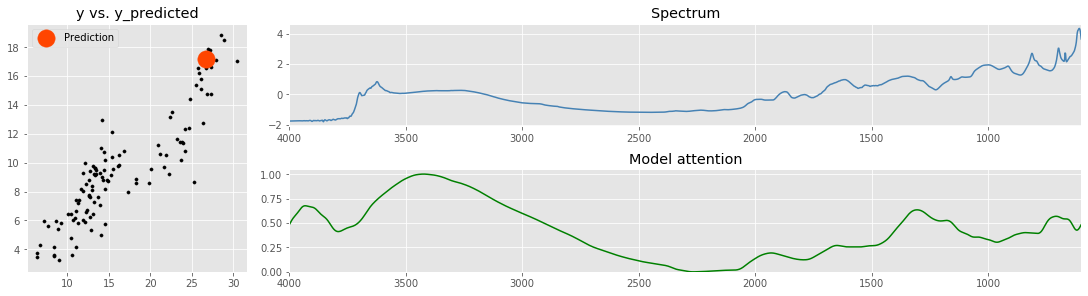

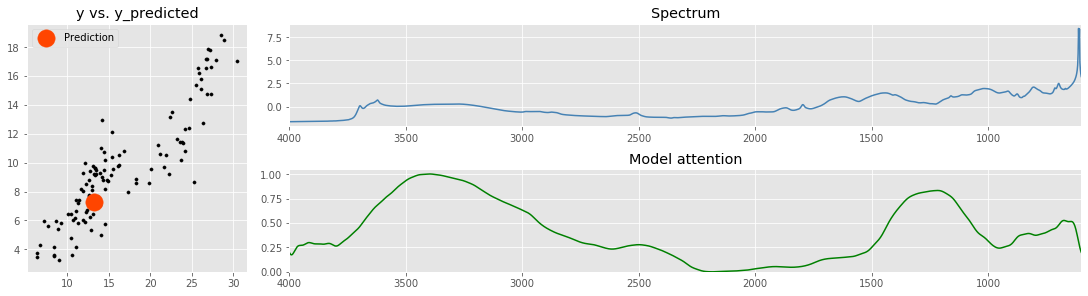

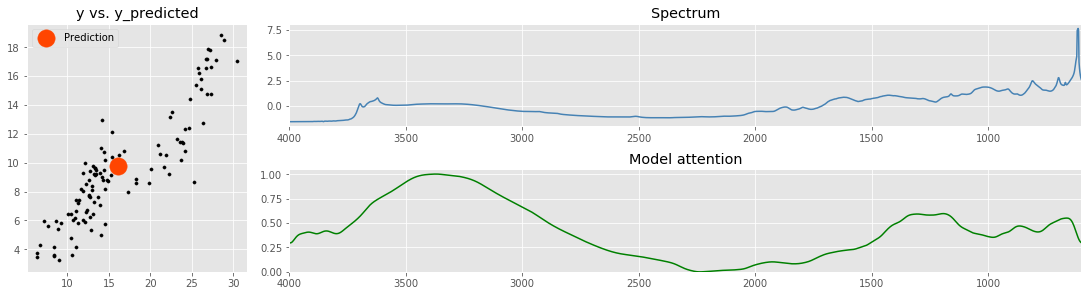

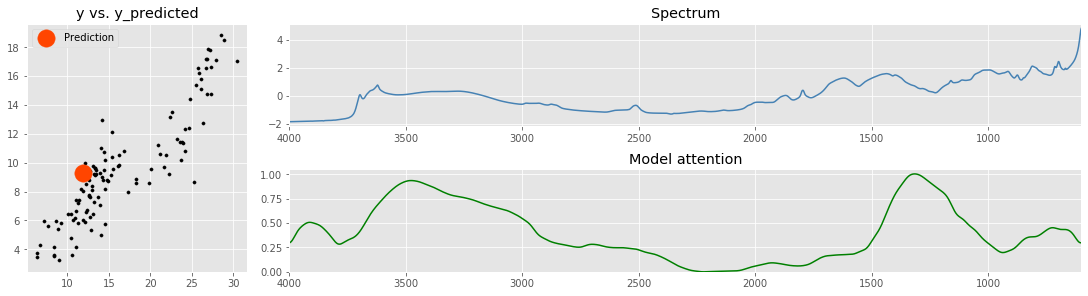

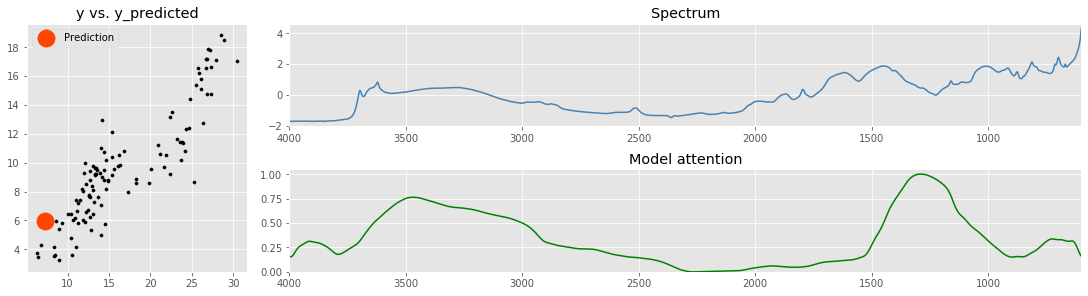

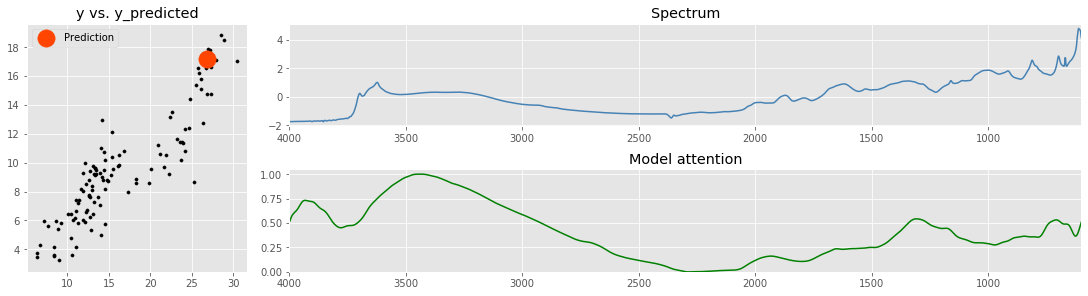

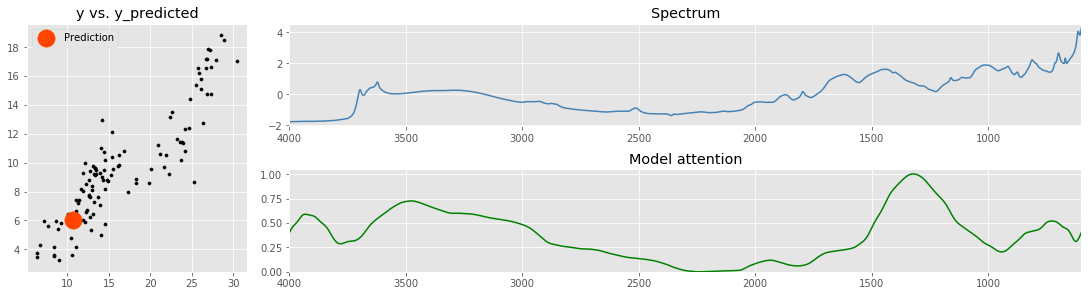

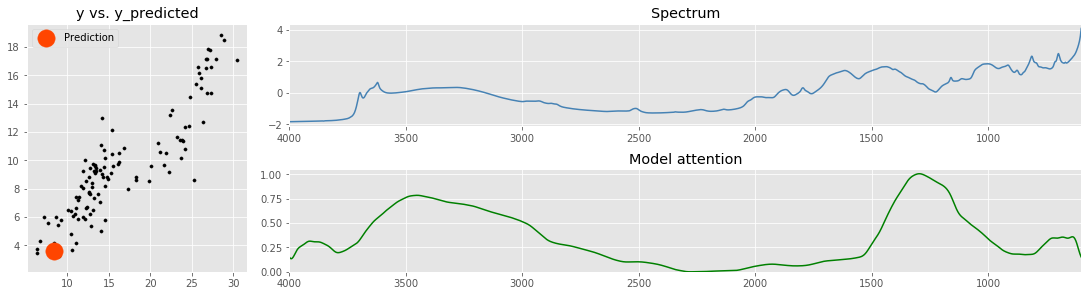

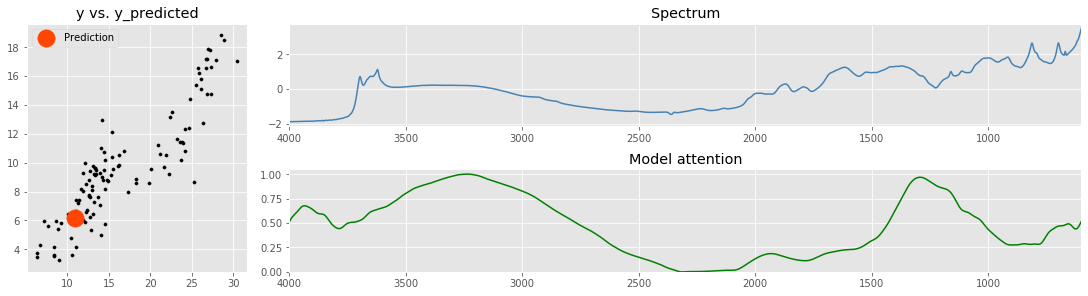

In [27]:
plt.rcParams.update({'figure.max_open_warning': 0})

for i in random.sample(range(X_train.shape[0]),30):
    plot_activation_map(X, y, model_k, 'conv1d_5', i, y_names, analyte, figsize=(15,4))

#### 3.4 Beating PLSR on K and CEC with hard-coded data augmentation?

Testing https://arxiv.org/pdf/1710.01927.pdf data augmentation proposed technique as implemented here: https://github.com/EBjerrum/Deep-Chemometrics/blob/master/Deep_Chemometrics_with_data_augmentation.py.ipynb

In [167]:
activation = 'relu'
input_dim = X_not_nan.shape[1]

model_k_a = keras.models.Sequential()
model_k_a.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model_k_a.add(layers.Conv1D(32, 30, activation=activation))
model_k_a.add(layers.MaxPool1D(10))

model_k_a.add(layers.Conv1D(64, 30, activation=activation))
model_k_a.add(layers.MaxPool1D(10))

model_k_a.add(layers.Flatten())
model_k_a.add(layers.Dense(100, activation=activation))
model_k_a.add(layers.Dense(50, activation=activation))
model_k_a.add(layers.Dense(10, activation=activation))
model_k_a.add(layers.Dense(1,  activation='linear'))

model_k_a.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model_k_a.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 1763, 1)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1734, 32)          992       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 173, 32)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 896)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)             

In [168]:
# 1. Shuffle
X_not_nan_s, y_not_nan_s = spa.shuffle(X_not_nan, y_not_nan)
print(X_not_nan.shape)

# 2. Keep X test samples
test_size = 40
X_test = X_not_nan_s[-test_size:,:]
X_not_nan_s = X_not_nan_s[:-test_size,:]
y_test = y_not_nan_s[-test_size:,:]
y_not_nan_s = y_not_nan_s[:-test_size,:]

# 3. Train-Valid Split
X_train, X_valid, y_train, y_valid = train_test_split(X_not_nan_s, y_not_nan_s, test_size=0.40, random_state=42)

In [170]:
# 4. Augment training set
X_train, y_train = spa.augment_data(X_train, y_train, by=10)
print(X_train.shape)

(680, 1763)


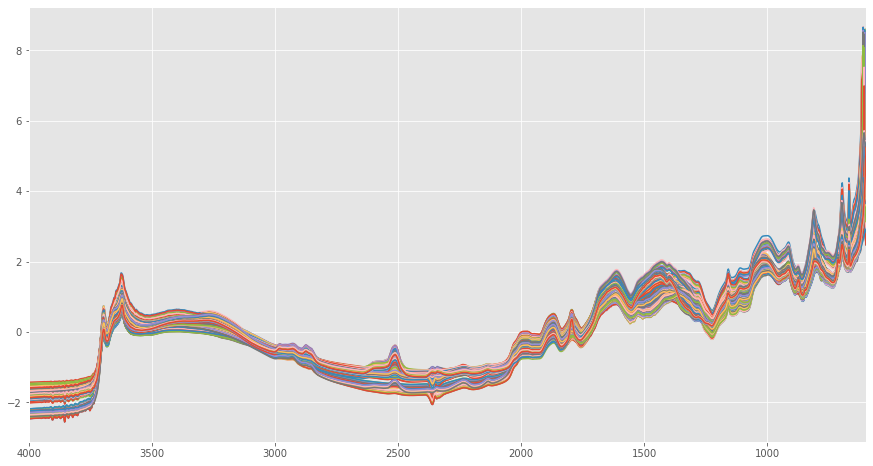

In [171]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, X_train.T)

In [172]:
analyte = 'K'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_valid_analyte = get_analyte(y_valid, y_names, analyte)

history_k_a = model_k_a.fit(normalize(X_train), y_train_analyte, epochs=500, validation_data=(normalize(X_valid), y_valid_analyte))

Train on 680 samples, validate on 46 samples
Epoch 1/500
680/680 [==============================] - 2s 2ms/sample - loss: 37.6973 - coeff_determination: -1.2989 - val_loss: 13.2159 - val_coeff_determination: -0.0425
Epoch 2/500
680/680 [==============================] - 1s 1ms/sample - loss: 18.0080 - coeff_determination: -0.2527 - val_loss: 16.1997 - val_coeff_determination: -0.3248
Epoch 3/500
680/680 [==============================] - 1s 1ms/sample - loss: 16.8007 - coeff_determination: -0.1415 - val_loss: 20.0953 - val_coeff_determination: -0.6202
Epoch 4/500
680/680 [==============================] - 1s 1ms/sample - loss: 16.4970 - coeff_determination: -0.2335 - val_loss: 28.2569 - val_coeff_determination: -1.3360
Epoch 5/500
680/680 [==============================] - 1s 1ms/sample - loss: 17.5664 - coeff_determination: -0.1900 - val_loss: 22.5393 - val_coeff_determination: -0.8347
Epoch 6/500
680/680 [==============================] - 1s 1ms/sample - loss: 17.2985 - coeff_determi

Epoch 98/500
680/680 [==============================] - 1s 1ms/sample - loss: 2.3674 - coeff_determination: 0.8356 - val_loss: 2.5033 - val_coeff_determination: 0.7818
Epoch 99/500
680/680 [==============================] - 1s 2ms/sample - loss: 2.2762 - coeff_determination: 0.8458 - val_loss: 3.3042 - val_coeff_determination: 0.7184
Epoch 100/500
680/680 [==============================] - 1s 2ms/sample - loss: 2.2114 - coeff_determination: 0.8518 - val_loss: 3.9789 - val_coeff_determination: 0.6501
Epoch 101/500
680/680 [==============================] - 1s 2ms/sample - loss: 2.1549 - coeff_determination: 0.8424 - val_loss: 3.0603 - val_coeff_determination: 0.7589
Epoch 102/500
680/680 [==============================] - 1s 2ms/sample - loss: 2.3527 - coeff_determination: 0.8366 - val_loss: 3.1594 - val_coeff_determination: 0.7326
Epoch 103/500
680/680 [==============================] - 1s 2ms/sample - loss: 2.1330 - coeff_determination: 0.8551 - val_loss: 5.2378 - val_coeff_determinat

680/680 [==============================] - 1s 1ms/sample - loss: 0.9182 - coeff_determination: 0.9371 - val_loss: 3.9970 - val_coeff_determination: 0.6119
Epoch 195/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.8840 - coeff_determination: 0.9379 - val_loss: 2.2126 - val_coeff_determination: 0.7624
Epoch 196/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.8924 - coeff_determination: 0.9400 - val_loss: 3.2518 - val_coeff_determination: 0.6544
Epoch 197/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.8088 - coeff_determination: 0.9432 - val_loss: 2.6445 - val_coeff_determination: 0.7105
Epoch 198/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.8241 - coeff_determination: 0.9393 - val_loss: 6.1540 - val_coeff_determination: 0.3891
Epoch 199/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.8619 - coeff_determination: 0.9411 - val_loss: 2.5255 - val_coeff_determination: 0.7291


680/680 [==============================] - 1s 2ms/sample - loss: 0.4903 - coeff_determination: 0.9662 - val_loss: 2.4441 - val_coeff_determination: 0.7626
Epoch 291/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.6094 - coeff_determination: 0.9598 - val_loss: 2.8064 - val_coeff_determination: 0.7026
Epoch 292/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.6716 - coeff_determination: 0.9557 - val_loss: 2.5310 - val_coeff_determination: 0.7330
Epoch 293/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.3951 - coeff_determination: 0.9719 - val_loss: 4.8562 - val_coeff_determination: 0.5350
Epoch 294/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.7186 - coeff_determination: 0.9514 - val_loss: 2.3199 - val_coeff_determination: 0.7570
Epoch 295/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.5047 - coeff_determination: 0.9655 - val_loss: 2.8100 - val_coeff_determination: 0.6956


680/680 [==============================] - 1s 1ms/sample - loss: 0.3417 - coeff_determination: 0.9761 - val_loss: 2.6111 - val_coeff_determination: 0.7376
Epoch 387/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.4365 - coeff_determination: 0.9692 - val_loss: 2.2161 - val_coeff_determination: 0.7597
Epoch 388/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.4121 - coeff_determination: 0.9723 - val_loss: 2.3653 - val_coeff_determination: 0.7524
Epoch 389/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.3820 - coeff_determination: 0.9738 - val_loss: 3.4482 - val_coeff_determination: 0.6649
Epoch 390/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.3370 - coeff_determination: 0.9761 - val_loss: 3.3807 - val_coeff_determination: 0.6534
Epoch 391/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.4082 - coeff_determination: 0.9664 - val_loss: 4.4390 - val_coeff_determination: 0.5547


680/680 [==============================] - 1s 1ms/sample - loss: 0.3781 - coeff_determination: 0.9751 - val_loss: 2.8779 - val_coeff_determination: 0.7151
Epoch 483/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.2488 - coeff_determination: 0.9826 - val_loss: 2.3801 - val_coeff_determination: 0.7744
Epoch 484/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.3676 - coeff_determination: 0.9727 - val_loss: 3.0848 - val_coeff_determination: 0.6904
Epoch 485/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.2624 - coeff_determination: 0.9783 - val_loss: 2.2201 - val_coeff_determination: 0.7655
Epoch 486/500
680/680 [==============================] - 1s 1ms/sample - loss: 0.3464 - coeff_determination: 0.9758 - val_loss: 2.1968 - val_coeff_determination: 0.7668
Epoch 487/500
680/680 [==============================] - 1s 2ms/sample - loss: 0.2208 - coeff_determination: 0.9851 - val_loss: 2.5333 - val_coeff_determination: 0.7268


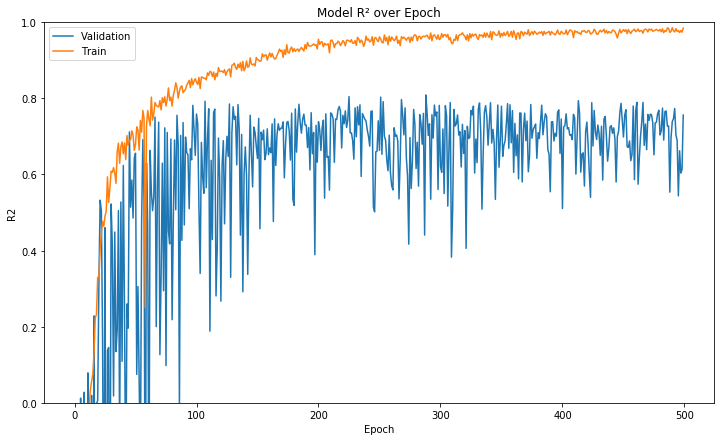

In [173]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history_k_a.history['val_coeff_determination'])
_ = ax.plot(history_k_a.history['coeff_determination'])
plt.ylim(0, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

40/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

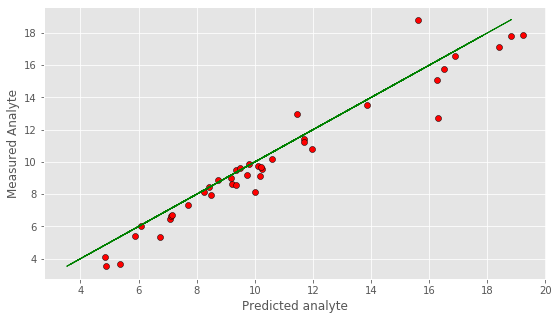

In [189]:
# Evaluate on test set
model_k_a.evaluate(normalize(X_test), get_analyte(y_test, y_names, analyte))

y_hat = model_k_a.predict(normalize(X_test)).ravel()
y_true = get_analyte(y_test, y_names, analyte)
z = np.polyfit(y_true, y_hat, 1)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_hat, y_true, c='red', edgecolors='k')
    #Plot the best fit line
    #ax.plot(np.polyval(z, y_hat), y_true, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y_true, y_true, color='green', linewidth=1)
    #plt.title('$R^{2}$ (CV): '+str(score_cv))
    plt.xlabel('Predicted analyte')
    plt.ylabel('Measured Analyte')
    plt.show()

In [244]:
# Data augmentation
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        if True:
            print(10*'*')
            print('For index: ', i)
            print('Slope: ', fit[0][0])
            print('Intercept: ', fit[0][1])
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [ ]:
data_msc, ref = msc(X_not_nan_s)

In [255]:
# Saving model
MODEL_PATH = os.path.join('..', 'models', 'basic-cnn-k-augmented.h5')
model_k.save(MODEL_PATH)

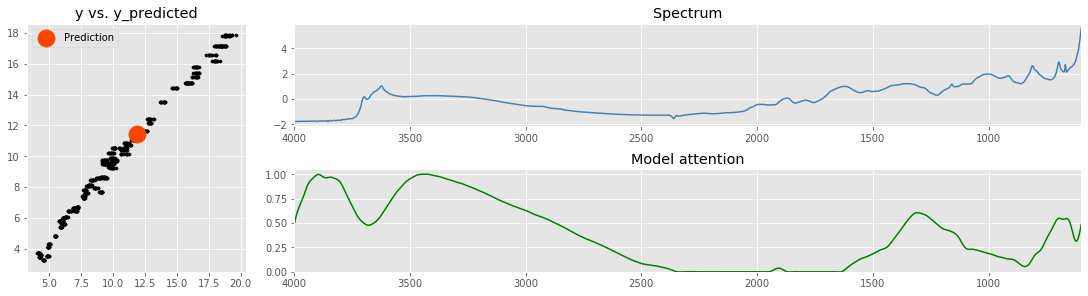

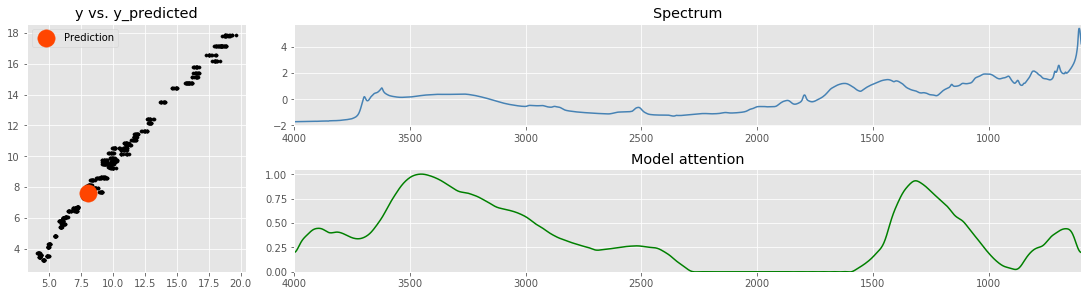

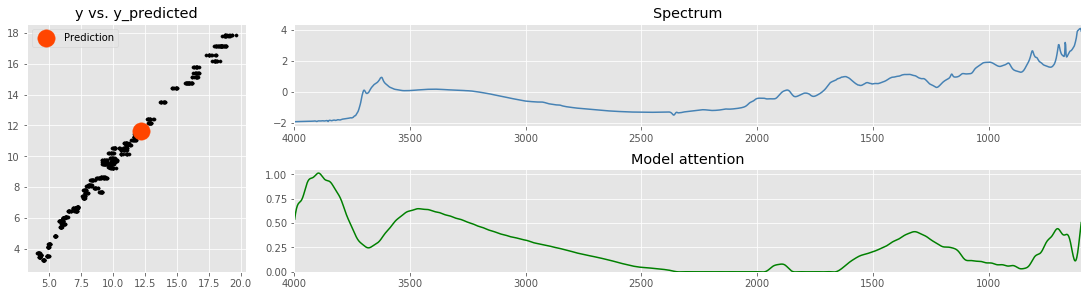

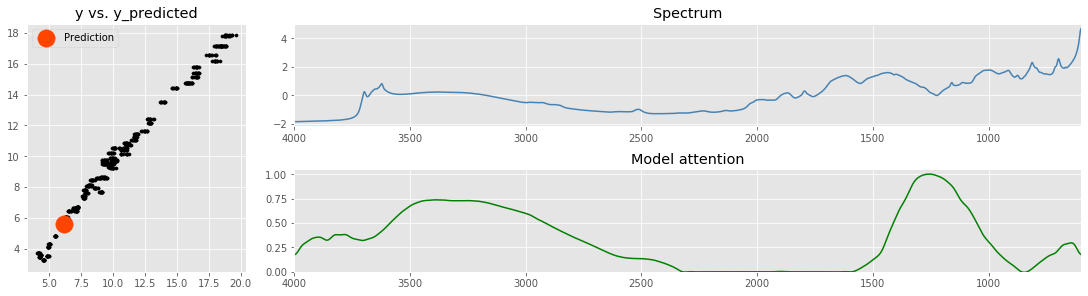

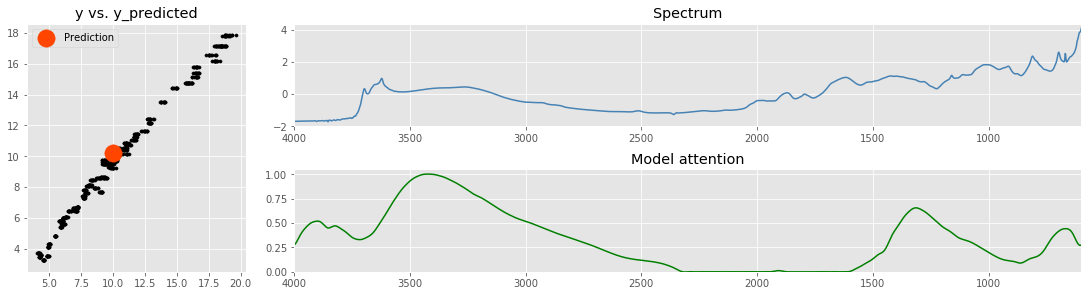

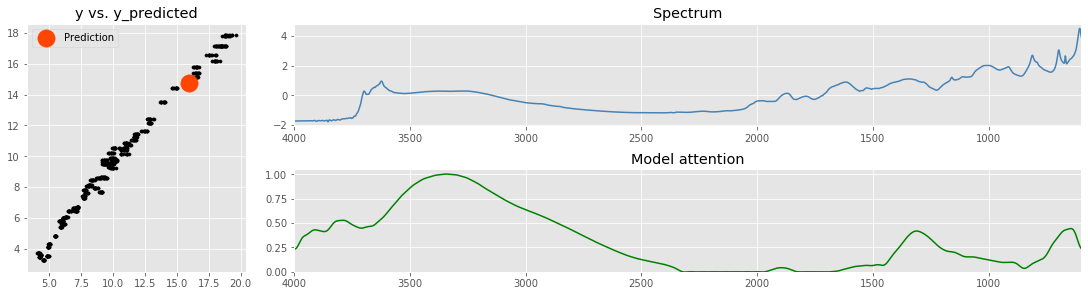

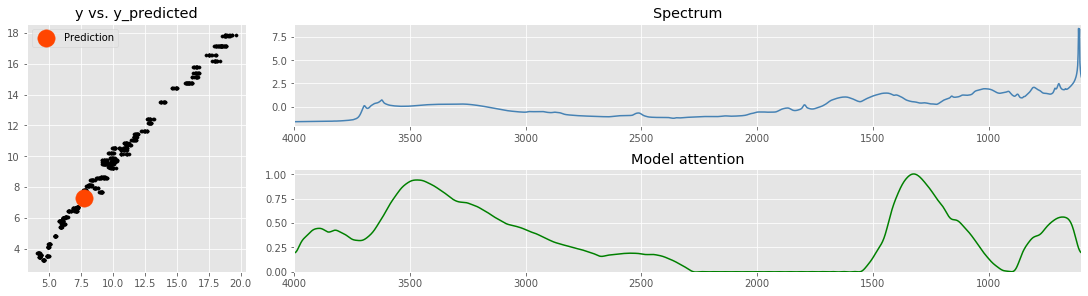

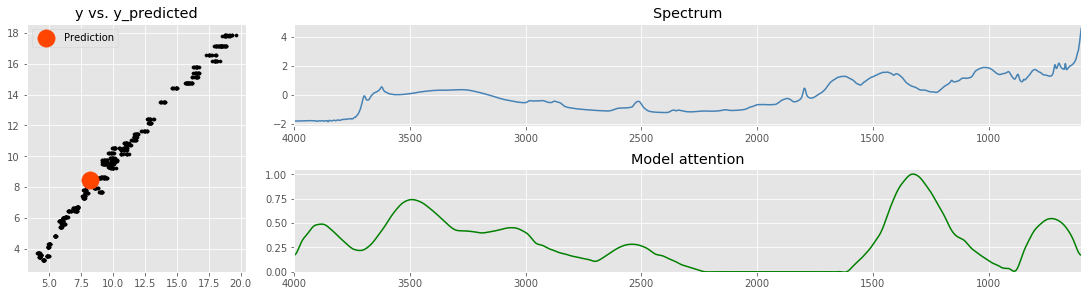

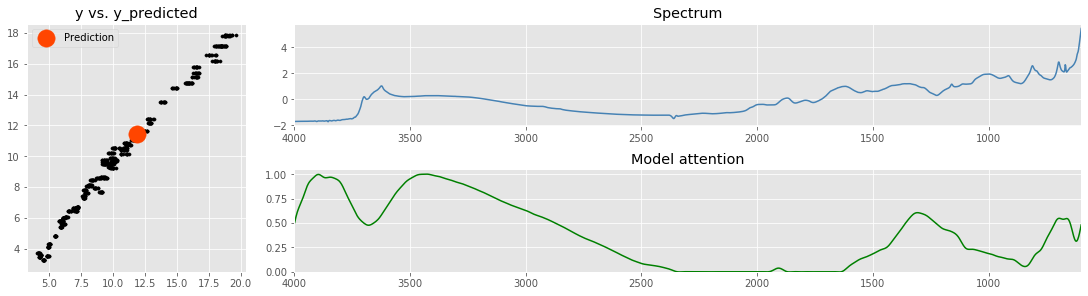

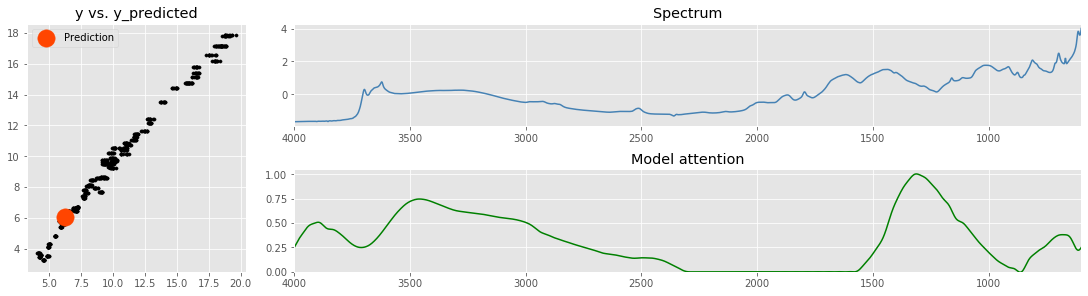

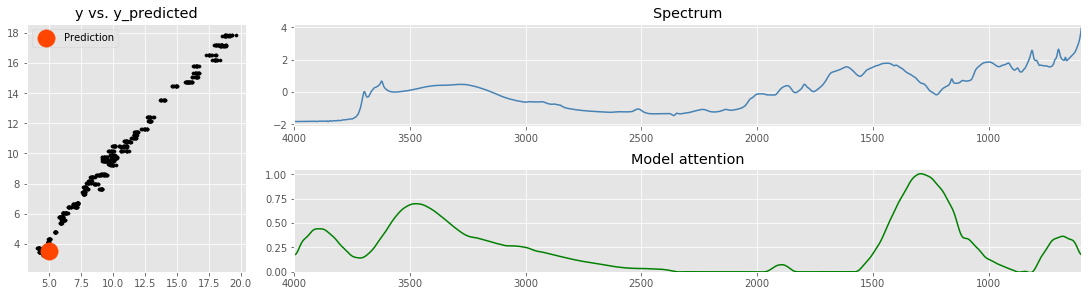

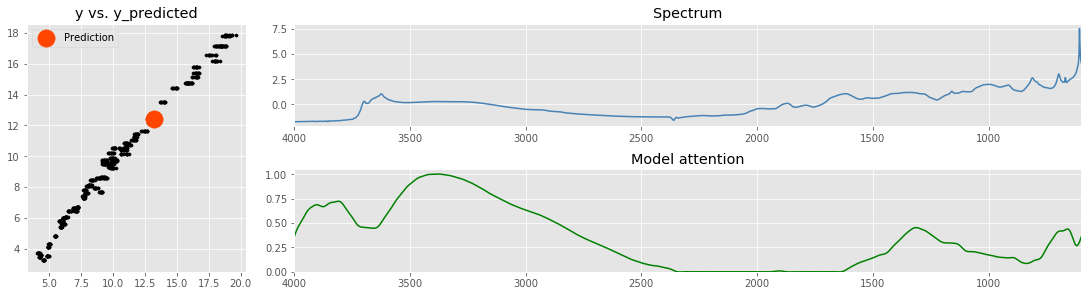

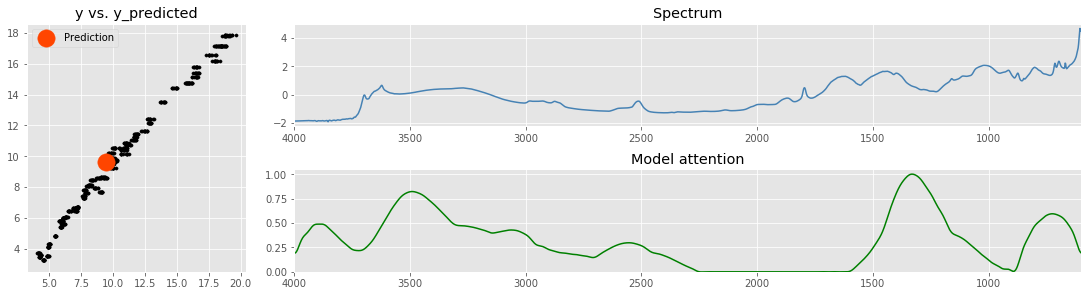

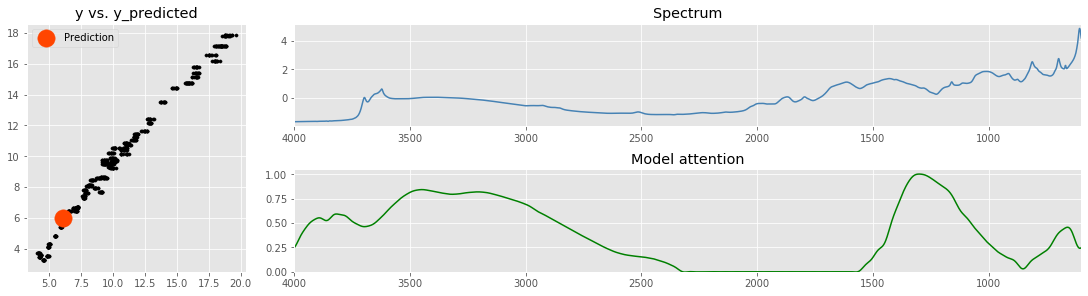

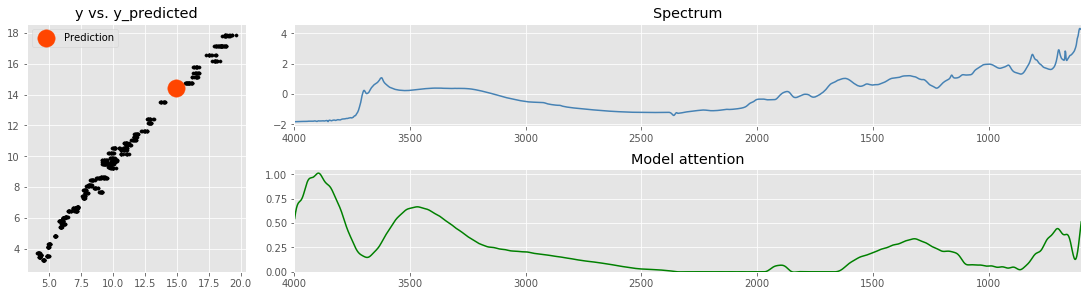

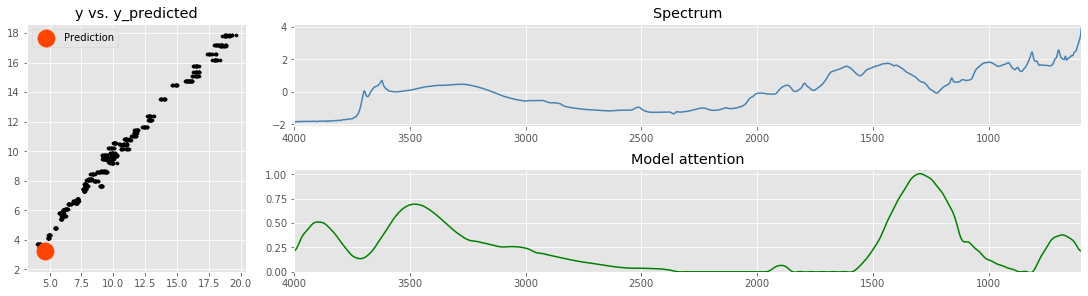

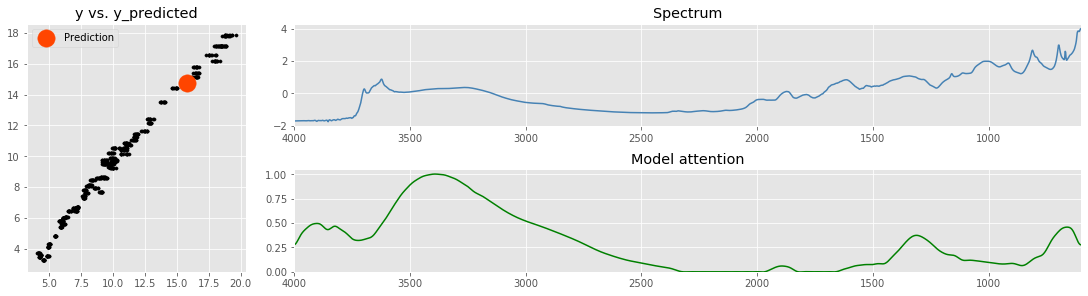

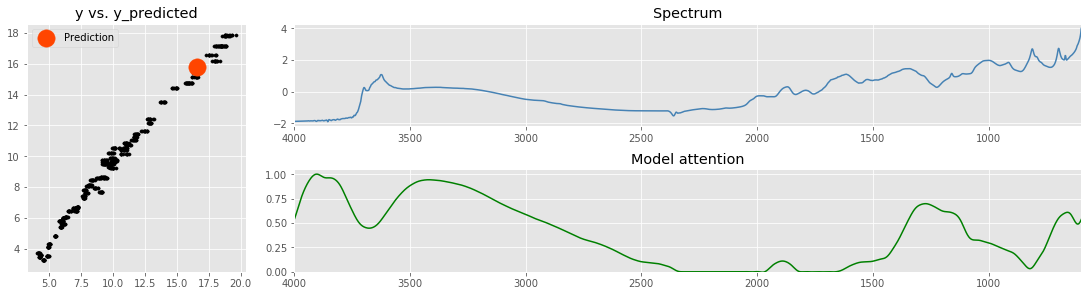

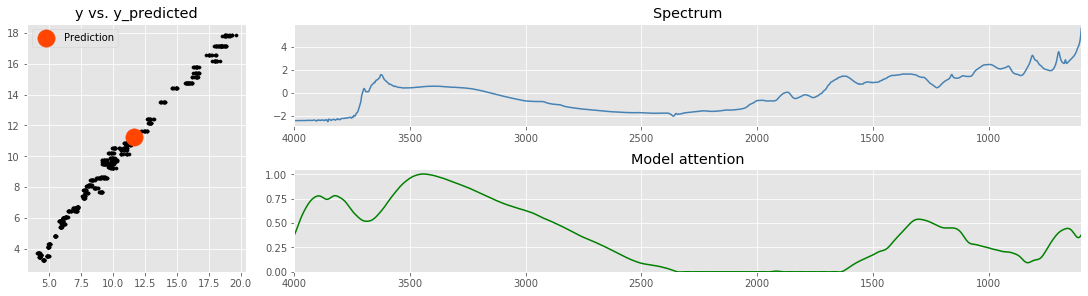

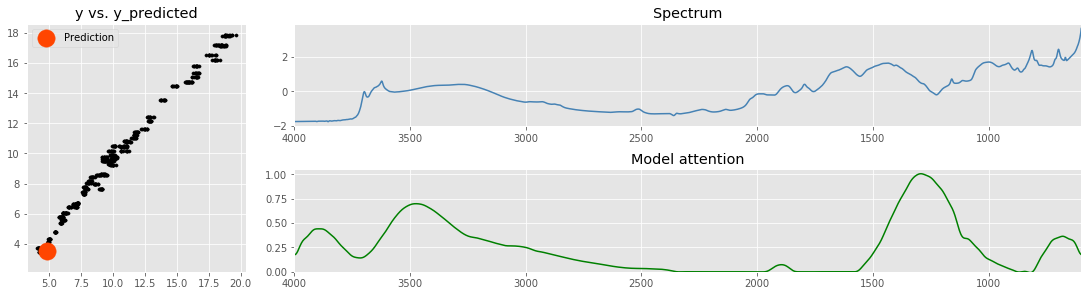

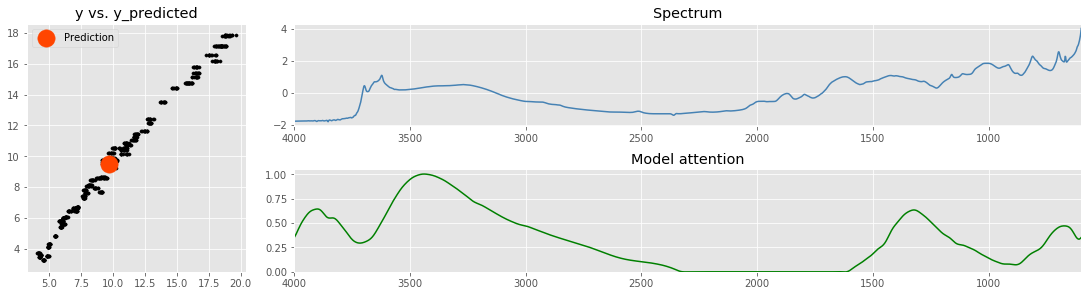

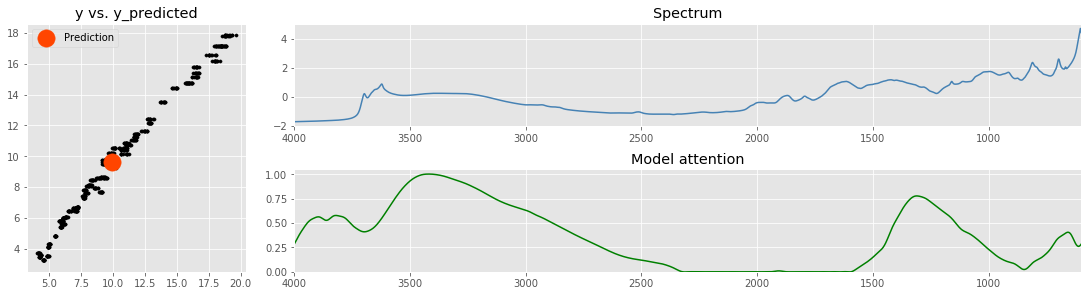

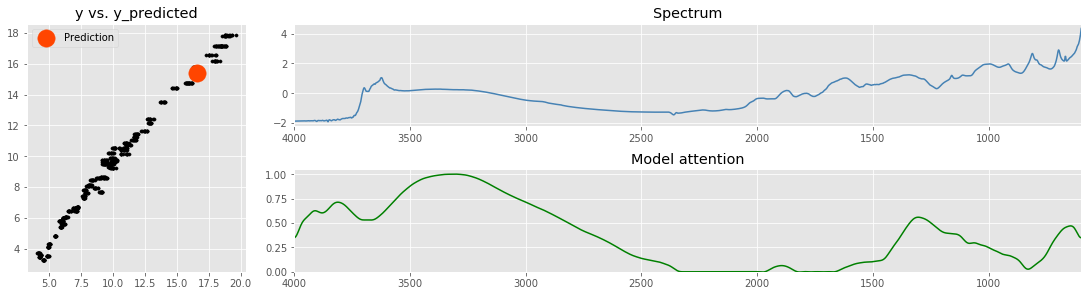

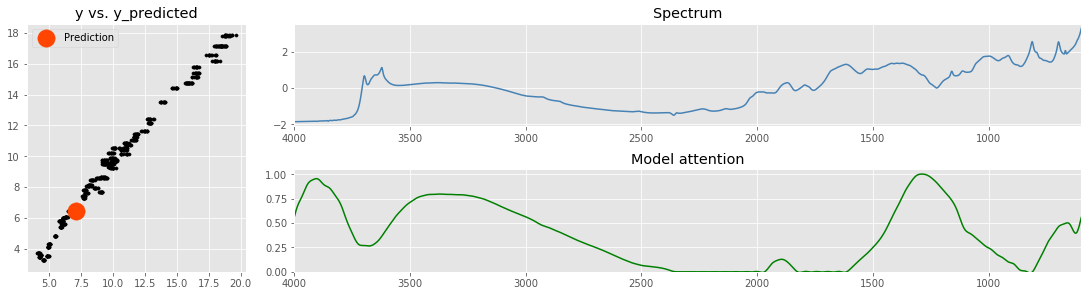

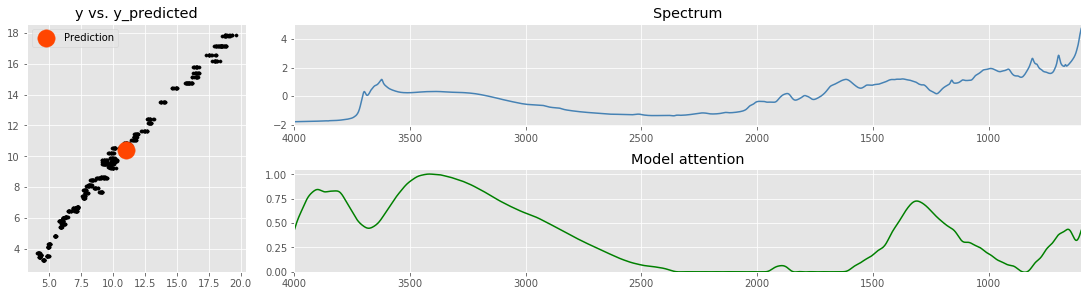

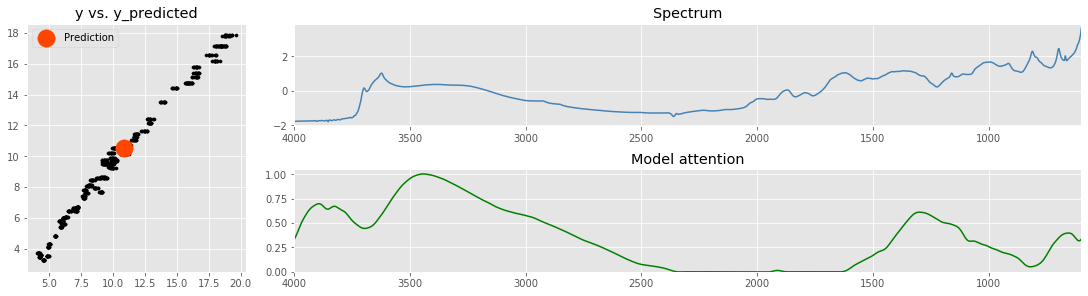

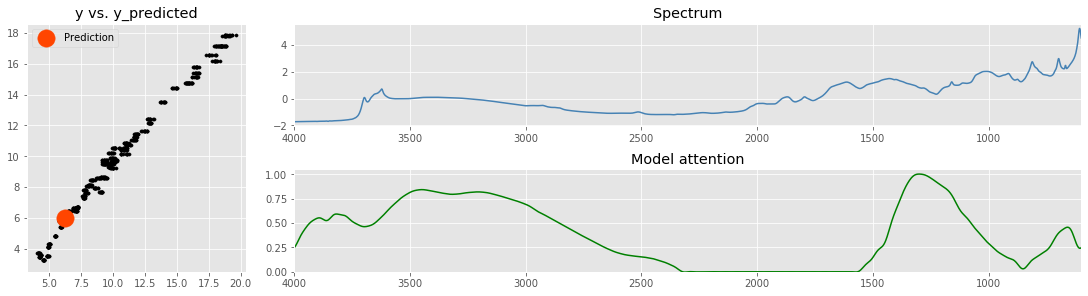

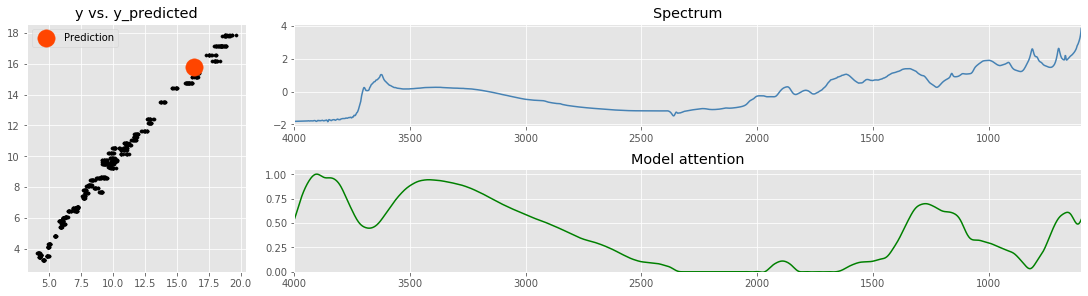

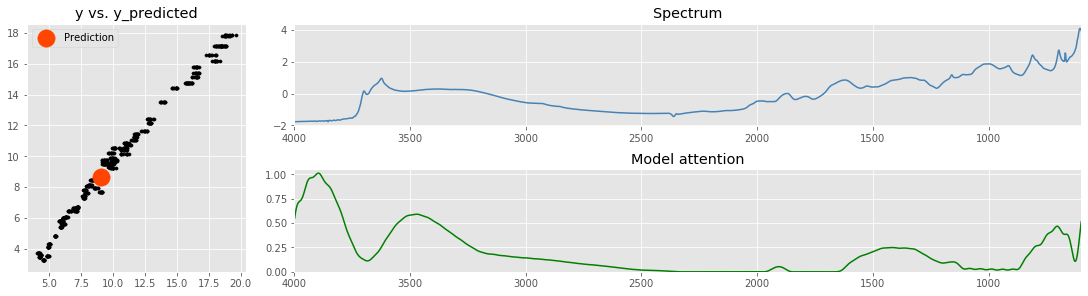

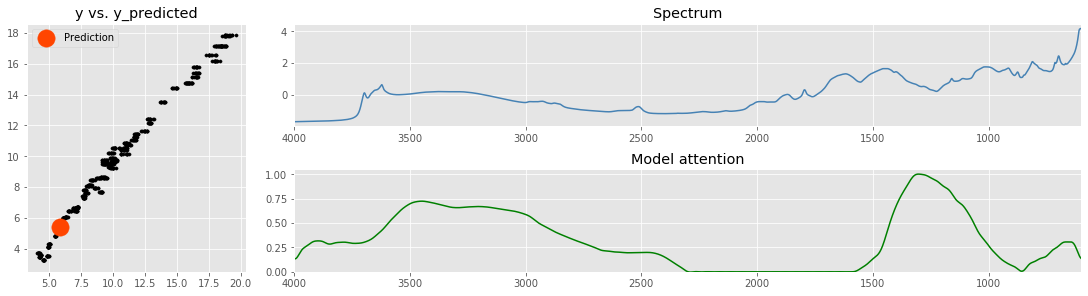

In [257]:
plt.rcParams.update({'figure.max_open_warning': 0})

for i in random.sample(range(X_train.shape[0]),30):
    plot_activation_map(X_train, y_train, model_k_a, 'conv1d_25', i, y_names, analyte, figsize=(15,4))

#### 3.5 Beating PLSR on K and CEC with VAE data augmentation?

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [19]:
MODEL_PATH = os.path.join('..', 'models', 'encoder-conv-aug.h5')
variational_encoder = models.load_model(MODEL_PATH, custom_objects={'Sampling': Sampling})

MODEL_PATH = os.path.join('..', 'models', 'decoder-conv-aug.h5')
variational_decoder = models.load_model(MODEL_PATH)

In [63]:
def augment_data_vae(X, y, by=10, codings_size = 10, input_dim = 1800, alpha=0.1):
    X_aug = np.empty(shape=(X.shape[0]*by, X.shape[1]))

    for i in range(X.shape[0]):
        # Copying real spectra
        X_aug[i*by,:] = X[i,:]

        # Generating replicates
        for j in range(1, by):
            _, _, codings = variational_encoder.predict(resample(X[i,:], input_dim).reshape(1,-1, 1))

            # Slightly disturb it
            codings_disturbed = codings + alpha * tf.random.normal(shape=[1, codings_size])

            # Reconstructing after disturbing
            augmented_spectra = variational_decoder(codings_disturbed).numpy()
            X_aug[i*by+j,:] = resample(augmented_spectra.reshape(-1), X.shape[1])

    y_aug = np.repeat(y, repeats=by, axis=0)
    return (X_aug, y_aug)

In [180]:
# Model basic I
# Remove NaN values (specific to K and CEC)
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

activation = 'relu'
input_dim = X_not_nan.shape[1]

model_k_a_vae = keras.models.Sequential()
model_k_a_vae.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model_k_a_vae.add(layers.Conv1D(32, 30, activation=activation))
model_k_a_vae.add(layers.MaxPool1D(10))

model_k_a_vae.add(layers.Conv1D(64, 30, activation=activation))
model_k_a_vae.add(layers.MaxPool1D(10))

model_k_a_vae.add(layers.Flatten())
model_k_a_vae.add(layers.Dense(100, activation=activation))
model_k_a_vae.add(layers.Dense(50, activation=activation))
model_k_a_vae.add(layers.Dense(10, activation=activation))
model_k_a_vae.add(layers.Dense(1,  activation='linear'))

model_k_a_vae.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model_k_a_vae.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 1763, 1)           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 1734, 32)          992       
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 173, 32)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 896)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)             

In [210]:
# Model basic II inspired from Ng paper USDA/University Sidney paper arch.

# Remove NaN values (specific to K and CEC)
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

activation = 'relu'
input_dim = X_not_nan.shape[1]

model_k_a_vae = keras.models.Sequential()
model_k_a_vae.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model_k_a_vae.add(layers.Conv1D(32, 30, activation=activation))
model_k_a_vae.add(layers.MaxPool1D(10))

model_k_a_vae.add(layers.Conv1D(64, 30, activation=activation))
model_k_a_vae.add(layers.MaxPool1D(10))

#model_k_a_vae.add(layers.Conv1D(128, 10, activation=activation))
#model_k_a_vae.add(layers.MaxPool1D(1))

#model_k_a_vae.add(layers.Conv1D(256, 20, activation=activation))
#model_k_a_vae.add(layers.MaxPool1D(2))

#model_k_a_vae.add(layers.Dropout(0.4))

model_k_a_vae.add(layers.Flatten())
model_k_a_vae.add(layers.Dense(100, activation=activation))
#model_k_a_vae.add(layers.Dropout(0.2))

model_k_a_vae.add(layers.Dense(50, activation=activation))
model_k_a_vae.add(layers.Dense(10, activation=activation))
model_k_a_vae.add(layers.Dense(1,  activation='linear'))

model_k_a_vae.compile(optimizer=RMSprop(learning_rate=0.01), loss='mse', metrics=[coeff_determination])
model_k_a_vae.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 1763, 1)           0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 1734, 32)          992       
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 173, 32)           0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 14, 64)            0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 896)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 100)             

In [164]:
# 1. Shuffle
X_not_nan_s, y_not_nan_s = spa.shuffle(X_not_nan, y_not_nan, seed=40)
print(X_not_nan.shape)

# 2. Keep X test samples
test_size = 40
X_test = X_not_nan_s[-test_size:,:]
X_not_nan_s = X_not_nan_s[:-test_size,:]
y_test = y_not_nan_s[-test_size:,:]
y_not_nan_s = y_not_nan_s[:-test_size,:]


(114, 1763)


In [158]:
# 3. Augment training set
X_train, y_train = augment_data_vae(X_not_nan_s, y_not_nan_s, by=10, alpha=0.1)
X_train, y_train = spa.shuffle(X_train, y_train, seed=42)

# 4. Train-Valid Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape)

(592, 1763)


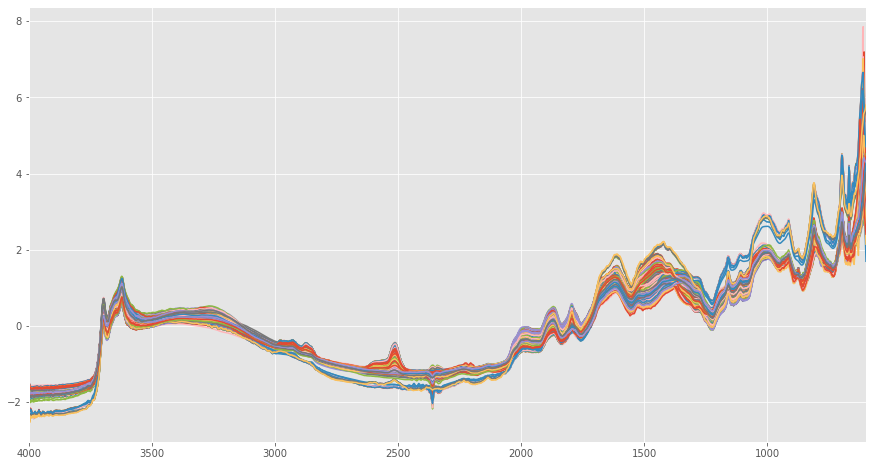

In [159]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, X_train.T)

In [211]:
# Training phase
analyte = 'K'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_valid_analyte = get_analyte(y_valid, y_names, analyte)

history_k_a_vae = model_k_a_vae.fit(normalize(X_train), y_train_analyte, epochs=500, validation_data=(normalize(X_valid), y_valid_analyte))

Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 1s 2ms/sample - loss: 82.3613 - coeff_determination: -5.4977 - val_loss: 13.9040 - val_coeff_determination: -0.1536
Epoch 2/500
592/592 [==============================] - 1s 1ms/sample - loss: 20.8507 - coeff_determination: -0.5775 - val_loss: 19.6499 - val_coeff_determination: -0.6345
Epoch 3/500
592/592 [==============================] - 1s 1ms/sample - loss: 24.6061 - coeff_determination: -1.0480 - val_loss: 38.7851 - val_coeff_determination: -2.3159
Epoch 4/500
592/592 [==============================] - 1s 1ms/sample - loss: 22.9750 - coeff_determination: -0.8756 - val_loss: 20.2449 - val_coeff_determination: -0.6857
Epoch 5/500
592/592 [==============================] - 1s 1ms/sample - loss: 21.3489 - coeff_determination: -0.6039 - val_loss: 166.5986 - val_coeff_determination: -13.2742
Epoch 6/500
592/592 [==============================] - 1s 1ms/sample - loss: 29.7260 - coeff_dete

Epoch 97/500
592/592 [==============================] - 1s 1ms/sample - loss: 4.2723 - coeff_determination: 0.6824 - val_loss: 5.3310 - val_coeff_determination: 0.5250
Epoch 98/500
592/592 [==============================] - 1s 1ms/sample - loss: 4.0584 - coeff_determination: 0.6869 - val_loss: 3.1814 - val_coeff_determination: 0.7356
Epoch 99/500
592/592 [==============================] - 1s 1ms/sample - loss: 4.1878 - coeff_determination: 0.6772 - val_loss: 3.2137 - val_coeff_determination: 0.7336
Epoch 100/500
592/592 [==============================] - 1s 1ms/sample - loss: 4.0605 - coeff_determination: 0.6906 - val_loss: 3.1622 - val_coeff_determination: 0.7397
Epoch 101/500
592/592 [==============================] - 1s 1ms/sample - loss: 4.2752 - coeff_determination: 0.6814 - val_loss: 3.4799 - val_coeff_determination: 0.7009
Epoch 102/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.6446 - coeff_determination: 0.7222 - val_loss: 3.1930 - val_coeff_determinati

592/592 [==============================] - 1s 1ms/sample - loss: 3.7223 - coeff_determination: 0.7098 - val_loss: 3.2826 - val_coeff_determination: 0.7245
Epoch 194/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.7145 - coeff_determination: 0.7213 - val_loss: 3.4840 - val_coeff_determination: 0.7002
Epoch 195/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.8688 - coeff_determination: 0.7048 - val_loss: 4.7511 - val_coeff_determination: 0.5889
Epoch 196/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.6146 - coeff_determination: 0.7202 - val_loss: 7.2608 - val_coeff_determination: 0.3574
Epoch 197/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.8666 - coeff_determination: 0.6606 - val_loss: 3.1611 - val_coeff_determination: 0.7372
Epoch 198/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.6530 - coeff_determination: 0.7214 - val_loss: 3.5867 - val_coeff_determination: 0.6878


592/592 [==============================] - 1s 1ms/sample - loss: 3.4923 - coeff_determination: 0.7356 - val_loss: 3.1122 - val_coeff_determination: 0.7395
Epoch 290/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.6913 - coeff_determination: 0.7249 - val_loss: 3.2304 - val_coeff_determination: 0.7213
Epoch 291/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.5184 - coeff_determination: 0.7326 - val_loss: 3.2222 - val_coeff_determination: 0.7228
Epoch 292/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.5421 - coeff_determination: 0.7253 - val_loss: 3.2471 - val_coeff_determination: 0.7229
Epoch 293/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4472 - coeff_determination: 0.7385 - val_loss: 3.3623 - val_coeff_determination: 0.7103
Epoch 294/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.5208 - coeff_determination: 0.7302 - val_loss: 6.5041 - val_coeff_determination: 0.4220


592/592 [==============================] - 1s 1ms/sample - loss: 3.3605 - coeff_determination: 0.7470 - val_loss: 4.7914 - val_coeff_determination: 0.5761
Epoch 386/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4869 - coeff_determination: 0.7401 - val_loss: 3.5729 - val_coeff_determination: 0.7024
Epoch 387/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4441 - coeff_determination: 0.7269 - val_loss: 3.4940 - val_coeff_determination: 0.6967
Epoch 388/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4577 - coeff_determination: 0.7318 - val_loss: 4.7298 - val_coeff_determination: 0.5809
Epoch 389/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.5856 - coeff_determination: 0.7149 - val_loss: 3.3213 - val_coeff_determination: 0.7167
Epoch 390/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4168 - coeff_determination: 0.7300 - val_loss: 3.3343 - val_coeff_determination: 0.7196


592/592 [==============================] - 1s 1ms/sample - loss: 3.6320 - coeff_determination: 0.7267 - val_loss: 3.2277 - val_coeff_determination: 0.7285
Epoch 482/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4786 - coeff_determination: 0.7415 - val_loss: 3.4888 - val_coeff_determination: 0.6982
Epoch 483/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.4673 - coeff_determination: 0.7333 - val_loss: 3.5503 - val_coeff_determination: 0.6892
Epoch 484/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.3545 - coeff_determination: 0.7470 - val_loss: 3.1350 - val_coeff_determination: 0.7295
Epoch 485/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.3433 - coeff_determination: 0.7474 - val_loss: 4.0299 - val_coeff_determination: 0.6617
Epoch 486/500
592/592 [==============================] - 1s 1ms/sample - loss: 3.3700 - coeff_determination: 0.7372 - val_loss: 3.5860 - val_coeff_determination: 0.6919


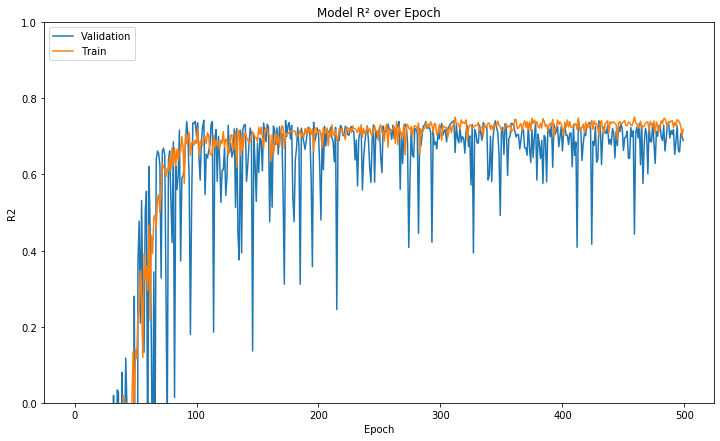

In [212]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history_k_a_vae.history['val_coeff_determination'])
_ = ax.plot(history_k_a_vae.history['coeff_determination'])
plt.ylim(0, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

40/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

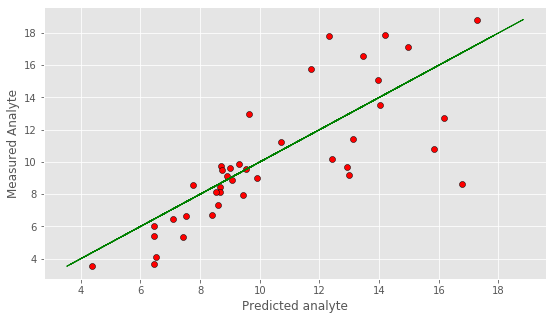

In [213]:
# Evaluate on test set
model_k_a_vae.evaluate(normalize(X_test), get_analyte(y_test, y_names, analyte))

y_hat = model_k_a_vae.predict(normalize(X_test)).ravel()
y_true = get_analyte(y_test, y_names, analyte)
z = np.polyfit(y_true, y_hat, 1)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_hat, y_true, c='red', edgecolors='k')
    ax.plot(y_true, y_true, color='green', linewidth=1)
    plt.xlabel('Predicted analyte')
    plt.ylabel('Measured Analyte')
    plt.show()

#### 3.6 Two-channel 1D CNN 

In [177]:
def get_two_channel_data(X, X_names):
    m = X.shape[0]
    n_wavenumbers = X.shape[1]
    X = utils.normalize(X)
    X_names = utils.normalize(X_names)
    X = X.reshape((m,n_wavenumbers,1))
    X_names = np.tile(X_names, m).reshape(m,n_wavenumbers,1)
    return np.dstack((X, X_names))

In [178]:
X_2c = get_two_channel_data(X, X_names)

In [191]:
activation = 'relu'

model = keras.models.Sequential()

model.add(layers.Conv1D(32, 30, activation=activation, input_shape=X_2c.shape[1:]))
model.add(layers.MaxPool1D(10))

model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(10))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation=activation))
model.add(layers.Dense(50, activation=activation))
model.add(layers.Dense(10, activation=activation))
model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 1734, 32)          1952      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 173, 32)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 144, 64)           61504     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               89700     
_________________________________________________________________
dense_33 (Dense)             (None, 50)              

In [192]:
X_train, X_valid, y_train, y_valid = train_test_split(X_2c, y, test_size=0.40, random_state=42)

analyte = 'TOC'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_valid_analyte = get_analyte(y_valid, y_names, analyte)

In [194]:
history = model.fit(X_train, y_train_analyte, epochs=2000, validation_data=(X_valid, y_valid_analyte))

Train on 78 samples, validate on 52 samples
Epoch 1/2000
78/78 [==============================] - 1s 12ms/sample - loss: 2.8078 - coeff_determination: -5.8217 - val_loss: 0.9078 - val_coeff_determination: -1.2880
Epoch 2/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.6949 - coeff_determination: -0.7236 - val_loss: 0.5084 - val_coeff_determination: -0.2756
Epoch 3/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.5447 - coeff_determination: -0.3456 - val_loss: 0.7273 - val_coeff_determination: -0.8316
Epoch 4/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.5879 - coeff_determination: -0.3524 - val_loss: 0.6156 - val_coeff_determination: -0.5490
Epoch 5/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.4836 - coeff_determination: -0.1270 - val_loss: 0.4074 - val_coeff_determination: -0.0212
Epoch 6/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.4977 - coeff_determination: -0.2617 -

78/78 [==============================] - 0s 2ms/sample - loss: 0.1664 - coeff_determination: 0.5175 - val_loss: 0.2857 - val_coeff_determination: 0.2804
Epoch 99/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.2573 - coeff_determination: 0.3541 - val_loss: 0.1614 - val_coeff_determination: 0.5907
Epoch 100/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1540 - coeff_determination: 0.6462 - val_loss: 0.0950 - val_coeff_determination: 0.7601
Epoch 101/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0984 - coeff_determination: 0.7945 - val_loss: 0.0885 - val_coeff_determination: 0.7762
Epoch 102/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1128 - coeff_determination: 0.7460 - val_loss: 0.0947 - val_coeff_determination: 0.7604
Epoch 103/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0962 - coeff_determination: 0.5554 - val_loss: 0.1871 - val_coeff_determination: 0.5286
Epoch 10

Epoch 147/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1906 - coeff_determination: 0.5490 - val_loss: 0.0953 - val_coeff_determination: 0.7588
Epoch 148/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0832 - coeff_determination: 0.8067 - val_loss: 0.2453 - val_coeff_determination: 0.3770
Epoch 149/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1998 - coeff_determination: 0.5061 - val_loss: 0.0884 - val_coeff_determination: 0.7762
Epoch 150/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0829 - coeff_determination: 0.7930 - val_loss: 0.0965 - val_coeff_determination: 0.7551
Epoch 151/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0921 - coeff_determination: 0.7633 - val_loss: 0.0791 - val_coeff_determination: 0.7996
Epoch 152/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1160 - coeff_determination: 0.6985 - val_loss: 0.2167 - val_coeff_determination:

Epoch 196/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0663 - coeff_determination: 0.8399 - val_loss: 0.0767 - val_coeff_determination: 0.8051
Epoch 197/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0746 - coeff_determination: 0.8203 - val_loss: 0.2287 - val_coeff_determination: 0.4191
Epoch 198/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.1560 - coeff_determination: 0.6564 - val_loss: 0.0850 - val_coeff_determination: 0.7849
Epoch 199/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0690 - coeff_determination: 0.8415 - val_loss: 0.0793 - val_coeff_determination: 0.7986
Epoch 200/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0844 - coeff_determination: 0.7889 - val_loss: 0.1085 - val_coeff_determination: 0.7263
Epoch 201/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.1038 - coeff_determination: 0.7650 - val_loss: 0.0812 - val_coeff_determination:

Epoch 245/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0552 - coeff_determination: 0.8687 - val_loss: 0.1044 - val_coeff_determination: 0.7340
Epoch 246/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0941 - coeff_determination: 0.7506 - val_loss: 0.2099 - val_coeff_determination: 0.4708
Epoch 247/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.1677 - coeff_determination: 0.6510 - val_loss: 0.0870 - val_coeff_determination: 0.7787
Epoch 248/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0546 - coeff_determination: 0.8532 - val_loss: 0.0921 - val_coeff_determination: 0.7654
Epoch 249/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0573 - coeff_determination: 0.8527 - val_loss: 0.0786 - val_coeff_determination: 0.8004
Epoch 250/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0577 - coeff_determination: 0.8375 - val_loss: 0.0734 - val_coeff_determination:

Epoch 294/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0591 - coeff_determination: 0.8436 - val_loss: 0.1011 - val_coeff_determination: 0.7432
Epoch 295/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0606 - coeff_determination: 0.8588 - val_loss: 0.1108 - val_coeff_determination: 0.7170
Epoch 296/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0755 - coeff_determination: 0.6928 - val_loss: 0.1586 - val_coeff_determination: 0.5991
Epoch 297/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0941 - coeff_determination: 0.7950 - val_loss: 0.0824 - val_coeff_determination: 0.7897
Epoch 298/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0551 - coeff_determination: 0.8270 - val_loss: 0.1022 - val_coeff_determination: 0.7392
Epoch 299/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0439 - coeff_determination: 0.8891 - val_loss: 0.1540 - val_coeff_determination:

Epoch 343/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0570 - coeff_determination: 0.8583 - val_loss: 0.1127 - val_coeff_determination: 0.7142
Epoch 344/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0580 - coeff_determination: 0.8729 - val_loss: 0.1244 - val_coeff_determination: 0.6819
Epoch 345/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0441 - coeff_determination: 0.8894 - val_loss: 0.0826 - val_coeff_determination: 0.7884
Epoch 346/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0345 - coeff_determination: 0.9012 - val_loss: 0.1238 - val_coeff_determination: 0.6834
Epoch 347/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0551 - coeff_determination: 0.8223 - val_loss: 0.1671 - val_coeff_determination: 0.5770
Epoch 348/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.1264 - coeff_determination: 0.7429 - val_loss: 0.0905 - val_coeff_determination:

Epoch 392/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0348 - coeff_determination: 0.9221 - val_loss: 0.1047 - val_coeff_determination: 0.7319
Epoch 393/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0353 - coeff_determination: 0.8873 - val_loss: 0.1729 - val_coeff_determination: 0.5586
Epoch 394/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0468 - coeff_determination: 0.8943 - val_loss: 0.1387 - val_coeff_determination: 0.6478
Epoch 395/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0637 - coeff_determination: 0.8644 - val_loss: 0.1008 - val_coeff_determination: 0.7417
Epoch 396/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0363 - coeff_determination: 0.9015 - val_loss: 0.1531 - val_coeff_determination: 0.6121
Epoch 397/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0847 - coeff_determination: 0.8167 - val_loss: 0.1204 - val_coeff_determination:

Epoch 441/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0616 - coeff_determination: 0.8108 - val_loss: 0.1423 - val_coeff_determination: 0.6368
Epoch 442/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0541 - coeff_determination: 0.8766 - val_loss: 0.1689 - val_coeff_determination: 0.5688
Epoch 443/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0791 - coeff_determination: 0.8133 - val_loss: 0.0923 - val_coeff_determination: 0.7632
Epoch 444/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0439 - coeff_determination: 0.8959 - val_loss: 0.1322 - val_coeff_determination: 0.6617
Epoch 445/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0355 - coeff_determination: 0.9136 - val_loss: 0.1661 - val_coeff_determination: 0.5753
Epoch 446/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0413 - coeff_determination: 0.8965 - val_loss: 0.0973 - val_coeff_determination:

Epoch 490/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0386 - coeff_determination: 0.9104 - val_loss: 0.1414 - val_coeff_determination: 0.6378
Epoch 491/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0293 - coeff_determination: 0.9219 - val_loss: 0.1115 - val_coeff_determination: 0.7145
Epoch 492/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0279 - coeff_determination: 0.9244 - val_loss: 0.0990 - val_coeff_determination: 0.7462
Epoch 493/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0753 - coeff_determination: 0.7556 - val_loss: 0.1415 - val_coeff_determination: 0.6392
Epoch 494/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0363 - coeff_determination: 0.9140 - val_loss: 0.0992 - val_coeff_determination: 0.7460
Epoch 495/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0307 - coeff_determination: 0.9246 - val_loss: 0.1564 - val_coeff_determination:

Epoch 539/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0237 - coeff_determination: 0.9438 - val_loss: 0.1170 - val_coeff_determination: 0.7002
Epoch 540/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0254 - coeff_determination: 0.9227 - val_loss: 0.1170 - val_coeff_determination: 0.7006
Epoch 541/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0272 - coeff_determination: 0.9275 - val_loss: 0.1091 - val_coeff_determination: 0.7210
Epoch 542/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0498 - coeff_determination: 0.8811 - val_loss: 0.1318 - val_coeff_determination: 0.6630
Epoch 543/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0262 - coeff_determination: 0.9361 - val_loss: 0.1465 - val_coeff_determination: 0.6252
Epoch 544/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0413 - coeff_determination: 0.8609 - val_loss: 0.1306 - val_coeff_determination:

Epoch 588/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0348 - coeff_determination: 0.9186 - val_loss: 0.1120 - val_coeff_determination: 0.7133
Epoch 589/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0207 - coeff_determination: 0.9458 - val_loss: 0.1314 - val_coeff_determination: 0.6638
Epoch 590/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0236 - coeff_determination: 0.9468 - val_loss: 0.1104 - val_coeff_determination: 0.7171
Epoch 591/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0257 - coeff_determination: 0.9318 - val_loss: 0.1014 - val_coeff_determination: 0.7403
Epoch 592/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0404 - coeff_determination: 0.8887 - val_loss: 0.2666 - val_coeff_determination: 0.3211
Epoch 593/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0889 - coeff_determination: 0.8074 - val_loss: 0.0937 - val_coeff_determination:

Epoch 685/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0210 - coeff_determination: 0.9488 - val_loss: 0.1605 - val_coeff_determination: 0.5895
Epoch 686/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0204 - coeff_determination: 0.9357 - val_loss: 0.1079 - val_coeff_determination: 0.7233
Epoch 687/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0162 - coeff_determination: 0.9533 - val_loss: 0.1319 - val_coeff_determination: 0.6617
Epoch 688/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0267 - coeff_determination: 0.8866 - val_loss: 0.1415 - val_coeff_determination: 0.6393
Epoch 689/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0828 - coeff_determination: 0.8162 - val_loss: 0.1589 - val_coeff_determination: 0.5934
Epoch 690/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0265 - coeff_determination: 0.9392 - val_loss: 0.1007 - val_coeff_determination:

Epoch 734/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0801 - coeff_determination: 0.8270 - val_loss: 0.1359 - val_coeff_determination: 0.6519
Epoch 735/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0146 - coeff_determination: 0.9673 - val_loss: 0.1128 - val_coeff_determination: 0.7108
Epoch 736/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0135 - coeff_determination: 0.9717 - val_loss: 0.1007 - val_coeff_determination: 0.7419
Epoch 737/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0223 - coeff_determination: 0.9097 - val_loss: 0.1421 - val_coeff_determination: 0.6365
Epoch 738/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0399 - coeff_determination: 0.8746 - val_loss: 0.1356 - val_coeff_determination: 0.6542
Epoch 739/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0558 - coeff_determination: 0.8614 - val_loss: 0.1788 - val_coeff_determination:

Epoch 783/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0148 - coeff_determination: 0.9626 - val_loss: 0.1355 - val_coeff_determination: 0.6530
Epoch 784/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0266 - coeff_determination: 0.9376 - val_loss: 0.1174 - val_coeff_determination: 0.6996
Epoch 785/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0333 - coeff_determination: 0.9189 - val_loss: 0.1460 - val_coeff_determination: 0.6264
Epoch 786/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0281 - coeff_determination: 0.9357 - val_loss: 0.1104 - val_coeff_determination: 0.7170
Epoch 787/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0153 - coeff_determination: 0.9596 - val_loss: 0.1415 - val_coeff_determination: 0.6378
Epoch 788/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0277 - coeff_determination: 0.9298 - val_loss: 0.1134 - val_coeff_determination:

Epoch 832/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0365 - coeff_determination: 0.9017 - val_loss: 0.1163 - val_coeff_determination: 0.7021
Epoch 833/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0296 - coeff_determination: 0.9279 - val_loss: 0.1320 - val_coeff_determination: 0.6621
Epoch 834/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0124 - coeff_determination: 0.9697 - val_loss: 0.1130 - val_coeff_determination: 0.7104
Epoch 835/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0114 - coeff_determination: 0.9704 - val_loss: 0.1218 - val_coeff_determination: 0.6880
Epoch 836/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0118 - coeff_determination: 0.9710 - val_loss: 0.1271 - val_coeff_determination: 0.6752
Epoch 837/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0149 - coeff_determination: 0.9663 - val_loss: 0.1092 - val_coeff_determination:

Epoch 881/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0340 - coeff_determination: 0.9211 - val_loss: 0.1203 - val_coeff_determination: 0.6928
Epoch 882/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0368 - coeff_determination: 0.9241 - val_loss: 0.1225 - val_coeff_determination: 0.6859
Epoch 883/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0251 - coeff_determination: 0.9361 - val_loss: 0.1253 - val_coeff_determination: 0.6792
Epoch 884/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0205 - coeff_determination: 0.9513 - val_loss: 0.1107 - val_coeff_determination: 0.7160
Epoch 885/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0108 - coeff_determination: 0.9744 - val_loss: 0.1441 - val_coeff_determination: 0.6311
Epoch 886/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0149 - coeff_determination: 0.9620 - val_loss: 0.1196 - val_coeff_determination:

Epoch 930/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0104 - coeff_determination: 0.9751 - val_loss: 0.1098 - val_coeff_determination: 0.7187
Epoch 931/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0202 - coeff_determination: 0.9455 - val_loss: 0.1115 - val_coeff_determination: 0.7139
Epoch 932/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0165 - coeff_determination: 0.9646 - val_loss: 0.1472 - val_coeff_determination: 0.6231
Epoch 933/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0314 - coeff_determination: 0.9010 - val_loss: 0.1099 - val_coeff_determination: 0.7193
Epoch 934/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0465 - coeff_determination: 0.9064 - val_loss: 0.1106 - val_coeff_determination: 0.7165
Epoch 935/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0129 - coeff_determination: 0.9691 - val_loss: 0.1100 - val_coeff_determination:

Epoch 979/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0128 - coeff_determination: 0.9686 - val_loss: 0.1382 - val_coeff_determination: 0.6463
Epoch 980/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0155 - coeff_determination: 0.9605 - val_loss: 0.1295 - val_coeff_determination: 0.6684
Epoch 981/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0116 - coeff_determination: 0.9629 - val_loss: 0.1036 - val_coeff_determination: 0.7345
Epoch 982/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0211 - coeff_determination: 0.9389 - val_loss: 0.1434 - val_coeff_determination: 0.6330
Epoch 983/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0124 - coeff_determination: 0.9646 - val_loss: 0.1107 - val_coeff_determination: 0.7165
Epoch 984/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0175 - coeff_determination: 0.9606 - val_loss: 0.1393 - val_coeff_determination:

78/78 [==============================] - 0s 2ms/sample - loss: 0.0152 - coeff_determination: 0.9636 - val_loss: 0.1391 - val_coeff_determination: 0.6441
Epoch 1076/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0129 - coeff_determination: 0.9590 - val_loss: 0.1176 - val_coeff_determination: 0.6998
Epoch 1077/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0441 - coeff_determination: 0.8882 - val_loss: 0.1923 - val_coeff_determination: 0.5087
Epoch 1078/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0363 - coeff_determination: 0.9077 - val_loss: 0.1150 - val_coeff_determination: 0.7058
Epoch 1079/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0153 - coeff_determination: 0.9660 - val_loss: 0.1390 - val_coeff_determination: 0.6442
Epoch 1080/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0128 - coeff_determination: 0.9687 - val_loss: 0.1256 - val_coeff_determination: 0.6782
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0092 - coeff_determination: 0.9739 - val_loss: 0.1114 - val_coeff_determination: 0.7145
Epoch 1172/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0080 - coeff_determination: 0.9805 - val_loss: 0.1399 - val_coeff_determination: 0.6417
Epoch 1173/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0130 - coeff_determination: 0.9666 - val_loss: 0.1187 - val_coeff_determination: 0.6962
Epoch 1174/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0079 - coeff_determination: 0.9809 - val_loss: 0.1416 - val_coeff_determination: 0.6374
Epoch 1175/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0165 - coeff_determination: 0.9566 - val_loss: 0.1083 - val_coeff_determination: 0.7235
Epoch 1176/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0277 - coeff_determination: 0.9380 - val_loss: 0.1256 - val_coeff_determination: 0.6780
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0105 - coeff_determination: 0.9784 - val_loss: 0.1104 - val_coeff_determination: 0.7173
Epoch 1268/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0051 - coeff_determination: 0.9883 - val_loss: 0.1257 - val_coeff_determination: 0.6782
Epoch 1269/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0063 - coeff_determination: 0.9852 - val_loss: 0.1096 - val_coeff_determination: 0.7194
Epoch 1270/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0123 - coeff_determination: 0.9722 - val_loss: 0.1312 - val_coeff_determination: 0.6642
Epoch 1271/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0091 - coeff_determination: 0.9777 - val_loss: 0.1719 - val_coeff_determination: 0.5609
Epoch 1272/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0343 - coeff_determination: 0.9176 - val_loss: 0.1349 - val_coeff_determination: 0.6556
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0165 - coeff_determination: 0.9570 - val_loss: 0.1196 - val_coeff_determination: 0.6940
Epoch 1364/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0068 - coeff_determination: 0.9848 - val_loss: 0.1142 - val_coeff_determination: 0.7074
Epoch 1365/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0041 - coeff_determination: 0.9901 - val_loss: 0.1139 - val_coeff_determination: 0.7083
Epoch 1366/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0057 - coeff_determination: 0.9834 - val_loss: 0.1347 - val_coeff_determination: 0.6557
Epoch 1367/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0081 - coeff_determination: 0.9798 - val_loss: 0.1351 - val_coeff_determination: 0.6537
Epoch 1368/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0113 - coeff_determination: 0.9712 - val_loss: 0.1044 - val_coeff_determination: 0.7326
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0116 - coeff_determination: 0.9711 - val_loss: 0.1243 - val_coeff_determination: 0.6823
Epoch 1460/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0101 - coeff_determination: 0.9726 - val_loss: 0.1629 - val_coeff_determination: 0.5832
Epoch 1461/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0209 - coeff_determination: 0.9536 - val_loss: 0.1213 - val_coeff_determination: 0.6893
Epoch 1462/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0050 - coeff_determination: 0.9878 - val_loss: 0.1031 - val_coeff_determination: 0.7359
Epoch 1463/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0029 - coeff_determination: 0.9933 - val_loss: 0.1069 - val_coeff_determination: 0.7262
Epoch 1464/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0024 - coeff_determination: 0.9941 - val_loss: 0.1122 - val_coeff_determination: 0.7123
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0100 - coeff_determination: 0.9763 - val_loss: 0.1157 - val_coeff_determination: 0.7038
Epoch 1556/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0104 - coeff_determination: 0.9742 - val_loss: 0.1206 - val_coeff_determination: 0.6915
Epoch 1557/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0058 - coeff_determination: 0.9874 - val_loss: 0.1036 - val_coeff_determination: 0.7348
Epoch 1558/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0052 - coeff_determination: 0.9883 - val_loss: 0.1062 - val_coeff_determination: 0.7281
Epoch 1559/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0100 - coeff_determination: 0.9770 - val_loss: 0.1217 - val_coeff_determination: 0.6890
Epoch 1560/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0102 - coeff_determination: 0.9749 - val_loss: 0.1172 - val_coeff_determination: 0.7000
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0022 - coeff_determination: 0.9913 - val_loss: 0.1038 - val_coeff_determination: 0.7344
Epoch 1652/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0067 - coeff_determination: 0.9843 - val_loss: 0.1325 - val_coeff_determination: 0.6614
Epoch 1653/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0190 - coeff_determination: 0.9565 - val_loss: 0.1139 - val_coeff_determination: 0.7085
Epoch 1654/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0028 - coeff_determination: 0.9931 - val_loss: 0.1165 - val_coeff_determination: 0.7018
Epoch 1655/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0045 - coeff_determination: 0.9898 - val_loss: 0.1064 - val_coeff_determination: 0.7280
Epoch 1656/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0061 - coeff_determination: 0.9854 - val_loss: 0.1094 - val_coeff_determination: 0.7201
Ep

78/78 [==============================] - 0s 3ms/sample - loss: 0.0013 - coeff_determination: 0.9945 - val_loss: 0.1073 - val_coeff_determination: 0.7254
Epoch 1748/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0036 - coeff_determination: 0.9905 - val_loss: 0.1415 - val_coeff_determination: 0.6384
Epoch 1749/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0297 - coeff_determination: 0.9141 - val_loss: 0.1075 - val_coeff_determination: 0.7247
Epoch 1750/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0202 - coeff_determination: 0.9439 - val_loss: 0.1055 - val_coeff_determination: 0.7305
Epoch 1751/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0033 - coeff_determination: 0.9924 - val_loss: 0.1015 - val_coeff_determination: 0.7404
Epoch 1752/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0021 - coeff_determination: 0.9939 - val_loss: 0.1087 - val_coeff_determination: 0.7221
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0060 - coeff_determination: 0.9815 - val_loss: 0.1444 - val_coeff_determination: 0.6303
Epoch 1844/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0067 - coeff_determination: 0.9851 - val_loss: 0.1050 - val_coeff_determination: 0.7316
Epoch 1845/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0107 - coeff_determination: 0.9748 - val_loss: 0.1204 - val_coeff_determination: 0.6920
Epoch 1846/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0037 - coeff_determination: 0.9920 - val_loss: 0.1228 - val_coeff_determination: 0.6860
Epoch 1847/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0016 - coeff_determination: 0.9928 - val_loss: 0.1119 - val_coeff_determination: 0.7135
Epoch 1848/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0029 - coeff_determination: 0.9932 - val_loss: 0.1141 - val_coeff_determination: 0.7081
Ep

78/78 [==============================] - 0s 2ms/sample - loss: 0.0014 - coeff_determination: 0.9938 - val_loss: 0.1046 - val_coeff_determination: 0.7326
Epoch 1940/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0050 - coeff_determination: 0.9841 - val_loss: 0.1388 - val_coeff_determination: 0.6450
Epoch 1941/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0119 - coeff_determination: 0.9720 - val_loss: 0.1139 - val_coeff_determination: 0.7093
Epoch 1942/2000
78/78 [==============================] - 0s 3ms/sample - loss: 0.0126 - coeff_determination: 0.9678 - val_loss: 0.1193 - val_coeff_determination: 0.6951
Epoch 1943/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0042 - coeff_determination: 0.9903 - val_loss: 0.1101 - val_coeff_determination: 0.7185
Epoch 1944/2000
78/78 [==============================] - 0s 2ms/sample - loss: 0.0013 - coeff_determination: 0.9968 - val_loss: 0.1244 - val_coeff_determination: 0.6818
Ep

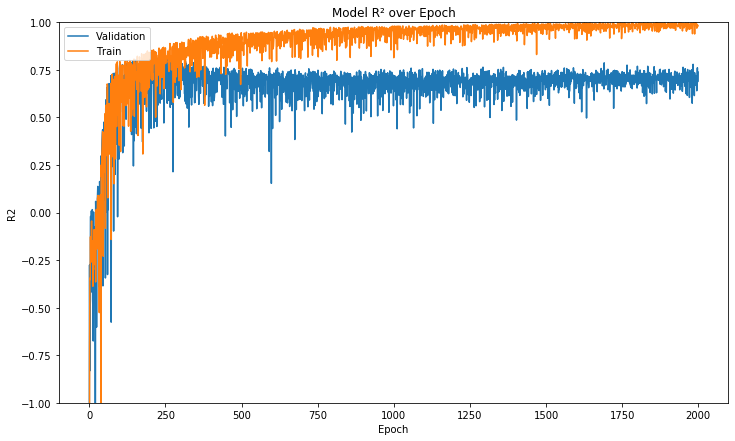

In [195]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history.history['val_coeff_determination'])
_ = ax.plot(history.history['coeff_determination'])
plt.ylim(-1, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

### 4. Tree-based methods

###  Random Forest

R2 on calibration:  0.9646165674008151
R2 on validation:  0.7973913676697647
R2 on test set:  0.6638488547408328


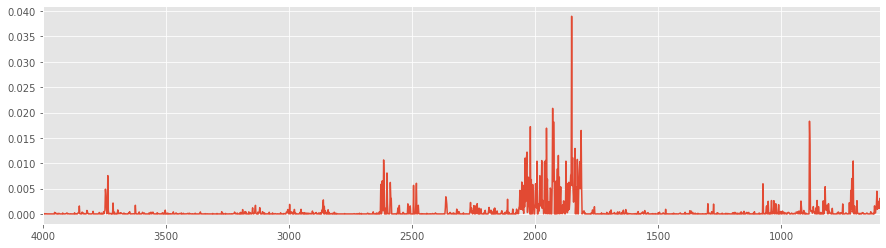

In [7]:
# On an easy one
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
analyte = 'TOC'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_test_analyte = get_analyte(y_test, y_names, analyte)

rnd_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(X_train, y_train_analyte)

y_c = rnd_reg.predict(X_train)
y_t_hat = rnd_reg.predict(X_test)

y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

score_c = r2_score(y_train_analyte, y_c)
score_cv = r2_score(y_train_analyte, y_cv)
score_t_hat = r2_score(y_test_analyte, y_t_hat)
print('R2 on calibration: ', score_c)
print('R2 on validation: ', score_cv)
print('R2 on test set: ', score_t_hat)

# Visualizing feature importance
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, rnd_reg.feature_importances_)

In [14]:
X_train.shape

(91, 1763)

R2 on calibration:  0.9624164110847959
R2 on validation:  0.7168645004406073
R2 on test set:  0.7519001804395926


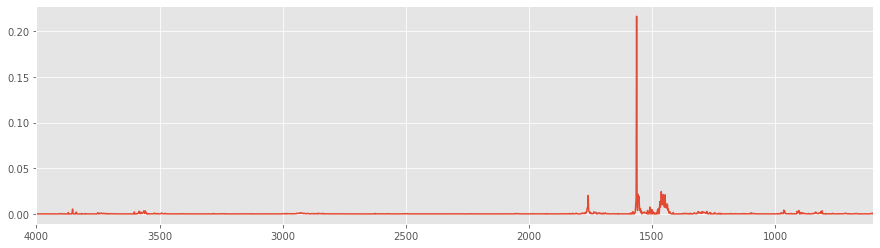

In [5]:
# On an difficult one
# Removing NaN first
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

X_train, X_test, y_train, y_test = train_test_split(X_not_nan, y_not_nan, test_size=0.20, random_state=42)
analyte = 'K'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_test_analyte = get_analyte(y_test, y_names, analyte)

rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=10, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(X_train, y_train_analyte)

y_c = rnd_reg.predict(X_train)
y_t_hat = rnd_reg.predict(X_test)

y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

score_c = r2_score(y_train_analyte, y_c)
score_cv = r2_score(y_train_analyte, y_cv)
score_t_hat = r2_score(y_test_analyte, y_t_hat)
print('R2 on calibration: ', score_c)
print('R2 on validation: ', score_cv)
print('R2 on test set: ', score_t_hat)

# Visualizing feature importance
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, rnd_reg.feature_importances_)

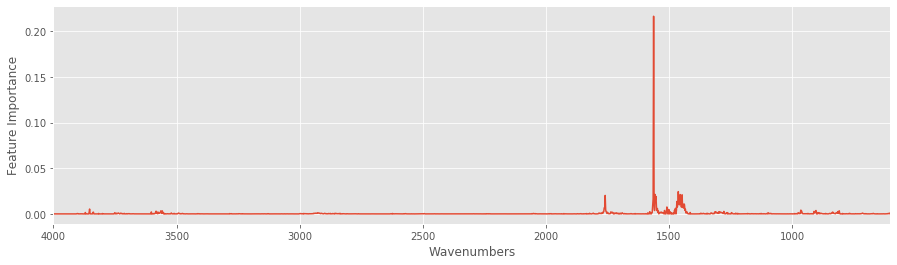

In [8]:
# Visualizing feature importance
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, rnd_reg.feature_importances_)
    plt.xlabel('Wavenumbers')
    plt.ylabel('Feature Importance')

### What about PLSR on the same dataset?

********************
Predicting:  K
********************
Suggested number of components:  15


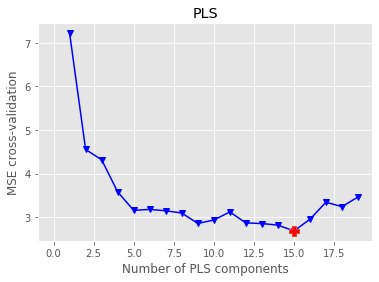

R2 calib: 0.963
R2 CV: 0.830
MSE calib: 0.588
MSE CV: 2.688


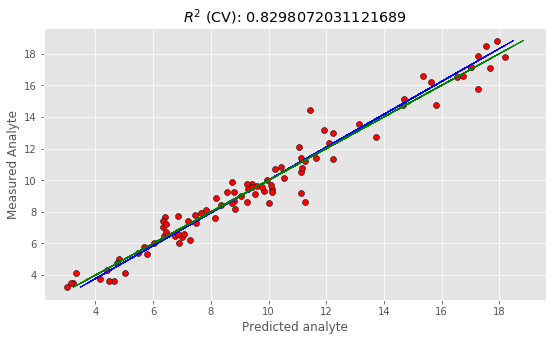

In [10]:
# With cross-validation
X1_all = savgol_filter(X_train, 11, polyorder = 1, deriv=1)

for analyte in ['K']:
    optimise_pls_cv(X1_all, y_train, n_comp=20, cv=5, plot_components=True, analyte=analyte)

In [13]:
pls = PLSRegression(n_components=15)
pls.fit(X_train, y_train)
y_train_pred = pls.predict(X_train)
y_test_pred = pls.predict(X_test)
score_train = r2_score(y_test_pred, y_test)
print('R2 test (PLS): %5.3f'  % score_train)

R2 test (PLS): 0.435
